In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
vest = pd.read_csv('./data/vestigingen.csv', sep=';', dtype=str, encoding='windows-1252')
afvoer = pd.read_csv('./data/afvoer.csv', sep='\t', dtype={'eigenaar': 'str'})

# instantie_id toevoegen
vest_inst = vest[['vestiging', 'instantie_id', 'bibliotheek']]
vest_inst.columns = ['eigenaar', 'instantie_id', 'bibliotheek']
afvoer = afvoer.merge(vest_inst, on='eigenaar', how='left')

# lijst instantie_id's
instanties = vest.instantie_id.unique()

In [3]:
# aanpassingen in data

# exemplaar met negatief aantal uitleningen naar 0 omzetten
afvoer.loc[afvoer.tot_uitl < 0, 'tot_uitl'] = 0

# exemplaren met meer uitleningen dan 99ste percentiel wegknippen om rare outliers te vermijden
afvoer = afvoer[afvoer.tot_uitl < afvoer.tot_uitl.quantile(0.99)]


In [4]:
def plot_afvoer_instantie(instantie_id):
    """ functie om samenvattende gegevens en boxplot op materiaal te maken voor één instantie"""
    naam = vest[vest.instantie_id == instantie_id].bibliotheek.unique()[0]
    df = afvoer[afvoer.instantie_id == instantie_id]
    if len(df) > 0:  # instanties zonder data uitsluiten
        desc = df[['tot_uitl', 'ltst_jaar_uit', 'lft_exem']].describe()
        desc['instantie_id'] = instantie_id
        desc['bibliotheek'] = naam
        print(naam)
        box = sns.boxplot(data=df, x='materiaal', y='tot_uitl')
        plt.title(f'{instantie_id}: {naam}')
        plt.show()
        display(desc)
        print('_' * 60)
        return desc


# AFGEVOERDE EXEMPLAREN IN WISE

## Wat is er geteld

Een afgeschreven exemplaar blijft na inschrijven nog 2 jaar in de databank, daarna wordt het definitief verwijderd. De analyse is dus beperkt tot maximaal de laatste 2 jaar. Voor bibliotheken die minder dan 2 jaar op Wise zitten gaat het enkel over de periode na de migratie (afgevoerde exemplaren komen niet mee bij conversie).

de lijst */data/afvoer.csv* bevat alle exemplaren uit Wise die op dit moment afgevoerd zijn en nog niet uit de databank zijn geschrapt. Enkel de exemplaren met materiaal boek (rmt begint met B) zijn opgenomen in de lijst.

Van elk exemplaar is geteld hoeveel keer het in totaal werd uitgeleend (*tot_uitl*), het laatste jaar waarin het exemplaar werd geleend (*ltst_jaar_uit*) en wat de leeftijd van het exemplaar was in jaar (*lft_exem*) op het moment van afvoer. Het aantal uitleningen is gebaseerd op de tabel exemteller waarin het aantal uitleningen sinds de invoer van het exemplaar wordt bijgehouden (ook uit oude systemen). Binnen de teller kan wel een inconsistentie zitten omdat het oude systeem enkel uitleningen telde en Wise uitleningen samen met verlengingen optelt in het cijfer. Ook het jaar van laatste uitleen is opgenomen.


## Hoe is er geteld

Om de lange lijst van exemplaren inzichtelijk te houden is gekeken naar de distrubutie van de data aan de hand van samenvattende statistische data:

    - count = aantal afgevoerde exemplaren
    - mean = gemiddelde
    - std = standaarddeviatie
    - min = minimum
    - 25% = 25ste percentiel / 1ste kwartiel
    - 50% = mediaan
    - 75% = 75ste percentiel / 3de kwartiel
    - max = maximum
    
Met een boxplot kunnen deze gegevens ook visueel worden weergegeven, waarbij de onderkant van het gekleurde vlak overeenkomt met het 25ste percentiel, de bovengrens van het gekleurde vlak met het 75ste percentiel en de horizontale lijn in het midden met de mediaan. Met een boxplot is makkelijk om verschillende categorieën binnen een set naast elkaar te leggen om te vergelijken. Hier hebben we dat gedaan met de materiaalsoorten.

## ANALYSE OVER HELE SYSTEEM HEEN


In [5]:
desc_total_set = afvoer.describe()[['tot_uitl', 'ltst_jaar_uit', 'lft_exem']].round(2)
display(desc_total_set)

tot_uitl  ltst_jaar_uit    lft_exem
count  1529266.00     1529266.00  1520957.00
mean        19.29        2018.12       11.45
std         19.49           3.68        5.80
min          0.00        1993.00        0.00
25%          5.00        2016.00        7.00
50%         12.00        2019.00       11.00
75%         27.00        2021.00       15.00
max        100.00        2022.00       44.00

Er zitten 1 529 266 afgevoerde exemplaren in het systeem. Het aantal uitleningen van deze exemplaren varieert tussen 0 en 100 met een gemiddelde van 19 uitleningen (mediaan is 12). Een afgevoerd exemplaar is gemiddeld 11,45 jaar oud.

## Per materiaal

De materialen B2 tem B5 zijn in elke bibliotheek in gebruik, de andere materialen zijn in veel minder bibliotheken in gebruik en gaat dus over een onevenredig deel van de collectie. Prentenboeken zitten meestal bij B4, net als adolescentenboeken.

De materialen zijn:

- B	: Boek
- B2 : Boek volw. fictie
- B3 : Boek volw. non-fictie
- B4 : Boek jeugd fictie
- B5 : Boek jeugd non-fictie
- BA : Boek adolescent
- BI : Boek IBL
- BP : Prentenboek
- BR : Boek sprinter jeugd
- BS : Boek sprinter volw.

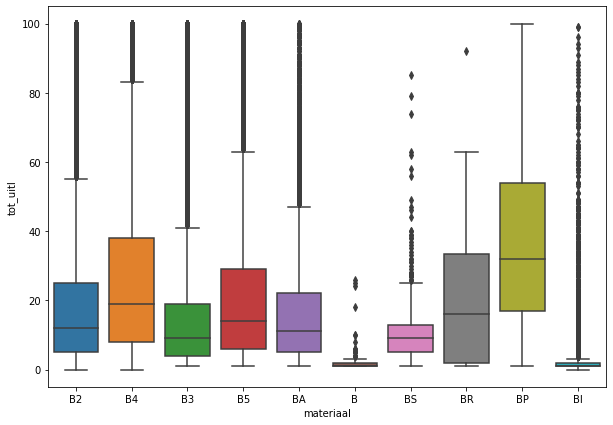

In [6]:
fig = plt.subplots(figsize=(10,7))
box_total_set = sns.boxplot(data=afvoer, x='materiaal', y='tot_uitl')
plt.show()


Zowel bij jeugd als bij volwassenen ligt het aantal uitleningen voor afvoer hoger bij fictie dan bij non-fictie (gemiddeld 28% meer bij volwassenen en 25% procent bij de jeugd). De jeugdcollectie heeft meer uitleningen per exemplaar dan de volwassenencollectie (voor fictie 38% meer, 40% voor non-fictie).

De gemiddelde waarden per materiaal:



In [7]:
display(afvoer.groupby('materiaal').mean()[['tot_uitl', 'ltst_jaar_uit', 'lft_exem']].round(2))

tot_uitl  ltst_jaar_uit  lft_exem
materiaal                                   
B              2.16        2020.84      2.22
B2            17.94        2017.70     11.11
B3            13.80        2017.04     12.13
B4            25.58        2019.12     11.48
B5            20.13        2018.70     12.84
BA            16.45        2017.72     10.99
BI             2.22        2021.47      0.28
BP            36.98        2020.44      9.45
BR            21.46        2020.18      6.07
BS             9.85        2021.08      0.30

## PER BIBLIOTHEEK

Afvoercijfers per bibliotheek, per materiaal en samenvattende cijfers over alle afvoer van de bibliotheek.

Boxplot toont de spreiding van het totaal aantal uitlening van de afgevoerde exemplaren per materiaalsoort

De tabel toont de samenvattende info voor alle afgevoerde exemplaren van de bibliotheek.  


Bibliotheek Bree


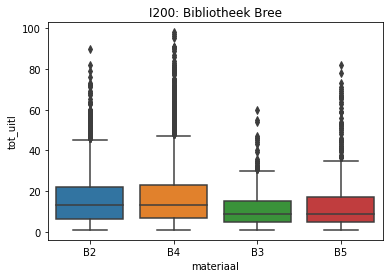

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  6750.000000    6750.000000  6750.000000         I200  Bibliotheek Bree
mean     15.750370    2018.736444    10.903556         I200  Bibliotheek Bree
std      13.993237       2.051209     5.727530         I200  Bibliotheek Bree
min       1.000000    2010.000000     0.000000         I200  Bibliotheek Bree
25%       6.000000    2018.000000     6.000000         I200  Bibliotheek Bree
50%      12.000000    2019.000000     9.000000         I200  Bibliotheek Bree
75%      21.000000    2020.000000    15.000000         I200  Bibliotheek Bree
max      98.000000    2022.000000    22.000000         I200  Bibliotheek Bree

____________________________________________________________
Bibliotheek Oudsbergen


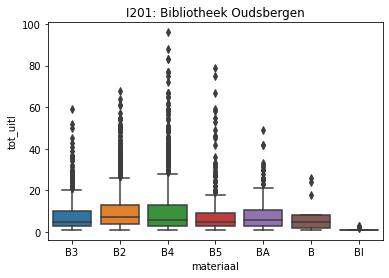

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4949.000000    4949.000000  4949.000000         I201   
mean      9.319661    2016.259446    10.219034         I201   
std       9.914125       3.210006     3.685783         I201   
min       1.000000    2006.000000     0.000000         I201   
25%       3.000000    2014.000000     7.000000         I201   
50%       6.000000    2017.000000    10.000000         I201   
75%      12.000000    2019.000000    14.000000         I201   
max      96.000000    2022.000000    17.000000         I201   

                  bibliotheek  
count  Bibliotheek Oudsbergen  
mean   Bibliotheek Oudsbergen  
std    Bibliotheek Oudsbergen  
min    Bibliotheek Oudsbergen  
25%    Bibliotheek Oudsbergen  
50%    Bibliotheek Oudsbergen  
75%    Bibliotheek Oudsbergen  
max    Bibliotheek Oudsbergen

____________________________________________________________
Bibliotheek Genk


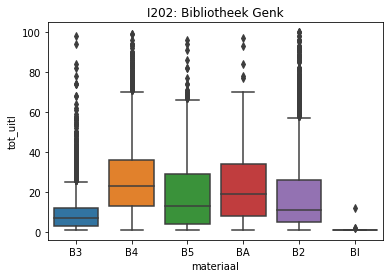

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  12776.000000   12776.000000  12776.000000         I202   
mean      18.892611    2018.372339      9.825219         I202   
std       17.452304       3.552919      4.308356         I202   
min        1.000000    2006.000000      0.000000         I202   
25%        6.000000    2017.000000      6.000000         I202   
50%       13.000000    2020.000000     10.000000         I202   
75%       27.000000    2021.000000     14.000000         I202   
max      100.000000    2022.000000     16.000000         I202   

            bibliotheek  
count  Bibliotheek Genk  
mean   Bibliotheek Genk  
std    Bibliotheek Genk  
min    Bibliotheek Genk  
25%    Bibliotheek Genk  
50%    Bibliotheek Genk  
75%    Bibliotheek Genk  
max    Bibliotheek Genk

____________________________________________________________
Bibliotheek Alken


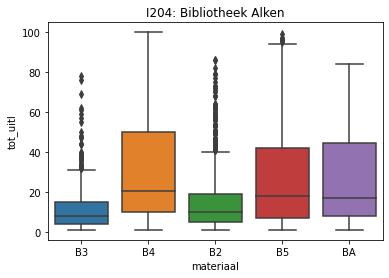

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  2527.000000    2527.000000  2527.000000         I204  Bibliotheek Alken
mean     19.667590    2014.731302    17.880491         I204  Bibliotheek Alken
std      20.687365       4.696681     5.155535         I204  Bibliotheek Alken
min       1.000000    2000.000000     0.000000         I204  Bibliotheek Alken
25%       6.000000    2012.000000    15.000000         I204  Bibliotheek Alken
50%      12.000000    2016.000000    21.000000         I204  Bibliotheek Alken
75%      25.000000    2018.000000    22.000000         I204  Bibliotheek Alken
max     100.000000    2022.000000    22.000000         I204  Bibliotheek Alken

____________________________________________________________
Bibliotheek Beringen


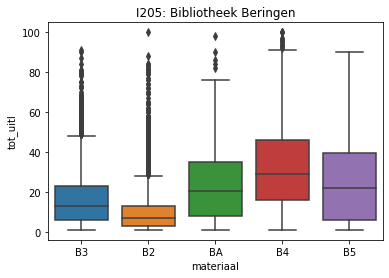

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7720.000000    7720.000000  7710.000000         I205   
mean     17.816710    2015.271762    13.332944         I205   
std      17.241574       5.816558     7.256295         I205   
min       1.000000    1996.000000     0.000000         I205   
25%       5.000000    2012.000000     8.000000         I205   
50%      12.000000    2016.000000    12.000000         I205   
75%      25.000000    2020.000000    20.000000         I205   
max     100.000000    2022.000000    29.000000         I205   

                bibliotheek  
count  Bibliotheek Beringen  
mean   Bibliotheek Beringen  
std    Bibliotheek Beringen  
min    Bibliotheek Beringen  
25%    Bibliotheek Beringen  
50%    Bibliotheek Beringen  
75%    Bibliotheek Beringen  
max    Bibliotheek Beringen

____________________________________________________________
Bibliotheek Bocholt


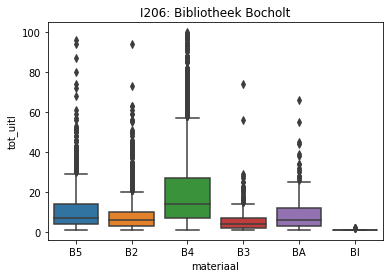

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8346.000000    8346.000000  8346.000000         I206   
mean     14.047448    2018.201893     9.606278         I206   
std      14.875022       2.339716     3.781767         I206   
min       1.000000    2007.000000     0.000000         I206   
25%       4.000000    2017.000000     7.000000         I206   
50%       9.000000    2019.000000    10.000000         I206   
75%      18.000000    2020.000000    13.000000         I206   
max     100.000000    2022.000000    16.000000         I206   

               bibliotheek  
count  Bibliotheek Bocholt  
mean   Bibliotheek Bocholt  
std    Bibliotheek Bocholt  
min    Bibliotheek Bocholt  
25%    Bibliotheek Bocholt  
50%    Bibliotheek Bocholt  
75%    Bibliotheek Bocholt  
max    Bibliotheek Bocholt

____________________________________________________________
Bibliotheek Borgloon


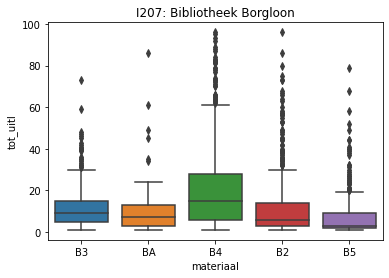

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2422.000000    2422.000000  2422.000000         I207   
mean     14.611478    2015.235343    15.588770         I207   
std      15.911457       4.549868     2.364233         I207   
min       1.000000    2004.000000     0.000000         I207   
25%       4.000000    2012.000000    16.000000         I207   
50%       9.000000    2016.000000    16.000000         I207   
75%      20.000000    2019.000000    16.000000         I207   
max      96.000000    2022.000000    17.000000         I207   

                bibliotheek  
count  Bibliotheek Borgloon  
mean   Bibliotheek Borgloon  
std    Bibliotheek Borgloon  
min    Bibliotheek Borgloon  
25%    Bibliotheek Borgloon  
50%    Bibliotheek Borgloon  
75%    Bibliotheek Borgloon  
max    Bibliotheek Borgloon

____________________________________________________________
Bibliotheek Gingelom


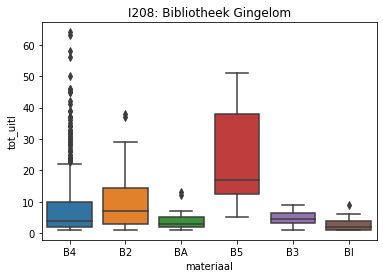

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  805.000000     805.000000  805.000000         I208   
mean     8.053416    2015.732919   14.508075         I208   
std      9.827030       4.380471    4.047172         I208   
min      1.000000    2006.000000    0.000000         I208   
25%      2.000000    2012.000000   15.000000         I208   
50%      4.000000    2017.000000   16.000000         I208   
75%      9.000000    2019.000000   17.000000         I208   
max     64.000000    2022.000000   17.000000         I208   

                bibliotheek  
count  Bibliotheek Gingelom  
mean   Bibliotheek Gingelom  
std    Bibliotheek Gingelom  
min    Bibliotheek Gingelom  
25%    Bibliotheek Gingelom  
50%    Bibliotheek Gingelom  
75%    Bibliotheek Gingelom  
max    Bibliotheek Gingelom

____________________________________________________________
Bibliotheek Halen


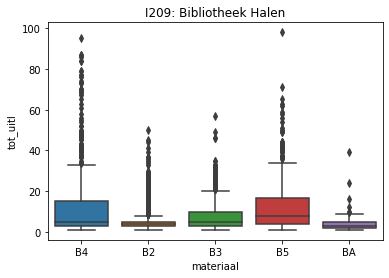

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  4752.000000    4752.000000  4751.000000         I209  Bibliotheek Halen
mean      7.221801    2018.036827     8.332772         I209  Bibliotheek Halen
std       9.530046       2.736770     2.822872         I209  Bibliotheek Halen
min       1.000000    2010.000000     0.000000         I209  Bibliotheek Halen
25%       3.000000    2016.000000     6.000000         I209  Bibliotheek Halen
50%       4.000000    2018.000000     9.000000         I209  Bibliotheek Halen
75%       7.000000    2020.000000    11.000000         I209  Bibliotheek Halen
max      98.000000    2022.000000    12.000000         I209  Bibliotheek Halen

____________________________________________________________
Bibliotheek Ham


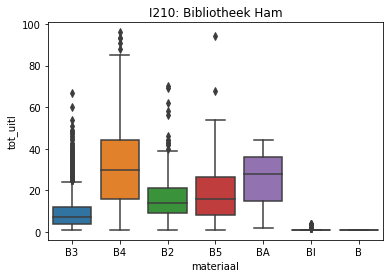

tot_uitl  ltst_jaar_uit     lft_exem instantie_id      bibliotheek
count  3890.000000    3890.000000  3890.000000         I210  Bibliotheek Ham
mean     12.625964    2017.908226    12.621851         I210  Bibliotheek Ham
std      13.373338       3.856858     4.283798         I210  Bibliotheek Ham
min       1.000000    2005.000000     0.000000         I210  Bibliotheek Ham
25%       4.000000    2016.000000    11.000000         I210  Bibliotheek Ham
50%       8.000000    2019.000000    14.000000         I210  Bibliotheek Ham
75%      16.000000    2021.000000    16.000000         I210  Bibliotheek Ham
max      96.000000    2022.000000    17.000000         I210  Bibliotheek Ham

____________________________________________________________
Bibliotheek Hamont-Achel


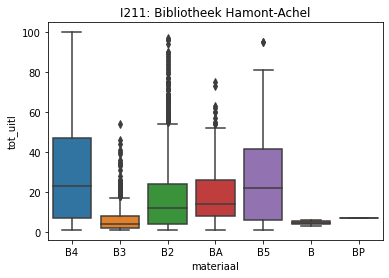

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5487.000000    5487.000000  5487.000000         I211   
mean     19.863678    2014.076362    18.210680         I211   
std      20.271678       5.790060     3.293252         I211   
min       1.000000    2001.000000     0.000000         I211   
25%       4.000000    2010.000000    17.000000         I211   
50%      13.000000    2016.000000    19.000000         I211   
75%      29.000000    2019.000000    21.000000         I211   
max     100.000000    2022.000000    23.000000         I211   

                    bibliotheek  
count  Bibliotheek Hamont-Achel  
mean   Bibliotheek Hamont-Achel  
std    Bibliotheek Hamont-Achel  
min    Bibliotheek Hamont-Achel  
25%    Bibliotheek Hamont-Achel  
50%    Bibliotheek Hamont-Achel  
75%    Bibliotheek Hamont-Achel  
max    Bibliotheek Hamont-Achel

____________________________________________________________
Bibliotheek Hasselt Limburg


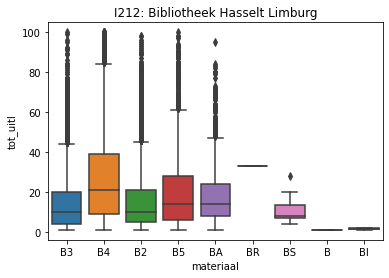

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  30354.000000   30354.000000  30350.000000         I212   
mean      17.625387    2017.605917     10.172323         I212   
std       17.031767       4.215742      4.624098         I212   
min        1.000000    1998.000000      0.000000         I212   
25%        5.000000    2015.000000      7.000000         I212   
50%       12.000000    2019.000000     10.000000         I212   
75%       25.000000    2021.000000     12.000000         I212   
max      100.000000    2022.000000     24.000000         I212   

                       bibliotheek  
count  Bibliotheek Hasselt Limburg  
mean   Bibliotheek Hasselt Limburg  
std    Bibliotheek Hasselt Limburg  
min    Bibliotheek Hasselt Limburg  
25%    Bibliotheek Hasselt Limburg  
50%    Bibliotheek Hasselt Limburg  
75%    Bibliotheek Hasselt Limburg  
max    Bibliotheek Hasselt Limburg

____________________________________________________________
Bibliotheek Heers


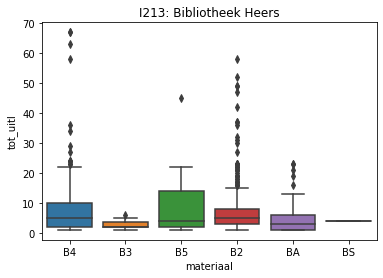

tot_uitl  ltst_jaar_uit    lft_exem instantie_id        bibliotheek
count  730.000000     730.000000  730.000000         I213  Bibliotheek Heers
mean     7.042466    2014.610959   11.995890         I213  Bibliotheek Heers
std      8.405831       3.395210    3.237933         I213  Bibliotheek Heers
min      1.000000    2006.000000    1.000000         I213  Bibliotheek Heers
25%      2.000000    2013.000000   10.000000         I213  Bibliotheek Heers
50%      4.000000    2015.000000   13.000000         I213  Bibliotheek Heers
75%      8.000000    2016.000000   15.000000         I213  Bibliotheek Heers
max     67.000000    2022.000000   16.000000         I213  Bibliotheek Heers

____________________________________________________________
Bibliotheek Herk-de-Stad


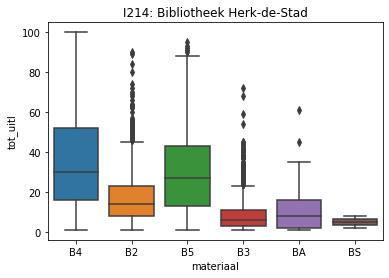

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4892.000000    4892.000000  4892.000000         I214   
mean     23.346688    2019.239575    10.918438         I214   
std      21.379600       3.074260     3.760909         I214   
min       1.000000    2005.000000     0.000000         I214   
25%       7.000000    2018.000000     8.000000         I214   
50%      16.000000    2020.000000    11.000000         I214   
75%      33.000000    2021.000000    14.000000         I214   
max     100.000000    2022.000000    16.000000         I214   

                    bibliotheek  
count  Bibliotheek Herk-de-Stad  
mean   Bibliotheek Herk-de-Stad  
std    Bibliotheek Herk-de-Stad  
min    Bibliotheek Herk-de-Stad  
25%    Bibliotheek Herk-de-Stad  
50%    Bibliotheek Herk-de-Stad  
75%    Bibliotheek Herk-de-Stad  
max    Bibliotheek Herk-de-Stad

____________________________________________________________
Bibliotheek Hoeselt


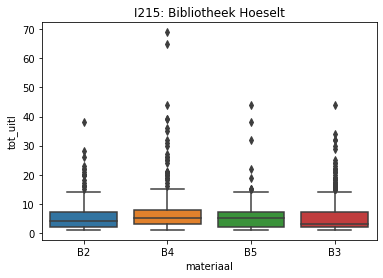

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1361.000000    1361.000000  1361.000000         I215   
mean      5.894195    2015.366642    11.357825         I215   
std       6.343985       3.668231     3.986073         I215   
min       1.000000    2004.000000     1.000000         I215   
25%       2.000000    2013.000000     9.000000         I215   
50%       4.000000    2016.000000    12.000000         I215   
75%       7.000000    2018.000000    15.000000         I215   
max      69.000000    2022.000000    17.000000         I215   

               bibliotheek  
count  Bibliotheek Hoeselt  
mean   Bibliotheek Hoeselt  
std    Bibliotheek Hoeselt  
min    Bibliotheek Hoeselt  
25%    Bibliotheek Hoeselt  
50%    Bibliotheek Hoeselt  
75%    Bibliotheek Hoeselt  
max    Bibliotheek Hoeselt

____________________________________________________________
Bibliotheek Kortessem


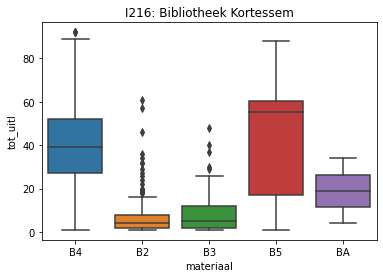

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  704.000000     704.000000  704.000000         I216   
mean    24.649148    2016.737216   13.514205         I216   
std     22.531733       3.957884    3.497176         I216   
min      1.000000    2005.000000    1.000000         I216   
25%      4.000000    2014.000000   11.000000         I216   
50%     18.500000    2019.000000   16.000000         I216   
75%     41.000000    2020.000000   16.000000         I216   
max     92.000000    2022.000000   17.000000         I216   

                 bibliotheek  
count  Bibliotheek Kortessem  
mean   Bibliotheek Kortessem  
std    Bibliotheek Kortessem  
min    Bibliotheek Kortessem  
25%    Bibliotheek Kortessem  
50%    Bibliotheek Kortessem  
75%    Bibliotheek Kortessem  
max    Bibliotheek Kortessem

____________________________________________________________
Bibliotheek Lanaken


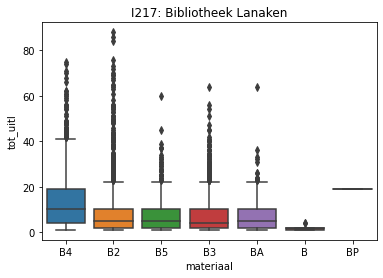

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9122.000000    9122.000000  9122.000000         I217   
mean      9.036396    2018.290287    12.845648         I217   
std       9.424219       2.278189     5.780765         I217   
min       1.000000    2000.000000     0.000000         I217   
25%       2.000000    2017.000000     9.000000         I217   
50%       6.000000    2019.000000    11.000000         I217   
75%      12.000000    2020.000000    16.000000         I217   
max      88.000000    2022.000000    29.000000         I217   

               bibliotheek  
count  Bibliotheek Lanaken  
mean   Bibliotheek Lanaken  
std    Bibliotheek Lanaken  
min    Bibliotheek Lanaken  
25%    Bibliotheek Lanaken  
50%    Bibliotheek Lanaken  
75%    Bibliotheek Lanaken  
max    Bibliotheek Lanaken

____________________________________________________________
Bibliotheek Leopoldsburg


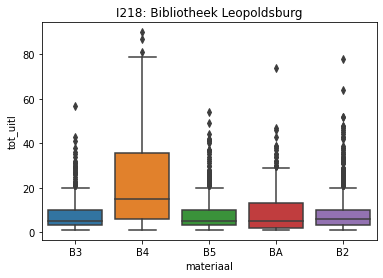

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4243.000000    4243.000000  4243.000000         I218   
mean      9.213528    2015.503653    11.275513         I218   
std      10.412140       3.243195     3.932089         I218   
min       1.000000    2005.000000     0.000000         I218   
25%       3.000000    2014.000000     8.000000         I218   
50%       6.000000    2016.000000    11.000000         I218   
75%      11.000000    2017.000000    15.000000         I218   
max      90.000000    2022.000000    17.000000         I218   

                    bibliotheek  
count  Bibliotheek Leopoldsburg  
mean   Bibliotheek Leopoldsburg  
std    Bibliotheek Leopoldsburg  
min    Bibliotheek Leopoldsburg  
25%    Bibliotheek Leopoldsburg  
50%    Bibliotheek Leopoldsburg  
75%    Bibliotheek Leopoldsburg  
max    Bibliotheek Leopoldsburg

____________________________________________________________
Bibliotheek Lommel


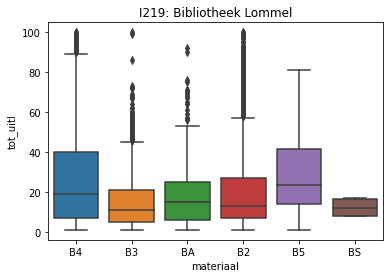

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7689.000000    7689.000000  7689.000000         I219   
mean     20.183509    2018.615034     9.441540         I219   
std      19.428328       3.171980     5.086095         I219   
min       1.000000    2000.000000     0.000000         I219   
25%       6.000000    2018.000000     6.000000         I219   
50%      14.000000    2020.000000     8.000000         I219   
75%      28.000000    2021.000000    11.000000         I219   
max     100.000000    2022.000000    33.000000         I219   

              bibliotheek  
count  Bibliotheek Lommel  
mean   Bibliotheek Lommel  
std    Bibliotheek Lommel  
min    Bibliotheek Lommel  
25%    Bibliotheek Lommel  
50%    Bibliotheek Lommel  
75%    Bibliotheek Lommel  
max    Bibliotheek Lommel

____________________________________________________________
Bibliotheek Lummen


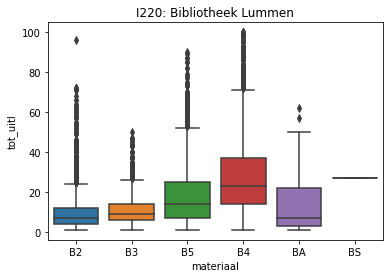

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7422.000000    7422.000000  7422.000000         I220   
mean     16.210455    2017.163972    13.078685         I220   
std      15.610849       3.119276     2.702618         I220   
min       1.000000    2006.000000     0.000000         I220   
25%       6.000000    2015.000000    12.000000         I220   
50%      11.000000    2018.000000    14.000000         I220   
75%      21.000000    2020.000000    15.000000         I220   
max     100.000000    2022.000000    16.000000         I220   

              bibliotheek  
count  Bibliotheek Lummen  
mean   Bibliotheek Lummen  
std    Bibliotheek Lummen  
min    Bibliotheek Lummen  
25%    Bibliotheek Lummen  
50%    Bibliotheek Lummen  
75%    Bibliotheek Lummen  
max    Bibliotheek Lummen

____________________________________________________________
Bibliotheek Maaseik


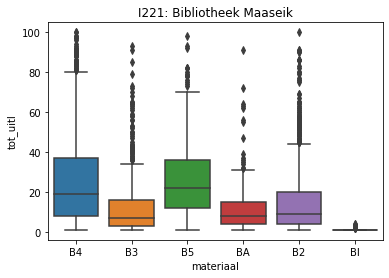

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4156.000000    4156.000000  4156.000000         I221   
mean     18.564966    2017.270693    10.247353         I221   
std      18.996088       4.730994     4.307264         I221   
min       1.000000    1995.000000     0.000000         I221   
25%       5.000000    2016.000000     7.000000         I221   
50%      12.000000    2018.000000    10.000000         I221   
75%      26.000000    2021.000000    14.000000         I221   
max     100.000000    2022.000000    22.000000         I221   

               bibliotheek  
count  Bibliotheek Maaseik  
mean   Bibliotheek Maaseik  
std    Bibliotheek Maaseik  
min    Bibliotheek Maaseik  
25%    Bibliotheek Maaseik  
50%    Bibliotheek Maaseik  
75%    Bibliotheek Maaseik  
max    Bibliotheek Maaseik

____________________________________________________________
Bibliotheek Pelt


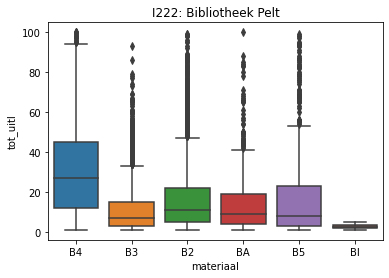

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  11745.000000   11745.000000  11745.000000         I222   
mean      20.287782    2017.444785     13.902852         I222   
std       20.155529       3.184020      5.058380         I222   
min        1.000000    2004.000000      0.000000         I222   
25%        5.000000    2015.000000     10.000000         I222   
50%       13.000000    2018.000000     15.000000         I222   
75%       30.000000    2020.000000     18.000000         I222   
max      100.000000    2022.000000     25.000000         I222   

            bibliotheek  
count  Bibliotheek Pelt  
mean   Bibliotheek Pelt  
std    Bibliotheek Pelt  
min    Bibliotheek Pelt  
25%    Bibliotheek Pelt  
50%    Bibliotheek Pelt  
75%    Bibliotheek Pelt  
max    Bibliotheek Pelt

____________________________________________________________
Bibliotheek Peer


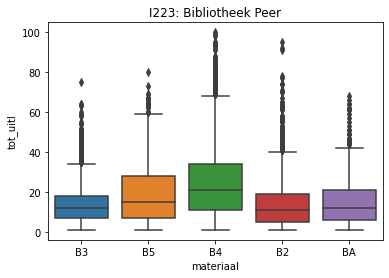

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  8814.000000    8814.000000  8814.000000         I223  Bibliotheek Peer
mean     19.834354    2019.262991    11.574654         I223  Bibliotheek Peer
std      15.832301       2.323453     3.812649         I223  Bibliotheek Peer
min       1.000000    2006.000000     0.000000         I223  Bibliotheek Peer
25%       8.000000    2018.000000     9.000000         I223  Bibliotheek Peer
50%      15.000000    2020.000000    13.000000         I223  Bibliotheek Peer
75%      27.000000    2021.000000    15.000000         I223  Bibliotheek Peer
max     100.000000    2022.000000    16.000000         I223  Bibliotheek Peer

____________________________________________________________
Bibliotheek Riemst


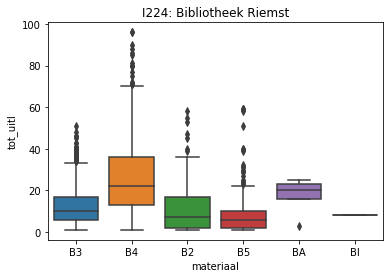

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2232.000000    2232.000000  2232.000000         I224   
mean     16.155914    2017.723566    12.000896         I224   
std      14.088307       2.768398     3.073870         I224   
min       1.000000    2007.000000     0.000000         I224   
25%       6.000000    2016.000000    10.000000         I224   
50%      12.000000    2019.000000    13.000000         I224   
75%      22.000000    2019.000000    14.000000         I224   
max      96.000000    2022.000000    15.000000         I224   

              bibliotheek  
count  Bibliotheek Riemst  
mean   Bibliotheek Riemst  
std    Bibliotheek Riemst  
min    Bibliotheek Riemst  
25%    Bibliotheek Riemst  
50%    Bibliotheek Riemst  
75%    Bibliotheek Riemst  
max    Bibliotheek Riemst

____________________________________________________________
Bibliotheek Sint-Truiden


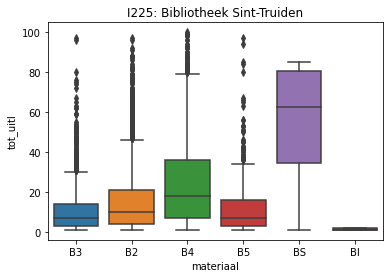

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9396.000000    9396.000000  9396.000000         I225   
mean     15.837271    2017.762239    11.227756         I225   
std      16.664623       3.377710     4.590508         I225   
min       1.000000    2005.000000     0.000000         I225   
25%       4.000000    2016.000000     8.000000         I225   
50%      10.000000    2019.000000    13.000000         I225   
75%      22.000000    2020.000000    15.000000         I225   
max     100.000000    2022.000000    17.000000         I225   

                    bibliotheek  
count  Bibliotheek Sint-Truiden  
mean   Bibliotheek Sint-Truiden  
std    Bibliotheek Sint-Truiden  
min    Bibliotheek Sint-Truiden  
25%    Bibliotheek Sint-Truiden  
50%    Bibliotheek Sint-Truiden  
75%    Bibliotheek Sint-Truiden  
max    Bibliotheek Sint-Truiden

____________________________________________________________
Cultuurhuis Tessenderlo


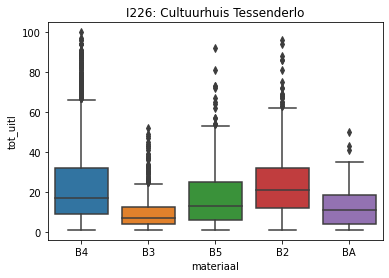

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5282.000000    5282.000000  5282.000000         I226   
mean     20.801212    2019.547520    10.289284         I226   
std      17.305804       2.278414     4.156792         I226   
min       1.000000    2007.000000     0.000000         I226   
25%       8.000000    2019.000000     7.000000         I226   
50%      16.000000    2020.000000    11.000000         I226   
75%      29.000000    2021.000000    14.000000         I226   
max     100.000000    2022.000000    16.000000         I226   

                   bibliotheek  
count  Cultuurhuis Tessenderlo  
mean   Cultuurhuis Tessenderlo  
std    Cultuurhuis Tessenderlo  
min    Cultuurhuis Tessenderlo  
25%    Cultuurhuis Tessenderlo  
50%    Cultuurhuis Tessenderlo  
75%    Cultuurhuis Tessenderlo  
max    Cultuurhuis Tessenderlo

____________________________________________________________
Bibliotheek Tongeren


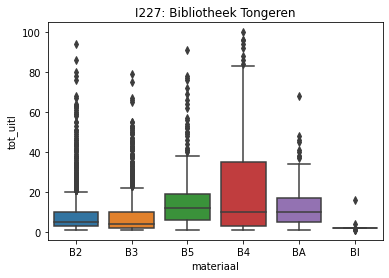

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5200.000000    5200.000000  5200.000000         I227   
mean     10.635192    2015.483462    13.164231         I227   
std      13.548890       4.082779     3.985831         I227   
min       1.000000    2005.000000     0.000000         I227   
25%       2.000000    2013.000000    11.000000         I227   
50%       6.000000    2016.000000    15.000000         I227   
75%      13.000000    2019.000000    16.000000         I227   
max     100.000000    2022.000000    17.000000         I227   

                bibliotheek  
count  Bibliotheek Tongeren  
mean   Bibliotheek Tongeren  
std    Bibliotheek Tongeren  
min    Bibliotheek Tongeren  
25%    Bibliotheek Tongeren  
50%    Bibliotheek Tongeren  
75%    Bibliotheek Tongeren  
max    Bibliotheek Tongeren

____________________________________________________________
Bibliotheek Voeren


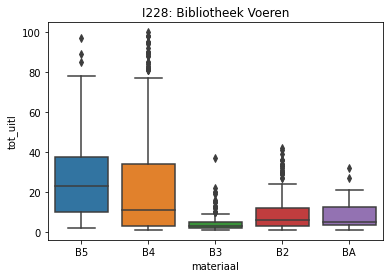

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1306.000000    1306.000000  1306.000000         I228   
mean     14.412711    2012.657734    19.523737         I228   
std      19.545733       6.679413     4.865530         I228   
min       1.000000    1998.000000     0.000000         I228   
25%       2.000000    2007.000000    17.000000         I228   
50%       6.000000    2014.000000    22.000000         I228   
75%      17.000000    2019.000000    23.000000         I228   
max     100.000000    2022.000000    24.000000         I228   

              bibliotheek  
count  Bibliotheek Voeren  
mean   Bibliotheek Voeren  
std    Bibliotheek Voeren  
min    Bibliotheek Voeren  
25%    Bibliotheek Voeren  
50%    Bibliotheek Voeren  
75%    Bibliotheek Voeren  
max    Bibliotheek Voeren

____________________________________________________________
Bibliotheek Wellen


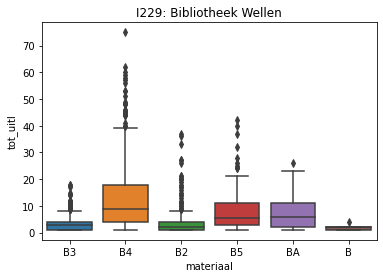

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1296.000000    1296.000000  1296.000000         I229   
mean      6.364969    2016.106481    14.084877         I229   
std       8.978927       4.229452     2.739763         I229   
min       1.000000    2006.000000     0.000000         I229   
25%       1.000000    2013.000000    14.000000         I229   
50%       3.000000    2019.000000    14.000000         I229   
75%       7.000000    2019.000000    16.000000         I229   
max      75.000000    2022.000000    17.000000         I229   

              bibliotheek  
count  Bibliotheek Wellen  
mean   Bibliotheek Wellen  
std    Bibliotheek Wellen  
min    Bibliotheek Wellen  
25%    Bibliotheek Wellen  
50%    Bibliotheek Wellen  
75%    Bibliotheek Wellen  
max    Bibliotheek Wellen

____________________________________________________________
Bibliotheek Zutendaal


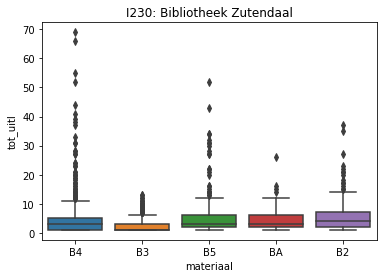

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1781.000000    1781.000000  1781.000000         I230   
mean      4.142055    2013.274565    11.539585         I230   
std       5.821167       3.258243     1.985687         I230   
min       1.000000    2009.000000     0.000000         I230   
25%       1.000000    2011.000000    11.000000         I230   
50%       2.000000    2013.000000    12.000000         I230   
75%       5.000000    2015.000000    13.000000         I230   
max      69.000000    2022.000000    13.000000         I230   

                 bibliotheek  
count  Bibliotheek Zutendaal  
mean   Bibliotheek Zutendaal  
std    Bibliotheek Zutendaal  
min    Bibliotheek Zutendaal  
25%    Bibliotheek Zutendaal  
50%    Bibliotheek Zutendaal  
75%    Bibliotheek Zutendaal  
max    Bibliotheek Zutendaal

____________________________________________________________
Bibliotheek Bilzen


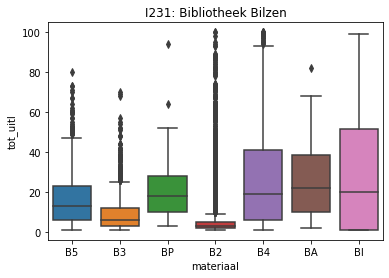

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9808.000000    9808.000000  9808.000000         I231   
mean     15.085950    2018.016619    11.188316         I231   
std      18.632636       3.728968     3.703324         I231   
min       1.000000    2007.000000     0.000000         I231   
25%       3.000000    2016.000000     8.000000         I231   
50%       6.000000    2019.000000    13.000000         I231   
75%      20.000000    2021.000000    14.000000         I231   
max     100.000000    2022.000000    15.000000         I231   

              bibliotheek  
count  Bibliotheek Bilzen  
mean   Bibliotheek Bilzen  
std    Bibliotheek Bilzen  
min    Bibliotheek Bilzen  
25%    Bibliotheek Bilzen  
50%    Bibliotheek Bilzen  
75%    Bibliotheek Bilzen  
max    Bibliotheek Bilzen

____________________________________________________________
Bibliotheek Diepenbeek


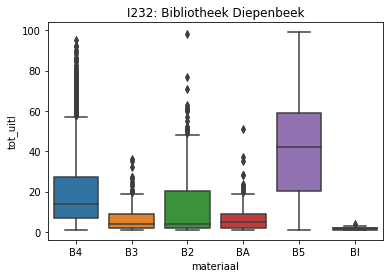

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3334.000000    3334.000000  3334.000000         I232   
mean     16.611578    2019.093581     9.527894         I232   
std      17.278225       2.750054     2.294863         I232   
min       1.000000    2011.000000     0.000000         I232   
25%       4.000000    2018.000000    10.000000         I232   
50%      10.000000    2020.000000    10.000000         I232   
75%      24.000000    2021.000000    11.000000         I232   
max      99.000000    2022.000000    11.000000         I232   

                  bibliotheek  
count  Bibliotheek Diepenbeek  
mean   Bibliotheek Diepenbeek  
std    Bibliotheek Diepenbeek  
min    Bibliotheek Diepenbeek  
25%    Bibliotheek Diepenbeek  
50%    Bibliotheek Diepenbeek  
75%    Bibliotheek Diepenbeek  
max    Bibliotheek Diepenbeek

____________________________________________________________
Bibliotheek Hechtel-Eksel


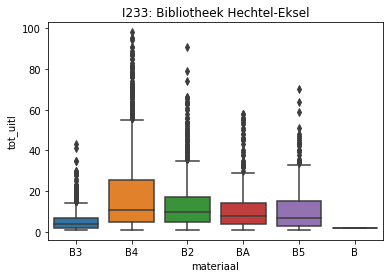

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4987.000000    4987.000000  4987.000000         I233   
mean     13.048927    2016.338280    12.162422         I233   
std      14.046796       3.900598     3.444548         I233   
min       1.000000    2007.000000     0.000000         I233   
25%       4.000000    2014.000000    10.000000         I233   
50%       8.000000    2016.000000    13.000000         I233   
75%      17.000000    2020.000000    15.000000         I233   
max      98.000000    2022.000000    15.000000         I233   

                     bibliotheek  
count  Bibliotheek Hechtel-Eksel  
mean   Bibliotheek Hechtel-Eksel  
std    Bibliotheek Hechtel-Eksel  
min    Bibliotheek Hechtel-Eksel  
25%    Bibliotheek Hechtel-Eksel  
50%    Bibliotheek Hechtel-Eksel  
75%    Bibliotheek Hechtel-Eksel  
max    Bibliotheek Hechtel-Eksel

____________________________________________________________
Bibliotheek Maasmechelen


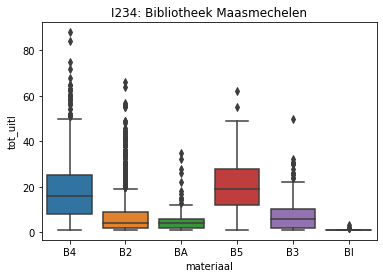

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4636.000000    4636.000000  4636.000000         I234   
mean     13.343615    2020.038827     5.838438         I234   
std      11.807459       1.849051     1.674608         I234   
min       1.000000    2014.000000     0.000000         I234   
25%       4.000000    2019.000000     5.000000         I234   
50%      10.000000    2021.000000     6.000000         I234   
75%      20.000000    2021.000000     7.000000         I234   
max      88.000000    2022.000000     7.000000         I234   

                    bibliotheek  
count  Bibliotheek Maasmechelen  
mean   Bibliotheek Maasmechelen  
std    Bibliotheek Maasmechelen  
min    Bibliotheek Maasmechelen  
25%    Bibliotheek Maasmechelen  
50%    Bibliotheek Maasmechelen  
75%    Bibliotheek Maasmechelen  
max    Bibliotheek Maasmechelen

____________________________________________________________
Bibliotheek Zonhoven


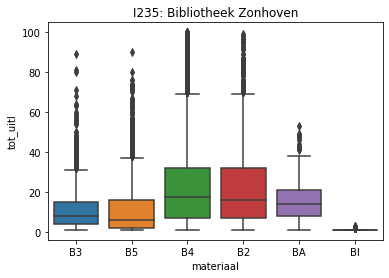

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  11467.000000   11467.000000  11467.000000         I235   
mean      18.270603    2018.777187      9.113369         I235   
std       18.069920       2.940211      2.914363         I235   
min        1.000000    2008.000000      0.000000         I235   
25%        5.000000    2018.000000      7.000000         I235   
50%       12.000000    2020.000000      9.000000         I235   
75%       26.000000    2021.000000     12.000000         I235   
max      100.000000    2022.000000     13.000000         I235   

                bibliotheek  
count  Bibliotheek Zonhoven  
mean   Bibliotheek Zonhoven  
std    Bibliotheek Zonhoven  
min    Bibliotheek Zonhoven  
25%    Bibliotheek Zonhoven  
50%    Bibliotheek Zonhoven  
75%    Bibliotheek Zonhoven  
max    Bibliotheek Zonhoven

____________________________________________________________
Bibliotheek As


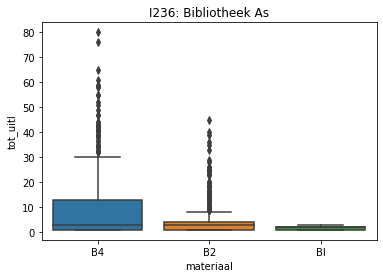

tot_uitl  ltst_jaar_uit    lft_exem instantie_id     bibliotheek
count  924.000000     924.000000  924.000000         I236  Bibliotheek As
mean     7.152597    2017.446970    8.199134         I236  Bibliotheek As
std     11.057394       3.813985    5.276880         I236  Bibliotheek As
min      1.000000    2010.000000    0.000000         I236  Bibliotheek As
25%      1.000000    2014.000000    3.000000         I236  Bibliotheek As
50%      3.000000    2019.000000    9.000000         I236  Bibliotheek As
75%      6.000000    2021.000000   12.000000         I236  Bibliotheek As
max     80.000000    2022.000000   20.000000         I236  Bibliotheek As

____________________________________________________________
Bibliotheek Dilsen-Stokkem


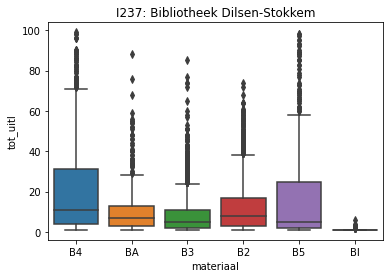

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9026.000000    9026.000000  9026.000000         I237   
mean     13.011411    2017.515289    17.029692         I237   
std      15.204249       3.240881     5.886762         I237   
min       1.000000    2010.000000     0.000000         I237   
25%       3.000000    2015.000000    13.000000         I237   
50%       7.000000    2019.000000    18.000000         I237   
75%      17.000000    2020.000000    22.000000         I237   
max      99.000000    2022.000000    26.000000         I237   

                      bibliotheek  
count  Bibliotheek Dilsen-Stokkem  
mean   Bibliotheek Dilsen-Stokkem  
std    Bibliotheek Dilsen-Stokkem  
min    Bibliotheek Dilsen-Stokkem  
25%    Bibliotheek Dilsen-Stokkem  
50%    Bibliotheek Dilsen-Stokkem  
75%    Bibliotheek Dilsen-Stokkem  
max    Bibliotheek Dilsen-Stokkem

____________________________________________________________
Bibliotheek Heusden-Zolder


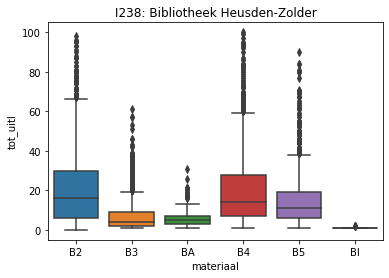

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8399.000000    8399.000000  8399.000000         I238   
mean     13.244553    2018.699964    11.364805         I238   
std      14.861541       2.827036     7.306512         I238   
min       0.000000    2010.000000     0.000000         I238   
25%       3.000000    2018.000000     5.000000         I238   
50%       8.000000    2019.000000    11.000000         I238   
75%      18.000000    2021.000000    17.000000         I238   
max     100.000000    2022.000000    26.000000         I238   

                      bibliotheek  
count  Bibliotheek Heusden-Zolder  
mean   Bibliotheek Heusden-Zolder  
std    Bibliotheek Heusden-Zolder  
min    Bibliotheek Heusden-Zolder  
25%    Bibliotheek Heusden-Zolder  
50%    Bibliotheek Heusden-Zolder  
75%    Bibliotheek Heusden-Zolder  
max    Bibliotheek Heusden-Zolder

____________________________________________________________
Bibliotheek Kinrooi


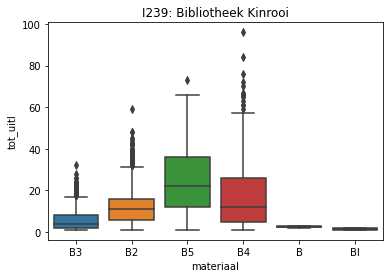

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4021.000000    4021.000000  4021.000000         I239   
mean     11.725939    2017.386471    10.800547         I239   
std      10.612252       2.584657     5.418093         I239   
min       1.000000    2010.000000     0.000000         I239   
25%       4.000000    2016.000000     7.000000         I239   
50%       9.000000    2018.000000    10.000000         I239   
75%      16.000000    2019.000000    15.000000         I239   
max      96.000000    2022.000000    21.000000         I239   

               bibliotheek  
count  Bibliotheek Kinrooi  
mean   Bibliotheek Kinrooi  
std    Bibliotheek Kinrooi  
min    Bibliotheek Kinrooi  
25%    Bibliotheek Kinrooi  
50%    Bibliotheek Kinrooi  
75%    Bibliotheek Kinrooi  
max    Bibliotheek Kinrooi

____________________________________________________________
Bibliotheek Houthalen-Helchteren


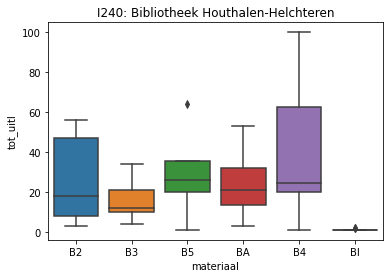

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count   71.000000      71.000000  71.000000         I240   
mean    22.605634    2016.647887  10.070423         I240   
std     23.828841       5.840985   7.069702         I240   
min      1.000000    2007.000000   0.000000         I240   
25%      3.000000    2010.000000   3.000000         I240   
50%     18.000000    2022.000000  12.000000         I240   
75%     27.500000    2022.000000  16.000000         I240   
max    100.000000    2022.000000  20.000000         I240   

                            bibliotheek  
count  Bibliotheek Houthalen-Helchteren  
mean   Bibliotheek Houthalen-Helchteren  
std    Bibliotheek Houthalen-Helchteren  
min    Bibliotheek Houthalen-Helchteren  
25%    Bibliotheek Houthalen-Helchteren  
50%    Bibliotheek Houthalen-Helchteren  
75%    Bibliotheek Houthalen-Helchteren  
max    Bibliotheek Houthalen-Helchteren

____________________________________________________________
Bibliotheek Aalst


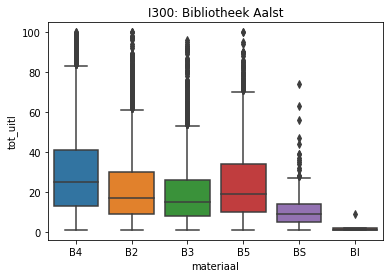

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  18233.000000   18233.000000  18233.000000         I300   
mean      23.875500    2019.716009      9.217134         I300   
std       18.776215       2.628671      5.762329         I300   
min        1.000000    1993.000000      0.000000         I300   
25%       10.000000    2019.000000      5.000000         I300   
50%       19.000000    2020.000000      9.000000         I300   
75%       33.000000    2021.000000     13.000000         I300   
max      100.000000    2022.000000     29.000000         I300   

             bibliotheek  
count  Bibliotheek Aalst  
mean   Bibliotheek Aalst  
std    Bibliotheek Aalst  
min    Bibliotheek Aalst  
25%    Bibliotheek Aalst  
50%    Bibliotheek Aalst  
75%    Bibliotheek Aalst  
max    Bibliotheek Aalst

____________________________________________________________
Bibliotheek Erpe-Mere


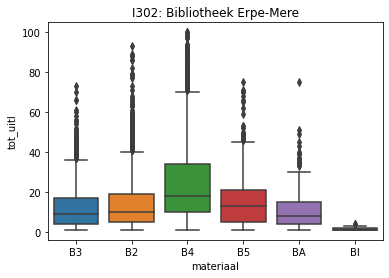

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6897.000000    6897.000000  6897.000000         I302   
mean     16.821082    2018.849210    11.650428         I302   
std      16.120806       2.570333     5.562477         I302   
min       1.000000    2009.000000     0.000000         I302   
25%       6.000000    2018.000000     8.000000         I302   
50%      12.000000    2020.000000    11.000000         I302   
75%      22.000000    2021.000000    15.000000         I302   
max     100.000000    2022.000000    28.000000         I302   

                 bibliotheek  
count  Bibliotheek Erpe-Mere  
mean   Bibliotheek Erpe-Mere  
std    Bibliotheek Erpe-Mere  
min    Bibliotheek Erpe-Mere  
25%    Bibliotheek Erpe-Mere  
50%    Bibliotheek Erpe-Mere  
75%    Bibliotheek Erpe-Mere  
max    Bibliotheek Erpe-Mere

____________________________________________________________
Bibliotheek Denderleeuw


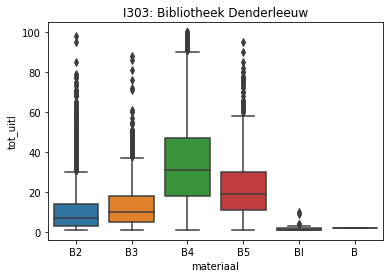

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7830.000000    7830.000000  7830.000000         I303   
mean     22.383653    2019.202427    12.308685         I303   
std      19.878715       2.718452     5.688388         I303   
min       1.000000    2006.000000     0.000000         I303   
25%       7.000000    2017.000000     9.000000         I303   
50%      16.000000    2020.000000    12.000000         I303   
75%      32.000000    2021.000000    16.000000         I303   
max     100.000000    2022.000000    29.000000         I303   

                   bibliotheek  
count  Bibliotheek Denderleeuw  
mean   Bibliotheek Denderleeuw  
std    Bibliotheek Denderleeuw  
min    Bibliotheek Denderleeuw  
25%    Bibliotheek Denderleeuw  
50%    Bibliotheek Denderleeuw  
75%    Bibliotheek Denderleeuw  
max    Bibliotheek Denderleeuw

____________________________________________________________
Bibliotheek Haaltert


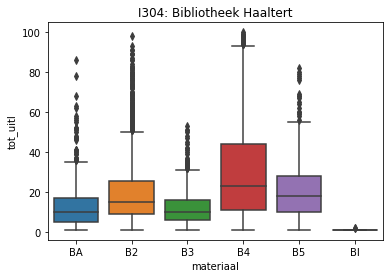

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7422.000000    7422.000000  7422.000000         I304   
mean     21.477499    2018.900296    12.215980         I304   
std      18.074945       2.436534     4.943704         I304   
min       1.000000    2007.000000     0.000000         I304   
25%       8.000000    2018.000000     9.000000         I304   
50%      16.000000    2019.000000    11.000000         I304   
75%      29.000000    2021.000000    15.000000         I304   
max     100.000000    2022.000000    30.000000         I304   

                bibliotheek  
count  Bibliotheek Haaltert  
mean   Bibliotheek Haaltert  
std    Bibliotheek Haaltert  
min    Bibliotheek Haaltert  
25%    Bibliotheek Haaltert  
50%    Bibliotheek Haaltert  
75%    Bibliotheek Haaltert  
max    Bibliotheek Haaltert

____________________________________________________________
Bibliotheek Lede


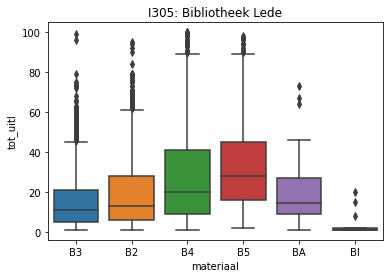

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  5791.000000    5791.000000  5791.000000         I305  Bibliotheek Lede
mean     20.270592    2018.760145    11.659817         I305  Bibliotheek Lede
std      19.156671       2.919408     5.021505         I305  Bibliotheek Lede
min       1.000000    2003.000000     0.000000         I305  Bibliotheek Lede
25%       6.000000    2018.000000     8.000000         I305  Bibliotheek Lede
50%      14.000000    2019.000000    11.000000         I305  Bibliotheek Lede
75%      29.000000    2021.000000    16.000000         I305  Bibliotheek Lede
max     100.000000    2022.000000    22.000000         I305  Bibliotheek Lede

____________________________________________________________
Bibliotheek Ninove


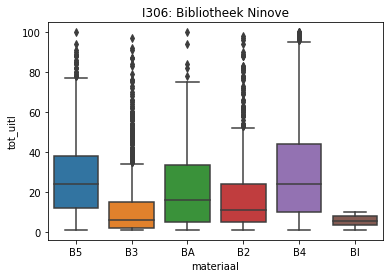

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8165.000000    8165.000000  8165.000000         I306   
mean     23.365830    2017.453031    12.545132         I306   
std      21.054054       5.418421     6.196151         I306   
min       1.000000    1993.000000     0.000000         I306   
25%       6.000000    2015.000000     8.000000         I306   
50%      17.000000    2020.000000    12.000000         I306   
75%      35.000000    2021.000000    17.000000         I306   
max     100.000000    2022.000000    29.000000         I306   

              bibliotheek  
count  Bibliotheek Ninove  
mean   Bibliotheek Ninove  
std    Bibliotheek Ninove  
min    Bibliotheek Ninove  
25%    Bibliotheek Ninove  
50%    Bibliotheek Ninove  
75%    Bibliotheek Ninove  
max    Bibliotheek Ninove

____________________________________________________________
Bibliotheek Aalter


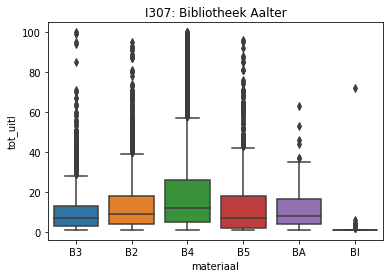

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  10323.000000   10323.000000  10323.000000         I307   
mean      15.263780    2017.490071     14.091543         I307   
std       17.193607       3.120951      5.714469         I307   
min        1.000000    1999.000000      0.000000         I307   
25%        4.000000    2016.000000     10.000000         I307   
50%        9.000000    2018.000000     15.000000         I307   
75%       20.000000    2020.000000     19.000000         I307   
max      100.000000    2022.000000     28.000000         I307   

              bibliotheek  
count  Bibliotheek Aalter  
mean   Bibliotheek Aalter  
std    Bibliotheek Aalter  
min    Bibliotheek Aalter  
25%    Bibliotheek Aalter  
50%    Bibliotheek Aalter  
75%    Bibliotheek Aalter  
max    Bibliotheek Aalter

____________________________________________________________
Bibliotheek Assenede


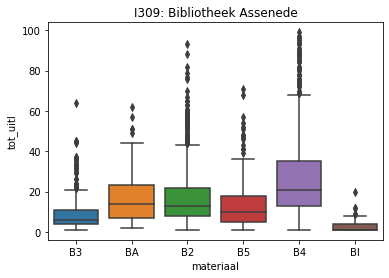

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3366.000000    3366.000000  3366.000000         I309   
mean     17.048723    2018.468212    13.401664         I309   
std      15.500429       2.678077     5.926518         I309   
min       1.000000    2008.000000     0.000000         I309   
25%       6.000000    2017.000000     9.000000         I309   
50%      12.000000    2019.000000    13.000000         I309   
75%      23.000000    2021.000000    19.000000         I309   
max      99.000000    2022.000000    24.000000         I309   

                bibliotheek  
count  Bibliotheek Assenede  
mean   Bibliotheek Assenede  
std    Bibliotheek Assenede  
min    Bibliotheek Assenede  
25%    Bibliotheek Assenede  
50%    Bibliotheek Assenede  
75%    Bibliotheek Assenede  
max    Bibliotheek Assenede

____________________________________________________________
Bibliotheek Eeklo


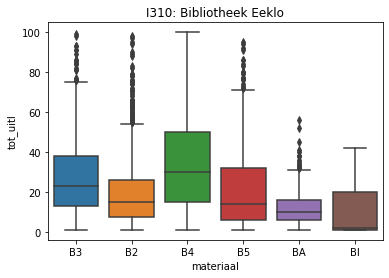

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  5513.000000    5513.000000  5513.000000         I310  Bibliotheek Eeklo
mean     27.445311    2019.028297    12.244150         I310  Bibliotheek Eeklo
std      21.932621       2.010837     5.787783         I310  Bibliotheek Eeklo
min       1.000000    2002.000000     0.000000         I310  Bibliotheek Eeklo
25%      10.000000    2018.000000     8.000000         I310  Bibliotheek Eeklo
50%      22.000000    2019.000000    12.000000         I310  Bibliotheek Eeklo
75%      40.000000    2021.000000    16.000000         I310  Bibliotheek Eeklo
max     100.000000    2022.000000    29.000000         I310  Bibliotheek Eeklo

____________________________________________________________
Bibliotheek Evergem


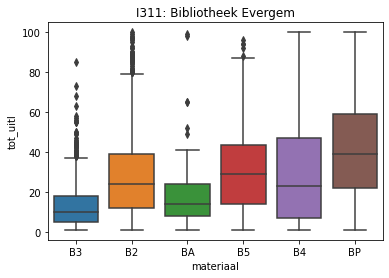

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5213.000000    5213.000000  5213.000000         I311   
mean     26.662958    2018.786495    13.056973         I311   
std      21.547173       3.612552     6.103012         I311   
min       1.000000    1996.000000     0.000000         I311   
25%       9.000000    2018.000000     9.000000         I311   
50%      22.000000    2020.000000    13.000000         I311   
75%      39.000000    2021.000000    17.000000         I311   
max     100.000000    2022.000000    27.000000         I311   

               bibliotheek  
count  Bibliotheek Evergem  
mean   Bibliotheek Evergem  
std    Bibliotheek Evergem  
min    Bibliotheek Evergem  
25%    Bibliotheek Evergem  
50%    Bibliotheek Evergem  
75%    Bibliotheek Evergem  
max    Bibliotheek Evergem

____________________________________________________________
Bibliotheek Kaprijke


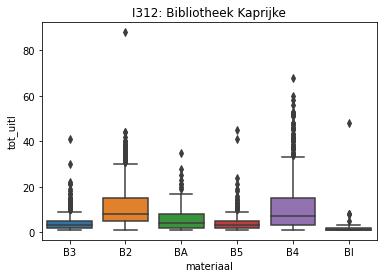

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3326.000000    3326.000000  3326.000000         I312   
mean      7.411606    2016.279916    14.671678         I312   
std       8.413228       3.547588     5.902350         I312   
min       1.000000    2008.000000     0.000000         I312   
25%       2.000000    2014.000000    11.000000         I312   
50%       4.000000    2016.000000    16.000000         I312   
75%       9.000000    2019.000000    19.000000         I312   
max      88.000000    2022.000000    24.000000         I312   

                bibliotheek  
count  Bibliotheek Kaprijke  
mean   Bibliotheek Kaprijke  
std    Bibliotheek Kaprijke  
min    Bibliotheek Kaprijke  
25%    Bibliotheek Kaprijke  
50%    Bibliotheek Kaprijke  
75%    Bibliotheek Kaprijke  
max    Bibliotheek Kaprijke

____________________________________________________________
Bibliotheek Lievegem


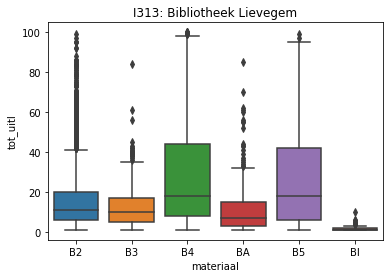

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7758.000000    7758.000000  7758.000000         I313   
mean     19.301624    2017.029131    13.914927         I313   
std      20.063089       3.110434     6.390638         I313   
min       1.000000    1998.000000     0.000000         I313   
25%       5.000000    2015.000000    10.000000         I313   
50%      12.000000    2017.000000    13.000000         I313   
75%      25.000000    2019.000000    18.000000         I313   
max     100.000000    2022.000000    29.000000         I313   

                bibliotheek  
count  Bibliotheek Lievegem  
mean   Bibliotheek Lievegem  
std    Bibliotheek Lievegem  
min    Bibliotheek Lievegem  
25%    Bibliotheek Lievegem  
50%    Bibliotheek Lievegem  
75%    Bibliotheek Lievegem  
max    Bibliotheek Lievegem

____________________________________________________________
Bibliotheek Maldegem


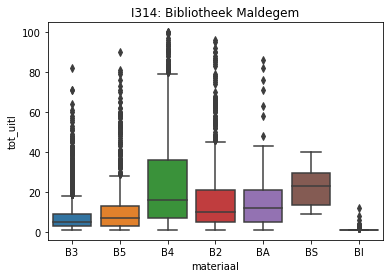

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6989.000000    6989.000000  6987.000000         I314   
mean     13.166118    2017.447131    13.991842         I314   
std      16.258009       2.857013     7.462422         I314   
min       1.000000    2008.000000     0.000000         I314   
25%       3.000000    2016.000000     8.000000         I314   
50%       7.000000    2017.000000    13.000000         I314   
75%      15.000000    2020.000000    21.000000         I314   
max     100.000000    2022.000000    27.000000         I314   

                bibliotheek  
count  Bibliotheek Maldegem  
mean   Bibliotheek Maldegem  
std    Bibliotheek Maldegem  
min    Bibliotheek Maldegem  
25%    Bibliotheek Maldegem  
50%    Bibliotheek Maldegem  
75%    Bibliotheek Maldegem  
max    Bibliotheek Maldegem

____________________________________________________________
Bibliotheek Sint-Laureins


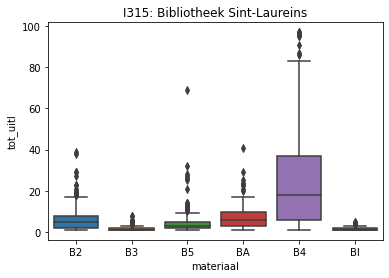

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1713.000000    1713.000000  1713.000000         I315   
mean     12.287799    2016.282545    13.617046         I315   
std      17.026215       4.486301     7.852048         I315   
min       1.000000    2006.000000     0.000000         I315   
25%       2.000000    2013.000000     8.000000         I315   
50%       5.000000    2016.000000    16.000000         I315   
75%      14.000000    2021.000000    20.000000         I315   
max      97.000000    2022.000000    24.000000         I315   

                     bibliotheek  
count  Bibliotheek Sint-Laureins  
mean   Bibliotheek Sint-Laureins  
std    Bibliotheek Sint-Laureins  
min    Bibliotheek Sint-Laureins  
25%    Bibliotheek Sint-Laureins  
50%    Bibliotheek Sint-Laureins  
75%    Bibliotheek Sint-Laureins  
max    Bibliotheek Sint-Laureins

____________________________________________________________
Bibliotheek Wachtebeke


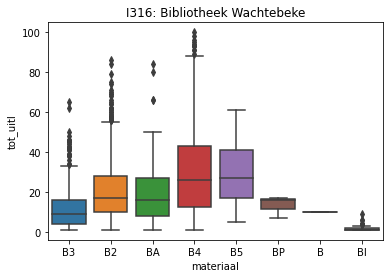

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3206.000000    3206.000000  3206.000000         I316   
mean     20.142233    2018.392077    10.510605         I316   
std      17.597290       4.227322     5.568945         I316   
min       1.000000    1999.000000     0.000000         I316   
25%       7.000000    2017.000000     8.000000         I316   
50%      15.000000    2020.000000     9.000000         I316   
75%      28.000000    2021.000000    13.000000         I316   
max     100.000000    2022.000000    27.000000         I316   

                  bibliotheek  
count  Bibliotheek Wachtebeke  
mean   Bibliotheek Wachtebeke  
std    Bibliotheek Wachtebeke  
min    Bibliotheek Wachtebeke  
25%    Bibliotheek Wachtebeke  
50%    Bibliotheek Wachtebeke  
75%    Bibliotheek Wachtebeke  
max    Bibliotheek Wachtebeke

____________________________________________________________
Bibliotheek Zelzate


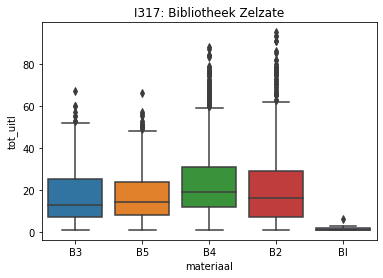

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3145.000000    3145.000000  3145.000000         I317   
mean     20.943720    2018.199682    12.532909         I317   
std      16.400027       3.994533     5.440660         I317   
min       1.000000    1999.000000     0.000000         I317   
25%       9.000000    2017.000000     9.000000         I317   
50%      17.000000    2020.000000    12.000000         I317   
75%      29.000000    2021.000000    16.000000         I317   
max      95.000000    2022.000000    26.000000         I317   

               bibliotheek  
count  Bibliotheek Zelzate  
mean   Bibliotheek Zelzate  
std    Bibliotheek Zelzate  
min    Bibliotheek Zelzate  
25%    Bibliotheek Zelzate  
50%    Bibliotheek Zelzate  
75%    Bibliotheek Zelzate  
max    Bibliotheek Zelzate

____________________________________________________________
Bibliotheek Berlare


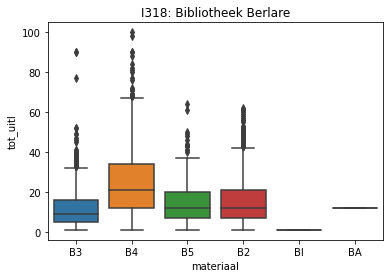

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3064.000000    3064.000000  3064.000000         I318   
mean     16.796997    2019.080940     9.789491         I318   
std      14.193175       2.192494     4.640072         I318   
min       1.000000    2009.000000     0.000000         I318   
25%       7.000000    2018.000000     7.000000         I318   
50%      13.000000    2020.000000     9.000000         I318   
75%      23.000000    2021.000000    11.000000         I318   
max     100.000000    2022.000000    26.000000         I318   

               bibliotheek  
count  Bibliotheek Berlare  
mean   Bibliotheek Berlare  
std    Bibliotheek Berlare  
min    Bibliotheek Berlare  
25%    Bibliotheek Berlare  
50%    Bibliotheek Berlare  
75%    Bibliotheek Berlare  
max    Bibliotheek Berlare

____________________________________________________________
Bibliotheek Buggenhout


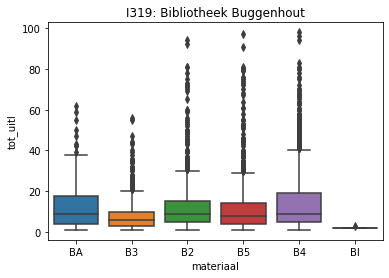

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4527.000000    4527.000000  4527.000000         I319   
mean     12.022090    2016.974155    13.865474         I319   
std      12.680476       2.511660     5.468163         I319   
min       1.000000    2007.000000     0.000000         I319   
25%       4.000000    2016.000000    10.000000         I319   
50%       8.000000    2017.000000    15.000000         I319   
75%      14.000000    2018.000000    18.000000         I319   
max      98.000000    2022.000000    23.000000         I319   

                  bibliotheek  
count  Bibliotheek Buggenhout  
mean   Bibliotheek Buggenhout  
std    Bibliotheek Buggenhout  
min    Bibliotheek Buggenhout  
25%    Bibliotheek Buggenhout  
50%    Bibliotheek Buggenhout  
75%    Bibliotheek Buggenhout  
max    Bibliotheek Buggenhout

____________________________________________________________
Bibliotheek Dendermonde


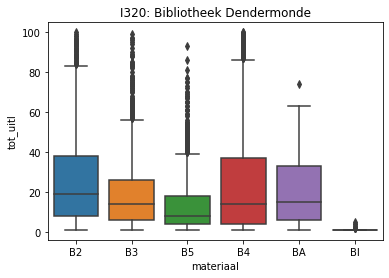

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9347.000000    9347.000000  9347.000000         I320   
mean     21.536322    2016.510966    14.176313         I320   
std      21.365013       4.771716     6.934574         I320   
min       1.000000    1996.000000     0.000000         I320   
25%       5.000000    2013.000000     9.000000         I320   
50%      14.000000    2017.000000    14.000000         I320   
75%      32.000000    2021.000000    20.000000         I320   
max     100.000000    2022.000000    29.000000         I320   

                   bibliotheek  
count  Bibliotheek Dendermonde  
mean   Bibliotheek Dendermonde  
std    Bibliotheek Dendermonde  
min    Bibliotheek Dendermonde  
25%    Bibliotheek Dendermonde  
50%    Bibliotheek Dendermonde  
75%    Bibliotheek Dendermonde  
max    Bibliotheek Dendermonde

____________________________________________________________
Bibliotheek Hamme


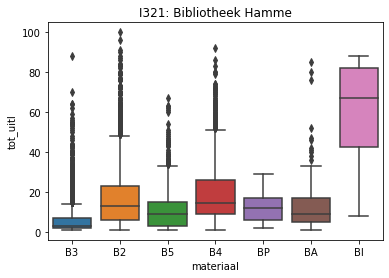

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  12132.000000   12132.000000  12132.000000         I321   
mean      13.053577    2017.423014     15.658836         I321   
std       13.097087       3.455084      6.691002         I321   
min        1.000000    2008.000000      0.000000         I321   
25%        3.000000    2015.000000     10.000000         I321   
50%        9.000000    2018.000000     15.000000         I321   
75%       18.000000    2020.000000     22.000000         I321   
max      100.000000    2022.000000     29.000000         I321   

             bibliotheek  
count  Bibliotheek Hamme  
mean   Bibliotheek Hamme  
std    Bibliotheek Hamme  
min    Bibliotheek Hamme  
25%    Bibliotheek Hamme  
50%    Bibliotheek Hamme  
75%    Bibliotheek Hamme  
max    Bibliotheek Hamme

____________________________________________________________
Bibliotheek Laarne


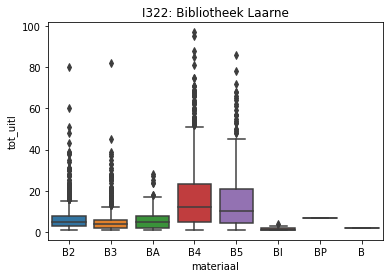

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4826.000000    4826.000000  4826.000000         I322   
mean     10.678409    2017.377124    13.348736         I322   
std      11.967477       2.928001     5.455768         I322   
min       1.000000    2009.000000     0.000000         I322   
25%       3.000000    2015.250000    10.000000         I322   
50%       6.000000    2018.000000    13.000000         I322   
75%      13.000000    2020.000000    18.000000         I322   
max      97.000000    2022.000000    25.000000         I322   

              bibliotheek  
count  Bibliotheek Laarne  
mean   Bibliotheek Laarne  
std    Bibliotheek Laarne  
min    Bibliotheek Laarne  
25%    Bibliotheek Laarne  
50%    Bibliotheek Laarne  
75%    Bibliotheek Laarne  
max    Bibliotheek Laarne

____________________________________________________________
Bibliotheek Lebbeke


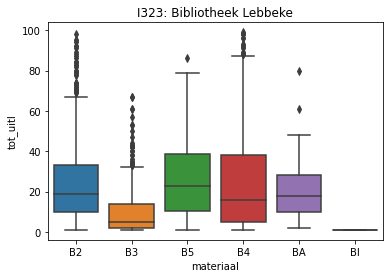

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2955.000000    2955.000000  2955.000000         I323   
mean     21.503553    2018.700169    12.844670         I323   
std      19.932067       3.293083     6.195301         I323   
min       1.000000    2007.000000     0.000000         I323   
25%       5.000000    2018.000000    10.000000         I323   
50%      16.000000    2020.000000    12.000000         I323   
75%      32.000000    2021.000000    16.000000         I323   
max      99.000000    2022.000000    29.000000         I323   

               bibliotheek  
count  Bibliotheek Lebbeke  
mean   Bibliotheek Lebbeke  
std    Bibliotheek Lebbeke  
min    Bibliotheek Lebbeke  
25%    Bibliotheek Lebbeke  
50%    Bibliotheek Lebbeke  
75%    Bibliotheek Lebbeke  
max    Bibliotheek Lebbeke

____________________________________________________________
Bibliotheek Wetteren


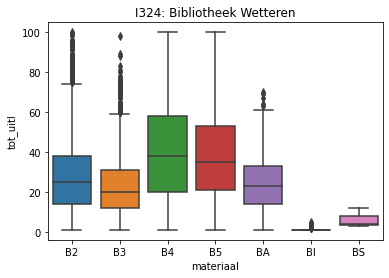

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6893.000000    6893.000000  6893.000000         I324   
mean     31.590889    2019.642391    11.133904         I324   
std      22.199742       2.354886     4.138235         I324   
min       1.000000    1994.000000     0.000000         I324   
25%      14.000000    2019.000000     9.000000         I324   
50%      27.000000    2020.000000    10.000000         I324   
75%      44.000000    2021.000000    13.000000         I324   
max     100.000000    2022.000000    28.000000         I324   

                bibliotheek  
count  Bibliotheek Wetteren  
mean   Bibliotheek Wetteren  
std    Bibliotheek Wetteren  
min    Bibliotheek Wetteren  
25%    Bibliotheek Wetteren  
50%    Bibliotheek Wetteren  
75%    Bibliotheek Wetteren  
max    Bibliotheek Wetteren

____________________________________________________________
Bibliotheek Wichelen


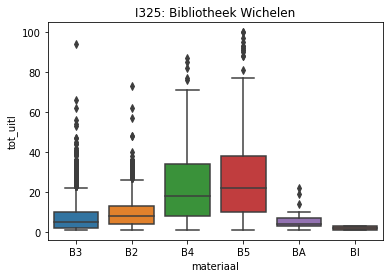

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4167.000000    4167.000000  4167.000000         I325   
mean     12.688985    2015.675786    13.896328         I325   
std      13.980225       3.685714     4.134362         I325   
min       1.000000    2004.000000     0.000000         I325   
25%       4.000000    2014.000000    11.000000         I325   
50%       8.000000    2016.000000    14.000000         I325   
75%      16.000000    2018.000000    18.000000         I325   
max     100.000000    2022.000000    21.000000         I325   

                bibliotheek  
count  Bibliotheek Wichelen  
mean   Bibliotheek Wichelen  
std    Bibliotheek Wichelen  
min    Bibliotheek Wichelen  
25%    Bibliotheek Wichelen  
50%    Bibliotheek Wichelen  
75%    Bibliotheek Wichelen  
max    Bibliotheek Wichelen

____________________________________________________________
Bibliotheek Zele


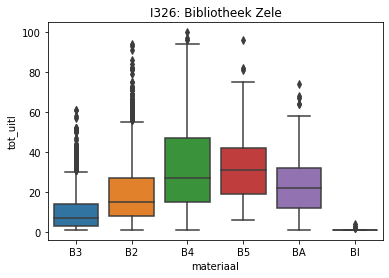

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  4618.000000    4618.000000  4618.000000         I326  Bibliotheek Zele
mean     19.800563    2018.819835    11.970767         I326  Bibliotheek Zele
std      18.112273       3.078009     5.922996         I326  Bibliotheek Zele
min       1.000000    2006.000000     0.000000         I326  Bibliotheek Zele
25%       6.000000    2018.000000     7.000000         I326  Bibliotheek Zele
50%      14.000000    2020.000000    11.000000         I326  Bibliotheek Zele
75%      28.000000    2021.000000    16.000000         I326  Bibliotheek Zele
max     100.000000    2022.000000    27.000000         I326  Bibliotheek Zele

____________________________________________________________
Bibliotheek Beveren


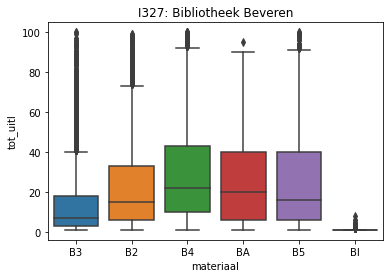

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  15898.000000   15898.000000  15898.000000         I327   
mean      18.874450    2016.640081     13.216128         I327   
std       20.614345       4.659593      6.085721         I327   
min        1.000000    1994.000000      0.000000         I327   
25%        4.000000    2014.000000      9.000000         I327   
50%       11.000000    2018.000000     13.000000         I327   
75%       27.000000    2020.000000     17.000000         I327   
max      100.000000    2022.000000     29.000000         I327   

               bibliotheek  
count  Bibliotheek Beveren  
mean   Bibliotheek Beveren  
std    Bibliotheek Beveren  
min    Bibliotheek Beveren  
25%    Bibliotheek Beveren  
50%    Bibliotheek Beveren  
75%    Bibliotheek Beveren  
max    Bibliotheek Beveren

____________________________________________________________
Bibliotheek Kruibeke


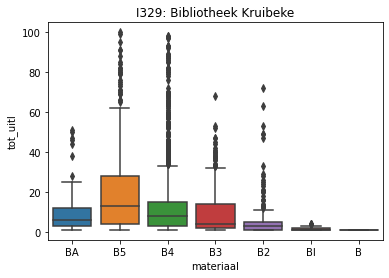

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3094.000000    3094.000000  3094.000000         I329   
mean     12.419522    2017.763736    15.653846         I329   
std      15.827365       3.457202     4.819479         I329   
min       1.000000    2005.000000     0.000000         I329   
25%       2.000000    2016.000000    13.000000         I329   
50%       7.000000    2019.000000    17.000000         I329   
75%      15.000000    2020.000000    19.000000         I329   
max     100.000000    2022.000000    22.000000         I329   

                bibliotheek  
count  Bibliotheek Kruibeke  
mean   Bibliotheek Kruibeke  
std    Bibliotheek Kruibeke  
min    Bibliotheek Kruibeke  
25%    Bibliotheek Kruibeke  
50%    Bibliotheek Kruibeke  
75%    Bibliotheek Kruibeke  
max    Bibliotheek Kruibeke

____________________________________________________________
Bibliotheek Lokeren


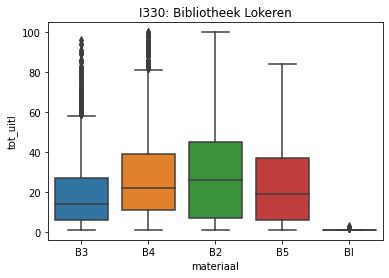

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9561.000000    9561.000000  9561.000000         I330   
mean     25.322247    2017.837360    12.278109         I330   
std      21.365347       3.986852     5.424216         I330   
min       1.000000    1995.000000     0.000000         I330   
25%       8.000000    2015.000000     9.000000         I330   
50%      20.000000    2019.000000    12.000000         I330   
75%      38.000000    2021.000000    16.000000         I330   
max     100.000000    2022.000000    44.000000         I330   

               bibliotheek  
count  Bibliotheek Lokeren  
mean   Bibliotheek Lokeren  
std    Bibliotheek Lokeren  
min    Bibliotheek Lokeren  
25%    Bibliotheek Lokeren  
50%    Bibliotheek Lokeren  
75%    Bibliotheek Lokeren  
max    Bibliotheek Lokeren

____________________________________________________________
Bibliotheek Moerbeke-Waas


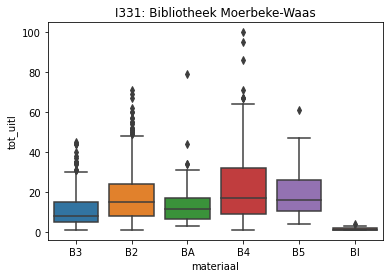

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1445.000000    1445.000000  1445.000000         I331   
mean     15.768858    2018.801384    11.266436         I331   
std      13.166755       2.750472     3.592122         I331   
min       1.000000    2007.000000     0.000000         I331   
25%       6.000000    2018.000000    10.000000         I331   
50%      12.000000    2020.000000    11.000000         I331   
75%      21.000000    2021.000000    14.000000         I331   
max     100.000000    2022.000000    19.000000         I331   

                     bibliotheek  
count  Bibliotheek Moerbeke-Waas  
mean   Bibliotheek Moerbeke-Waas  
std    Bibliotheek Moerbeke-Waas  
min    Bibliotheek Moerbeke-Waas  
25%    Bibliotheek Moerbeke-Waas  
50%    Bibliotheek Moerbeke-Waas  
75%    Bibliotheek Moerbeke-Waas  
max    Bibliotheek Moerbeke-Waas

____________________________________________________________
Bibliotheek Sint-Gillis-Waas


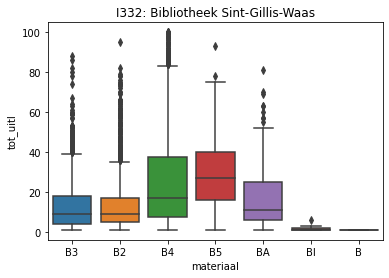

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5493.000000    5493.000000  5493.000000         I332   
mean     17.521755    2016.730566    13.250683         I332   
std      18.313083       3.752669     6.296131         I332   
min       1.000000    2001.000000     0.000000         I332   
25%       5.000000    2014.000000     8.000000         I332   
50%      11.000000    2018.000000    13.000000         I332   
75%      23.000000    2020.000000    18.000000         I332   
max     100.000000    2022.000000    27.000000         I332   

                        bibliotheek  
count  Bibliotheek Sint-Gillis-Waas  
mean   Bibliotheek Sint-Gillis-Waas  
std    Bibliotheek Sint-Gillis-Waas  
min    Bibliotheek Sint-Gillis-Waas  
25%    Bibliotheek Sint-Gillis-Waas  
50%    Bibliotheek Sint-Gillis-Waas  
75%    Bibliotheek Sint-Gillis-Waas  
max    Bibliotheek Sint-Gillis-Waas

____________________________________________________________
Bibliotheek Sint-Niklaas


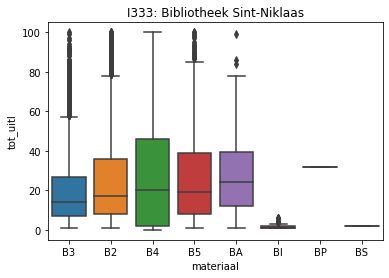

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  22106.000000   22106.000000  22106.000000         I333   
mean      23.853524    2018.583145     12.291912         I333   
std       22.737111       4.032113      6.349738         I333   
min        0.000000    1994.000000      0.000000         I333   
25%        6.000000    2018.000000      8.000000         I333   
50%       16.000000    2020.000000     11.000000         I333   
75%       36.000000    2021.000000     16.000000         I333   
max      100.000000    2022.000000     28.000000         I333   

                    bibliotheek  
count  Bibliotheek Sint-Niklaas  
mean   Bibliotheek Sint-Niklaas  
std    Bibliotheek Sint-Niklaas  
min    Bibliotheek Sint-Niklaas  
25%    Bibliotheek Sint-Niklaas  
50%    Bibliotheek Sint-Niklaas  
75%    Bibliotheek Sint-Niklaas  
max    Bibliotheek Sint-Niklaas

____________________________________________________________
Bibliotheek Stekene


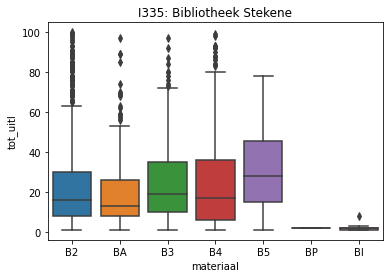

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3257.000000    3257.000000  3257.000000         I335   
mean     22.020264    2018.212465    11.098250         I335   
std      19.592208       2.516101     6.247716         I335   
min       1.000000    1998.000000     0.000000         I335   
25%       7.000000    2017.000000     7.000000         I335   
50%      16.000000    2018.000000    10.000000         I335   
75%      32.000000    2020.000000    15.000000         I335   
max     100.000000    2022.000000    29.000000         I335   

               bibliotheek  
count  Bibliotheek Stekene  
mean   Bibliotheek Stekene  
std    Bibliotheek Stekene  
min    Bibliotheek Stekene  
25%    Bibliotheek Stekene  
50%    Bibliotheek Stekene  
75%    Bibliotheek Stekene  
max    Bibliotheek Stekene

____________________________________________________________
Bibliotheek Temse


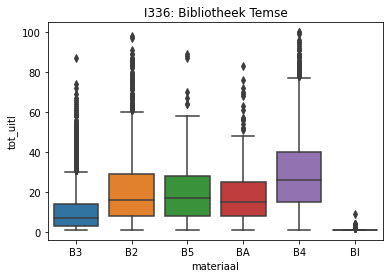

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  9768.000000    9768.000000  9768.000000         I336  Bibliotheek Temse
mean     17.643837    2016.468878    15.559173         I336  Bibliotheek Temse
std      16.562264       5.110257     5.709691         I336  Bibliotheek Temse
min       1.000000    2000.000000     0.000000         I336  Bibliotheek Temse
25%       5.000000    2015.000000    11.000000         I336  Bibliotheek Temse
50%      12.000000    2018.000000    16.000000         I336  Bibliotheek Temse
75%      25.000000    2020.000000    21.000000         I336  Bibliotheek Temse
max     100.000000    2022.000000    24.000000         I336  Bibliotheek Temse

____________________________________________________________
Bibliotheek Waasmunster


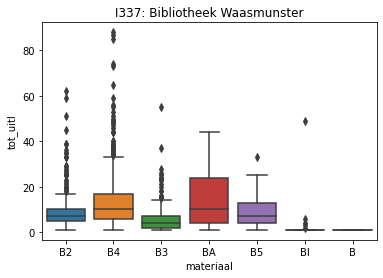

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1133.000000    1133.000000  1133.000000         I337   
mean     10.733451    2017.099735    11.892321         I337   
std      11.198557       2.811468     6.231323         I337   
min       1.000000    2007.000000     0.000000         I337   
25%       4.000000    2015.000000     8.000000         I337   
50%       7.000000    2017.000000    11.000000         I337   
75%      13.000000    2019.000000    16.000000         I337   
max      88.000000    2022.000000    41.000000         I337   

                   bibliotheek  
count  Bibliotheek Waasmunster  
mean   Bibliotheek Waasmunster  
std    Bibliotheek Waasmunster  
min    Bibliotheek Waasmunster  
25%    Bibliotheek Waasmunster  
50%    Bibliotheek Waasmunster  
75%    Bibliotheek Waasmunster  
max    Bibliotheek Waasmunster

____________________________________________________________
Bibliotheek De Pinte


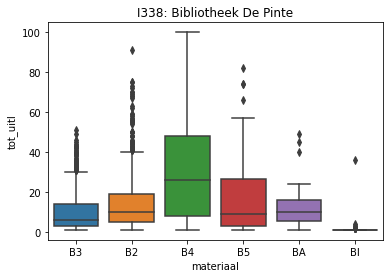

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3514.000000    3514.000000  3514.000000         I338   
mean     15.065168    2017.766079    13.579397         I338   
std      16.625170       3.239457     6.237868         I338   
min       1.000000    2009.000000     0.000000         I338   
25%       3.000000    2016.000000    10.000000         I338   
50%       9.000000    2019.000000    13.000000         I338   
75%      21.000000    2020.000000    17.000000         I338   
max     100.000000    2022.000000    27.000000         I338   

                bibliotheek  
count  Bibliotheek De Pinte  
mean   Bibliotheek De Pinte  
std    Bibliotheek De Pinte  
min    Bibliotheek De Pinte  
25%    Bibliotheek De Pinte  
50%    Bibliotheek De Pinte  
75%    Bibliotheek De Pinte  
max    Bibliotheek De Pinte

____________________________________________________________
Bibliotheek Gavere


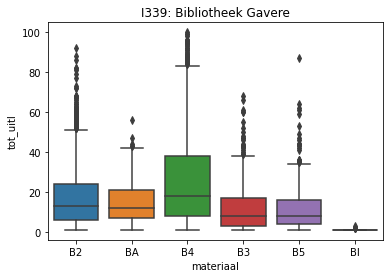

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3631.000000    3631.000000  3631.000000         I339   
mean     19.219499    2018.485541    16.146516         I339   
std      18.840464       2.733074     7.039754         I339   
min       1.000000    2007.000000     0.000000         I339   
25%       6.000000    2017.000000    11.000000         I339   
50%      13.000000    2019.000000    17.000000         I339   
75%      27.000000    2021.000000    22.000000         I339   
max     100.000000    2022.000000    29.000000         I339   

              bibliotheek  
count  Bibliotheek Gavere  
mean   Bibliotheek Gavere  
std    Bibliotheek Gavere  
min    Bibliotheek Gavere  
25%    Bibliotheek Gavere  
50%    Bibliotheek Gavere  
75%    Bibliotheek Gavere  
max    Bibliotheek Gavere

____________________________________________________________
Bibliotheek Kruisem


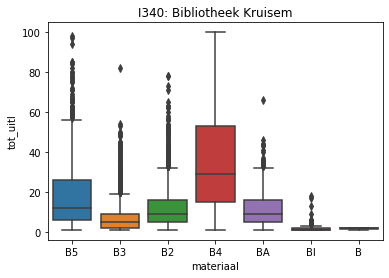

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7428.000000    7428.000000  7428.000000         I340   
mean     16.330372    2017.343834    13.578352         I340   
std      18.248857       3.230890     5.041706         I340   
min       1.000000    2005.000000     0.000000         I340   
25%       4.000000    2015.000000    10.000000         I340   
50%       9.000000    2018.000000    14.000000         I340   
75%      21.000000    2020.000000    17.000000         I340   
max     100.000000    2022.000000    28.000000         I340   

               bibliotheek  
count  Bibliotheek Kruisem  
mean   Bibliotheek Kruisem  
std    Bibliotheek Kruisem  
min    Bibliotheek Kruisem  
25%    Bibliotheek Kruisem  
50%    Bibliotheek Kruisem  
75%    Bibliotheek Kruisem  
max    Bibliotheek Kruisem

____________________________________________________________
Bibliotheek Nazareth


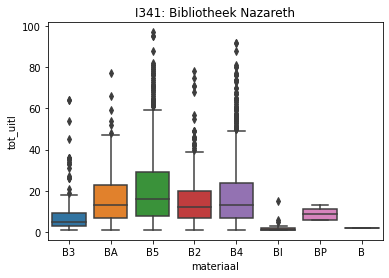

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3037.000000    3037.000000  3037.000000         I341   
mean     15.498518    2018.516299    12.683240         I341   
std      15.521493       2.637425     7.290176         I341   
min       1.000000    2008.000000     0.000000         I341   
25%       5.000000    2017.000000     7.000000         I341   
50%      11.000000    2019.000000    12.000000         I341   
75%      21.000000    2021.000000    19.000000         I341   
max      97.000000    2022.000000    27.000000         I341   

                bibliotheek  
count  Bibliotheek Nazareth  
mean   Bibliotheek Nazareth  
std    Bibliotheek Nazareth  
min    Bibliotheek Nazareth  
25%    Bibliotheek Nazareth  
50%    Bibliotheek Nazareth  
75%    Bibliotheek Nazareth  
max    Bibliotheek Nazareth

____________________________________________________________
Bibliotheek Sint-Martens-Latem


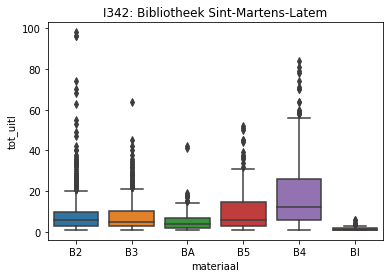

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4220.000000    4220.000000  4220.000000         I342   
mean      8.806872    2016.795972    10.459716         I342   
std       9.645796       3.283237     4.970025         I342   
min       1.000000    2007.000000     0.000000         I342   
25%       3.000000    2015.000000     7.000000         I342   
50%       6.000000    2017.000000    10.000000         I342   
75%      11.000000    2019.000000    13.000000         I342   
max      98.000000    2022.000000    22.000000         I342   

                          bibliotheek  
count  Bibliotheek Sint-Martens-Latem  
mean   Bibliotheek Sint-Martens-Latem  
std    Bibliotheek Sint-Martens-Latem  
min    Bibliotheek Sint-Martens-Latem  
25%    Bibliotheek Sint-Martens-Latem  
50%    Bibliotheek Sint-Martens-Latem  
75%    Bibliotheek Sint-Martens-Latem  
max    Bibliotheek Sint-Martens-Latem

____________________________________________________________
Bibliotheek Zulte


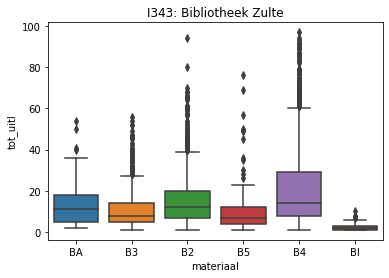

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  3041.000000    3041.000000  3041.000000         I343  Bibliotheek Zulte
mean     15.801381    2018.445906    12.312397         I343  Bibliotheek Zulte
std      16.244635       2.501010     7.500158         I343  Bibliotheek Zulte
min       1.000000    2009.000000     0.000000         I343  Bibliotheek Zulte
25%       5.000000    2017.000000     7.000000         I343  Bibliotheek Zulte
50%      10.000000    2018.000000    12.000000         I343  Bibliotheek Zulte
75%      19.000000    2021.000000    18.000000         I343  Bibliotheek Zulte
max      97.000000    2022.000000    27.000000         I343  Bibliotheek Zulte

____________________________________________________________
Bibliotheek Zwalm


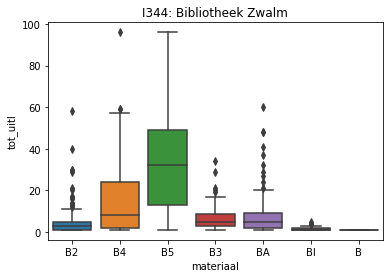

tot_uitl  ltst_jaar_uit    lft_exem instantie_id        bibliotheek
count  599.000000     599.000000  599.000000         I344  Bibliotheek Zwalm
mean     9.176962    2015.769616   12.626043         I344  Bibliotheek Zwalm
std     13.704309       4.258418    6.780139         I344  Bibliotheek Zwalm
min      1.000000    2009.000000    0.000000         I344  Bibliotheek Zwalm
25%      2.000000    2012.000000    8.000000         I344  Bibliotheek Zwalm
50%      4.000000    2015.000000   14.000000         I344  Bibliotheek Zwalm
75%     10.000000    2020.000000   19.000000         I344  Bibliotheek Zwalm
max     96.000000    2022.000000   21.000000         I344  Bibliotheek Zwalm

____________________________________________________________
Bibliotheek Deinze


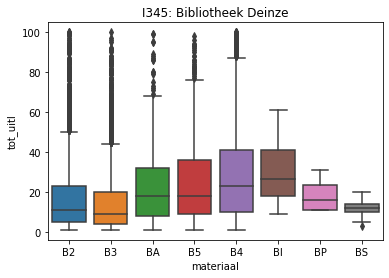

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  13888.000000   13888.000000  13880.000000         I345   
mean      18.958093    2016.437932     12.416715         I345   
std       18.853335       4.766881      6.723046         I345   
min        1.000000    1993.000000      0.000000         I345   
25%        5.000000    2015.000000      7.000000         I345   
50%       12.000000    2018.000000     11.000000         I345   
75%       26.000000    2019.000000     17.000000         I345   
max      100.000000    2022.000000     29.000000         I345   

              bibliotheek  
count  Bibliotheek Deinze  
mean   Bibliotheek Deinze  
std    Bibliotheek Deinze  
min    Bibliotheek Deinze  
25%    Bibliotheek Deinze  
50%    Bibliotheek Deinze  
75%    Bibliotheek Deinze  
max    Bibliotheek Deinze

____________________________________________________________
Bibliotheek Destelbergen


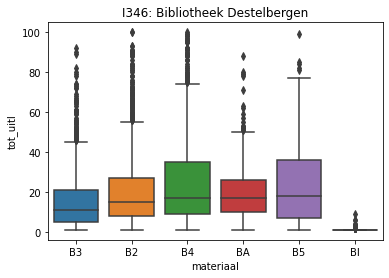

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5032.000000    5032.000000  5032.000000         I346   
mean     18.993442    2016.658386    15.439587         I346   
std      17.874531       4.573735     7.179329         I346   
min       1.000000    1996.000000     0.000000         I346   
25%       7.000000    2015.000000    11.000000         I346   
50%      13.000000    2018.000000    15.000000         I346   
75%      25.000000    2020.000000    21.000000         I346   
max     100.000000    2022.000000    29.000000         I346   

                    bibliotheek  
count  Bibliotheek Destelbergen  
mean   Bibliotheek Destelbergen  
std    Bibliotheek Destelbergen  
min    Bibliotheek Destelbergen  
25%    Bibliotheek Destelbergen  
50%    Bibliotheek Destelbergen  
75%    Bibliotheek Destelbergen  
max    Bibliotheek Destelbergen

____________________________________________________________
Bibliotheek Lochristi


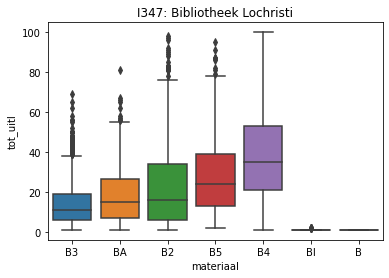

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5894.000000    5894.000000  5894.000000         I347   
mean     25.335935    2019.195792    12.891076         I347   
std      20.771424       2.476157     5.772691         I347   
min       1.000000    2008.000000     0.000000         I347   
25%       9.000000    2018.000000     9.000000         I347   
50%      20.000000    2020.000000    13.000000         I347   
75%      37.000000    2021.000000    17.000000         I347   
max     100.000000    2022.000000    26.000000         I347   

                 bibliotheek  
count  Bibliotheek Lochristi  
mean   Bibliotheek Lochristi  
std    Bibliotheek Lochristi  
min    Bibliotheek Lochristi  
25%    Bibliotheek Lochristi  
50%    Bibliotheek Lochristi  
75%    Bibliotheek Lochristi  
max    Bibliotheek Lochristi

____________________________________________________________
Bibliotheek Melle


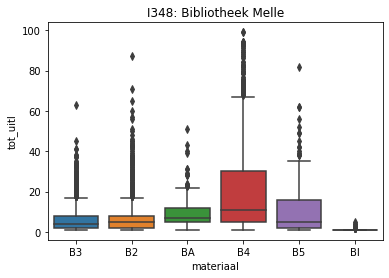

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  6566.000000    6566.000000  6566.000000         I348  Bibliotheek Melle
mean     10.005483    2014.332470    15.964514         I348  Bibliotheek Melle
std      13.515621       4.957323     5.690959         I348  Bibliotheek Melle
min       1.000000    2002.000000     0.000000         I348  Bibliotheek Melle
25%       2.000000    2011.000000    12.000000         I348  Bibliotheek Melle
50%       5.000000    2015.000000    17.000000         I348  Bibliotheek Melle
75%      11.000000    2018.000000    20.000000         I348  Bibliotheek Melle
max      99.000000    2022.000000    28.000000         I348  Bibliotheek Melle

____________________________________________________________
Bibliotheek Merelbeke


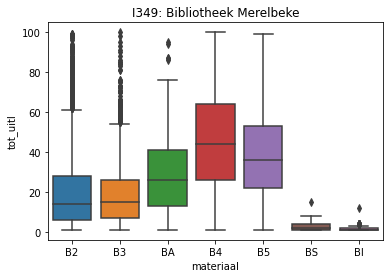

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9326.000000    9326.000000  9326.000000         I349   
mean     25.726785    2018.389449    12.274609         I349   
std      22.831402       3.563827     6.986511         I349   
min       1.000000    1997.000000     0.000000         I349   
25%       7.000000    2017.000000     7.000000         I349   
50%      19.000000    2019.000000    11.000000         I349   
75%      38.000000    2021.000000    17.000000         I349   
max     100.000000    2022.000000    27.000000         I349   

                 bibliotheek  
count  Bibliotheek Merelbeke  
mean   Bibliotheek Merelbeke  
std    Bibliotheek Merelbeke  
min    Bibliotheek Merelbeke  
25%    Bibliotheek Merelbeke  
50%    Bibliotheek Merelbeke  
75%    Bibliotheek Merelbeke  
max    Bibliotheek Merelbeke

____________________________________________________________
Bibliotheek Geraardsbergen


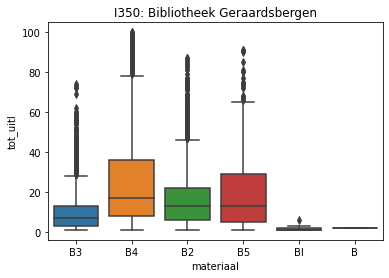

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8559.000000    8559.000000  8559.000000         I350   
mean     16.199556    2017.623905    15.109125         I350   
std      16.886722       3.421581     6.173280         I350   
min       1.000000    2007.000000     0.000000         I350   
25%       5.000000    2016.000000    11.000000         I350   
50%      11.000000    2018.000000    15.000000         I350   
75%      21.000000    2020.000000    20.000000         I350   
max     100.000000    2022.000000    26.000000         I350   

                      bibliotheek  
count  Bibliotheek Geraardsbergen  
mean   Bibliotheek Geraardsbergen  
std    Bibliotheek Geraardsbergen  
min    Bibliotheek Geraardsbergen  
25%    Bibliotheek Geraardsbergen  
50%    Bibliotheek Geraardsbergen  
75%    Bibliotheek Geraardsbergen  
max    Bibliotheek Geraardsbergen

____________________________________________________________
Bibliotheek Herzele


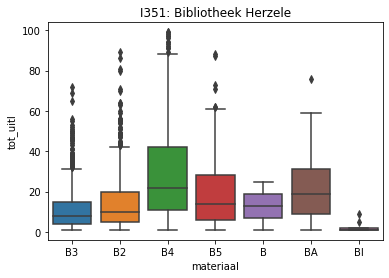

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2581.000000    2581.000000  2581.000000         I351   
mean     18.018985    2018.263076    11.955831         I351   
std      17.754092       2.712758     6.278886         I351   
min       1.000000    2005.000000     0.000000         I351   
25%       5.000000    2016.000000     8.000000         I351   
50%      12.000000    2019.000000    11.000000         I351   
75%      24.000000    2020.000000    15.000000         I351   
max      99.000000    2022.000000    30.000000         I351   

               bibliotheek  
count  Bibliotheek Herzele  
mean   Bibliotheek Herzele  
std    Bibliotheek Herzele  
min    Bibliotheek Herzele  
25%    Bibliotheek Herzele  
50%    Bibliotheek Herzele  
75%    Bibliotheek Herzele  
max    Bibliotheek Herzele

____________________________________________________________
Bibliotheek Lierde


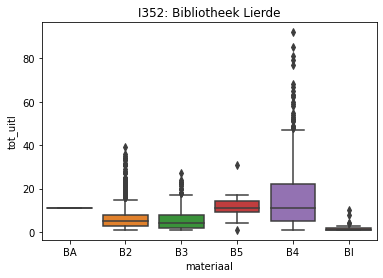

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1847.000000    1847.000000  1847.000000         I352   
mean      8.258257    2016.383324    11.982675         I352   
std       9.853417       3.546671     6.002863         I352   
min       1.000000    2008.000000     0.000000         I352   
25%       2.000000    2014.000000     7.000000         I352   
50%       5.000000    2017.000000    10.000000         I352   
75%      10.000000    2019.000000    16.000000         I352   
max      92.000000    2022.000000    27.000000         I352   

              bibliotheek  
count  Bibliotheek Lierde  
mean   Bibliotheek Lierde  
std    Bibliotheek Lierde  
min    Bibliotheek Lierde  
25%    Bibliotheek Lierde  
50%    Bibliotheek Lierde  
75%    Bibliotheek Lierde  
max    Bibliotheek Lierde

____________________________________________________________
Bibliotheek Oosterzele


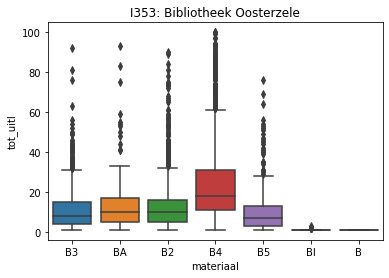

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5723.000000    5723.000000  5723.000000         I353   
mean     16.412546    2017.970295    13.919098         I353   
std      15.789029       2.567405     6.097792         I353   
min       1.000000    2007.000000     0.000000         I353   
25%       6.000000    2017.000000    10.000000         I353   
50%      12.000000    2018.000000    14.000000         I353   
75%      21.000000    2020.000000    18.000000         I353   
max     100.000000    2022.000000    29.000000         I353   

                  bibliotheek  
count  Bibliotheek Oosterzele  
mean   Bibliotheek Oosterzele  
std    Bibliotheek Oosterzele  
min    Bibliotheek Oosterzele  
25%    Bibliotheek Oosterzele  
50%    Bibliotheek Oosterzele  
75%    Bibliotheek Oosterzele  
max    Bibliotheek Oosterzele

____________________________________________________________
Bibliotheek Sint-Lievens-Houtem


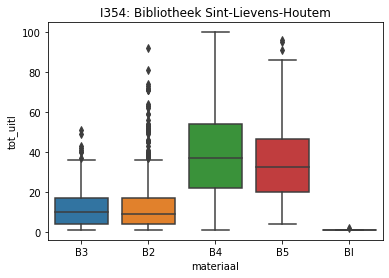

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2348.000000    2348.000000  2348.000000         I354   
mean     24.382879    2018.270869    12.468910         I354   
std      22.276938       3.266056     5.879515         I354   
min       1.000000    2005.000000     0.000000         I354   
25%       7.000000    2016.000000     9.000000         I354   
50%      17.000000    2019.000000    12.000000         I354   
75%      36.000000    2021.000000    15.000000         I354   
max     100.000000    2022.000000    30.000000         I354   

                           bibliotheek  
count  Bibliotheek Sint-Lievens-Houtem  
mean   Bibliotheek Sint-Lievens-Houtem  
std    Bibliotheek Sint-Lievens-Houtem  
min    Bibliotheek Sint-Lievens-Houtem  
25%    Bibliotheek Sint-Lievens-Houtem  
50%    Bibliotheek Sint-Lievens-Houtem  
75%    Bibliotheek Sint-Lievens-Houtem  
max    Bibliotheek Sint-Lievens-Houtem

____________________________________________________________
Bibliotheek Zottegem


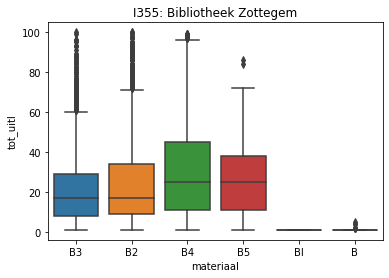

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8422.000000    8422.000000  8422.000000         I355   
mean     24.174662    2017.188910    11.466754         I355   
std      20.096295       4.772169     6.326247         I355   
min       1.000000    1994.000000     0.000000         I355   
25%       9.000000    2017.000000     7.000000         I355   
50%      19.000000    2019.000000    10.000000         I355   
75%      34.000000    2020.000000    16.000000         I355   
max     100.000000    2022.000000    28.000000         I355   

                bibliotheek  
count  Bibliotheek Zottegem  
mean   Bibliotheek Zottegem  
std    Bibliotheek Zottegem  
min    Bibliotheek Zottegem  
25%    Bibliotheek Zottegem  
50%    Bibliotheek Zottegem  
75%    Bibliotheek Zottegem  
max    Bibliotheek Zottegem

____________________________________________________________
Bibliotheek Kluisbergen


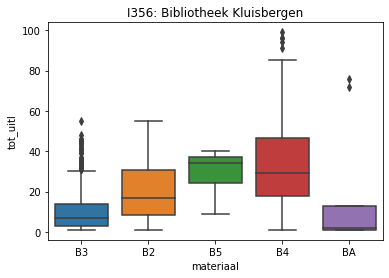

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1107.000000    1107.000000  1107.000000         I356   
mean     16.682927    2017.313460    15.982836         I356   
std      17.285490       4.476807     5.593256         I356   
min       1.000000    2001.000000     0.000000         I356   
25%       4.000000    2015.000000    12.000000         I356   
50%      11.000000    2019.000000    17.000000         I356   
75%      22.500000    2021.000000    20.000000         I356   
max      99.000000    2022.000000    24.000000         I356   

                   bibliotheek  
count  Bibliotheek Kluisbergen  
mean   Bibliotheek Kluisbergen  
std    Bibliotheek Kluisbergen  
min    Bibliotheek Kluisbergen  
25%    Bibliotheek Kluisbergen  
50%    Bibliotheek Kluisbergen  
75%    Bibliotheek Kluisbergen  
max    Bibliotheek Kluisbergen

____________________________________________________________
Bibliotheek Maarkedal


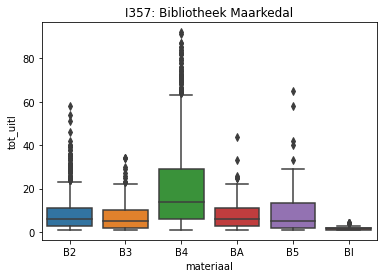

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2972.000000    2972.000000  2972.000000         I357   
mean     13.764805    2018.603970    13.131898         I357   
std      15.730123       2.995502     6.814420         I357   
min       1.000000    2007.000000     0.000000         I357   
25%       3.000000    2017.000000     8.000000         I357   
50%       8.000000    2019.000000    14.000000         I357   
75%      18.000000    2021.000000    18.000000         I357   
max      92.000000    2022.000000    27.000000         I357   

                 bibliotheek  
count  Bibliotheek Maarkedal  
mean   Bibliotheek Maarkedal  
std    Bibliotheek Maarkedal  
min    Bibliotheek Maarkedal  
25%    Bibliotheek Maarkedal  
50%    Bibliotheek Maarkedal  
75%    Bibliotheek Maarkedal  
max    Bibliotheek Maarkedal

____________________________________________________________
Bibliotheek Oudenaarde


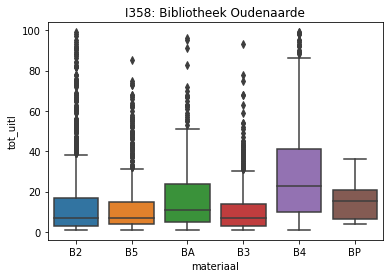

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5164.000000    5164.000000  5164.000000         I358   
mean     16.618319    2018.082494    13.959140         I358   
std      18.271876       3.120874     6.645537         I358   
min       1.000000    2008.000000     0.000000         I358   
25%       4.000000    2017.000000    10.000000         I358   
50%      10.000000    2019.000000    13.000000         I358   
75%      23.000000    2020.000000    19.000000         I358   
max      99.000000    2022.000000    28.000000         I358   

                  bibliotheek  
count  Bibliotheek Oudenaarde  
mean   Bibliotheek Oudenaarde  
std    Bibliotheek Oudenaarde  
min    Bibliotheek Oudenaarde  
25%    Bibliotheek Oudenaarde  
50%    Bibliotheek Oudenaarde  
75%    Bibliotheek Oudenaarde  
max    Bibliotheek Oudenaarde

____________________________________________________________
Bibliotheek Ronse


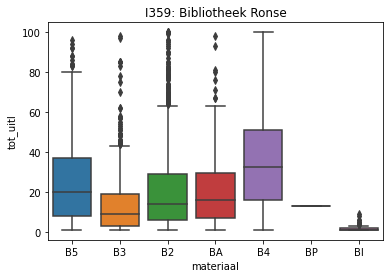

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  4096.000000    4096.000000  4096.000000         I359  Bibliotheek Ronse
mean     22.545166    2018.575439     9.729736         I359  Bibliotheek Ronse
std      21.335712       3.469690     6.100178         I359  Bibliotheek Ronse
min       1.000000    1994.000000     0.000000         I359  Bibliotheek Ronse
25%       6.000000    2017.000000     5.000000         I359  Bibliotheek Ronse
50%      16.000000    2020.000000     9.000000         I359  Bibliotheek Ronse
75%      34.000000    2021.000000    13.000000         I359  Bibliotheek Ronse
max     100.000000    2022.000000    28.000000         I359  Bibliotheek Ronse

____________________________________________________________
Bibliotheek Wortegem-Petegem


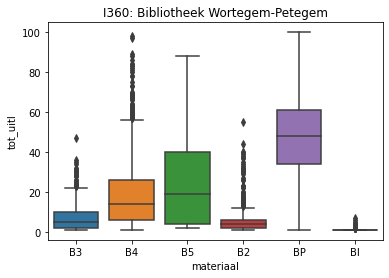

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2919.000000    2919.000000  2919.000000         I360   
mean     17.054471    2018.177801    10.958890         I360   
std      19.976480       3.331096     5.580462         I360   
min       1.000000    2007.000000     0.000000         I360   
25%       3.000000    2016.000000     7.000000         I360   
50%       8.000000    2018.000000    11.000000         I360   
75%      24.000000    2021.000000    15.000000         I360   
max     100.000000    2022.000000    23.000000         I360   

                        bibliotheek  
count  Bibliotheek Wortegem-Petegem  
mean   Bibliotheek Wortegem-Petegem  
std    Bibliotheek Wortegem-Petegem  
min    Bibliotheek Wortegem-Petegem  
25%    Bibliotheek Wortegem-Petegem  
50%    Bibliotheek Wortegem-Petegem  
75%    Bibliotheek Wortegem-Petegem  
max    Bibliotheek Wortegem-Petegem

____________________________________________________________
Bibliotheek Oostende


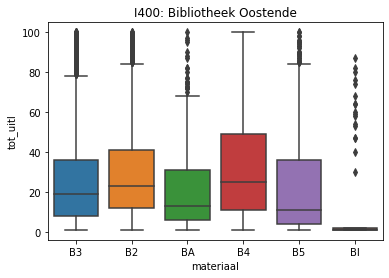

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  16830.000000   16830.000000  16830.000000         I400   
mean      27.117825    2017.256447     14.125906         I400   
std       22.414477       4.099461      6.409474         I400   
min        1.000000    2000.000000      0.000000         I400   
25%        9.000000    2016.000000      9.000000         I400   
50%       21.000000    2018.000000     14.000000         I400   
75%       39.000000    2020.000000     19.000000         I400   
max      100.000000    2022.000000     27.000000         I400   

                bibliotheek  
count  Bibliotheek Oostende  
mean   Bibliotheek Oostende  
std    Bibliotheek Oostende  
min    Bibliotheek Oostende  
25%    Bibliotheek Oostende  
50%    Bibliotheek Oostende  
75%    Bibliotheek Oostende  
max    Bibliotheek Oostende

____________________________________________________________
Bibliotheek Alveringem


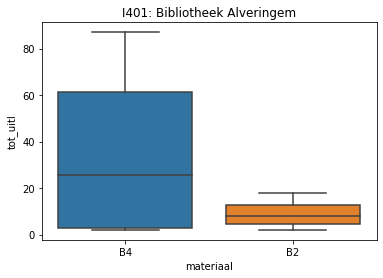

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count  28.000000      28.000000  28.000000         I401   
mean   26.571429    2018.500000  14.535714         I401   
std    28.563676       4.167778   6.551687         I401   
min     2.000000    2011.000000   1.000000         I401   
25%     3.000000    2014.750000  10.000000         I401   
50%    11.000000    2021.500000  14.500000         I401   
75%    61.000000    2022.000000  19.000000         I401   
max    87.000000    2022.000000  25.000000         I401   

                  bibliotheek  
count  Bibliotheek Alveringem  
mean   Bibliotheek Alveringem  
std    Bibliotheek Alveringem  
min    Bibliotheek Alveringem  
25%    Bibliotheek Alveringem  
50%    Bibliotheek Alveringem  
75%    Bibliotheek Alveringem  
max    Bibliotheek Alveringem

____________________________________________________________
Bibliotheek Anzegem


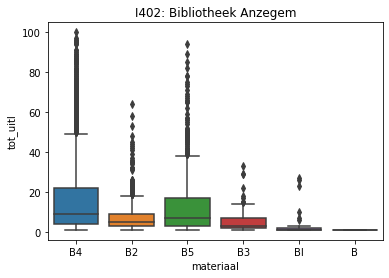

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4833.000000    4833.000000  4833.000000         I402   
mean     12.709704    2016.927788    15.957997         I402   
std      16.212346       3.837009     6.519781         I402   
min       1.000000    2007.000000     0.000000         I402   
25%       3.000000    2014.000000    12.000000         I402   
50%       7.000000    2017.000000    16.000000         I402   
75%      14.000000    2020.000000    21.000000         I402   
max     100.000000    2022.000000    27.000000         I402   

               bibliotheek  
count  Bibliotheek Anzegem  
mean   Bibliotheek Anzegem  
std    Bibliotheek Anzegem  
min    Bibliotheek Anzegem  
25%    Bibliotheek Anzegem  
50%    Bibliotheek Anzegem  
75%    Bibliotheek Anzegem  
max    Bibliotheek Anzegem

____________________________________________________________
Bibliotheek Ardooie


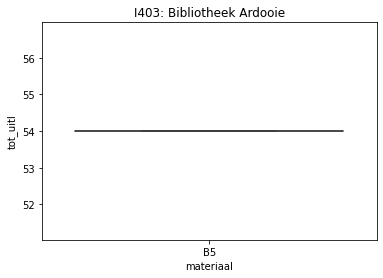

tot_uitl  ltst_jaar_uit  lft_exem instantie_id          bibliotheek
count       1.0            1.0       1.0         I403  Bibliotheek Ardooie
mean       54.0         2022.0      27.0         I403  Bibliotheek Ardooie
std         NaN            NaN       NaN         I403  Bibliotheek Ardooie
min        54.0         2022.0      27.0         I403  Bibliotheek Ardooie
25%        54.0         2022.0      27.0         I403  Bibliotheek Ardooie
50%        54.0         2022.0      27.0         I403  Bibliotheek Ardooie
75%        54.0         2022.0      27.0         I403  Bibliotheek Ardooie
max        54.0         2022.0      27.0         I403  Bibliotheek Ardooie

____________________________________________________________
Bibliotheek Avelgem


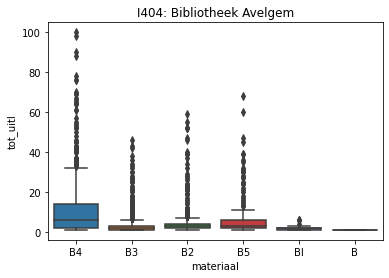

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4046.000000     4046.00000  4046.000000         I404   
mean      5.181167     2012.64780    16.304004         I404   
std       8.534004        5.35566     7.650752         I404   
min       1.000000     2006.00000     0.000000         I404   
25%       1.000000     2009.00000    13.000000         I404   
50%       2.000000     2010.00000    19.000000         I404   
75%       5.000000     2016.00000    22.000000         I404   
max     100.000000     2022.00000    24.000000         I404   

               bibliotheek  
count  Bibliotheek Avelgem  
mean   Bibliotheek Avelgem  
std    Bibliotheek Avelgem  
min    Bibliotheek Avelgem  
25%    Bibliotheek Avelgem  
50%    Bibliotheek Avelgem  
75%    Bibliotheek Avelgem  
max    Bibliotheek Avelgem

____________________________________________________________
Bibliotheek Beernem


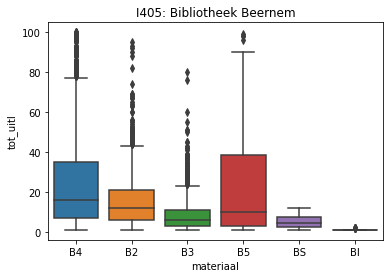

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5216.000000    5216.000000  5216.000000         I405   
mean     17.646472    2017.272239    12.788919         I405   
std      19.170958       3.535423     6.150721         I405   
min       1.000000    2007.000000     0.000000         I405   
25%       5.000000    2015.000000     9.000000         I405   
50%      11.000000    2018.000000    12.000000         I405   
75%      23.000000    2020.000000    16.000000         I405   
max     100.000000    2022.000000    29.000000         I405   

               bibliotheek  
count  Bibliotheek Beernem  
mean   Bibliotheek Beernem  
std    Bibliotheek Beernem  
min    Bibliotheek Beernem  
25%    Bibliotheek Beernem  
50%    Bibliotheek Beernem  
75%    Bibliotheek Beernem  
max    Bibliotheek Beernem

____________________________________________________________
Bibliotheek Blankenberge


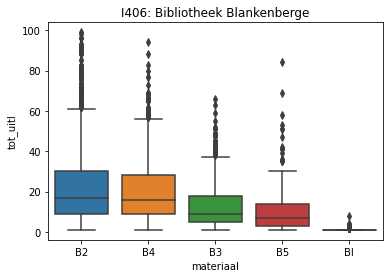

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5643.000000    5643.000000  5643.000000         I406   
mean     18.052632    2018.679780    11.131313         I406   
std      15.897388       3.129611     6.566105         I406   
min       1.000000    2006.000000     0.000000         I406   
25%       6.000000    2017.000000     7.000000         I406   
50%      14.000000    2020.000000    10.000000         I406   
75%      25.500000    2021.000000    15.000000         I406   
max      99.000000    2022.000000    29.000000         I406   

                    bibliotheek  
count  Bibliotheek Blankenberge  
mean   Bibliotheek Blankenberge  
std    Bibliotheek Blankenberge  
min    Bibliotheek Blankenberge  
25%    Bibliotheek Blankenberge  
50%    Bibliotheek Blankenberge  
75%    Bibliotheek Blankenberge  
max    Bibliotheek Blankenberge

____________________________________________________________
Bibliotheek Bredene


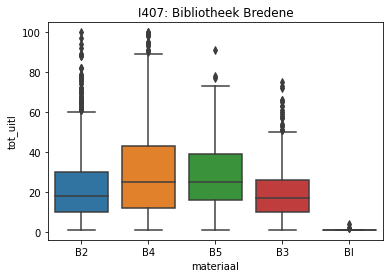

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4458.000000    4458.000000  4458.000000         I407   
mean     24.594437    2020.066622     8.537461         I407   
std      18.304144       1.499174     4.091730         I407   
min       1.000000    2014.000000     0.000000         I407   
25%      11.000000    2019.000000     6.000000         I407   
50%      20.000000    2020.000000     8.000000         I407   
75%      34.000000    2021.000000    11.000000         I407   
max     100.000000    2022.000000    22.000000         I407   

               bibliotheek  
count  Bibliotheek Bredene  
mean   Bibliotheek Bredene  
std    Bibliotheek Bredene  
min    Bibliotheek Bredene  
25%    Bibliotheek Bredene  
50%    Bibliotheek Bredene  
75%    Bibliotheek Bredene  
max    Bibliotheek Bredene

____________________________________________________________
Bibliotheek Brugge


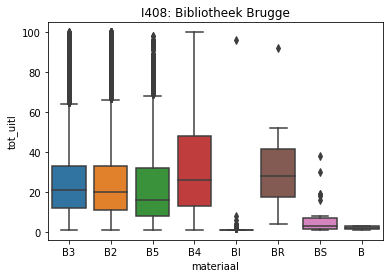

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  50115.000000   50115.000000  49316.000000         I408   
mean      26.509209    2018.584795     11.088227         I408   
std       20.289817       3.340062      5.589886         I408   
min        1.000000    1993.000000      0.000000         I408   
25%       11.000000    2017.000000      7.000000         I408   
50%       21.000000    2020.000000     10.000000         I408   
75%       36.000000    2021.000000     15.000000         I408   
max      100.000000    2022.000000     29.000000         I408   

              bibliotheek  
count  Bibliotheek Brugge  
mean   Bibliotheek Brugge  
std    Bibliotheek Brugge  
min    Bibliotheek Brugge  
25%    Bibliotheek Brugge  
50%    Bibliotheek Brugge  
75%    Bibliotheek Brugge  
max    Bibliotheek Brugge

____________________________________________________________
Bibliotheek Damme


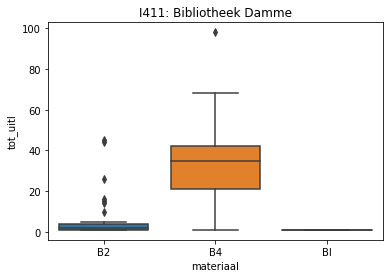

tot_uitl  ltst_jaar_uit   lft_exem instantie_id        bibliotheek
count  70.000000      70.000000  70.000000         I411  Bibliotheek Damme
mean   15.014286    2020.771429   3.857143         I411  Bibliotheek Damme
std    20.188598       1.374419   4.129378         I411  Bibliotheek Damme
min     1.000000    2016.000000   0.000000         I411  Bibliotheek Damme
25%     1.000000    2020.250000   1.000000         I411  Bibliotheek Damme
50%     3.000000    2021.000000   2.000000         I411  Bibliotheek Damme
75%    28.000000    2022.000000   5.000000         I411  Bibliotheek Damme
max    98.000000    2022.000000  16.000000         I411  Bibliotheek Damme

____________________________________________________________
Bibliotheek De Haan


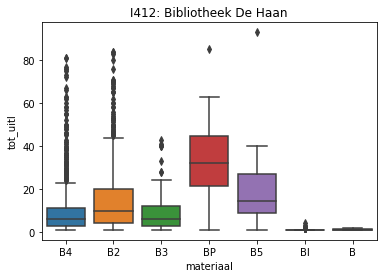

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1901.000000    1901.000000  1901.000000         I412   
mean     11.966334    2017.834298    14.024198         I412   
std      14.240895       3.425662     7.555928         I412   
min       1.000000    2006.000000     0.000000         I412   
25%       3.000000    2016.000000     9.000000         I412   
50%       7.000000    2019.000000    14.000000         I412   
75%      15.000000    2021.000000    20.000000         I412   
max      93.000000    2022.000000    28.000000         I412   

               bibliotheek  
count  Bibliotheek De Haan  
mean   Bibliotheek De Haan  
std    Bibliotheek De Haan  
min    Bibliotheek De Haan  
25%    Bibliotheek De Haan  
50%    Bibliotheek De Haan  
75%    Bibliotheek De Haan  
max    Bibliotheek De Haan

____________________________________________________________
Bibliotheek De Panne


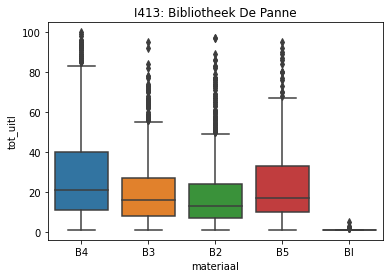

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4032.000000    4032.000000  4032.000000         I413   
mean     21.489087    2016.666667    14.983135         I413   
std      18.806919       3.099203     6.544068         I413   
min       1.000000    1997.000000     0.000000         I413   
25%       8.000000    2015.000000    11.000000         I413   
50%      16.000000    2016.000000    15.000000         I413   
75%      29.000000    2018.000000    19.000000         I413   
max     100.000000    2022.000000    29.000000         I413   

                bibliotheek  
count  Bibliotheek De Panne  
mean   Bibliotheek De Panne  
std    Bibliotheek De Panne  
min    Bibliotheek De Panne  
25%    Bibliotheek De Panne  
50%    Bibliotheek De Panne  
75%    Bibliotheek De Panne  
max    Bibliotheek De Panne

____________________________________________________________
Bibliotheek Deerlijk


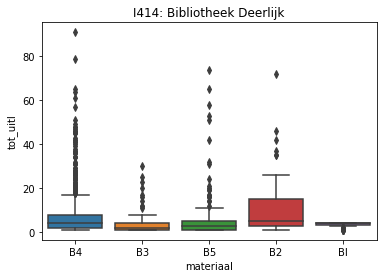

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1449.000000    1449.000000  1449.000000         I414   
mean      6.712905    2016.425811    16.345756         I414   
std       9.407905       3.689454     6.926497         I414   
min       1.000000    2010.000000     0.000000         I414   
25%       2.000000    2013.000000    13.000000         I414   
50%       4.000000    2016.000000    17.000000         I414   
75%       7.000000    2020.000000    21.000000         I414   
max      91.000000    2022.000000    28.000000         I414   

                bibliotheek  
count  Bibliotheek Deerlijk  
mean   Bibliotheek Deerlijk  
std    Bibliotheek Deerlijk  
min    Bibliotheek Deerlijk  
25%    Bibliotheek Deerlijk  
50%    Bibliotheek Deerlijk  
75%    Bibliotheek Deerlijk  
max    Bibliotheek Deerlijk

____________________________________________________________
Bibliotheek Dentergem


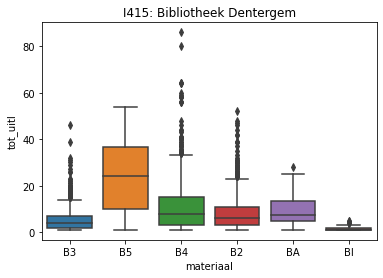

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3310.000000    3310.000000  3310.000000         I415   
mean      8.066163    2017.202417     8.786707         I415   
std       8.424455       2.462433     4.449081         I415   
min       1.000000    2007.000000     0.000000         I415   
25%       3.000000    2016.000000     5.000000         I415   
50%       5.000000    2017.000000     9.000000         I415   
75%      10.000000    2018.000000    13.000000         I415   
max      86.000000    2022.000000    15.000000         I415   

                 bibliotheek  
count  Bibliotheek Dentergem  
mean   Bibliotheek Dentergem  
std    Bibliotheek Dentergem  
min    Bibliotheek Dentergem  
25%    Bibliotheek Dentergem  
50%    Bibliotheek Dentergem  
75%    Bibliotheek Dentergem  
max    Bibliotheek Dentergem

____________________________________________________________
Bibliotheek Diksmuide


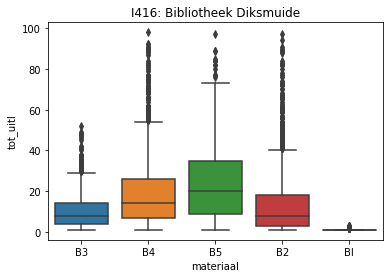

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4863.000000    4863.000000  4863.000000         I416   
mean     15.243265    2017.610940    12.047296         I416   
std      15.966151       3.410847     5.678250         I416   
min       1.000000    2007.000000     0.000000         I416   
25%       4.000000    2015.000000     9.000000         I416   
50%      10.000000    2019.000000    11.000000         I416   
75%      21.000000    2020.000000    15.000000         I416   
max      98.000000    2022.000000    28.000000         I416   

                 bibliotheek  
count  Bibliotheek Diksmuide  
mean   Bibliotheek Diksmuide  
std    Bibliotheek Diksmuide  
min    Bibliotheek Diksmuide  
25%    Bibliotheek Diksmuide  
50%    Bibliotheek Diksmuide  
75%    Bibliotheek Diksmuide  
max    Bibliotheek Diksmuide

____________________________________________________________
Bibliotheek Gistel


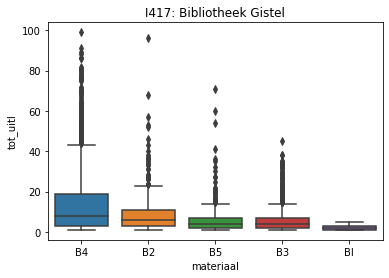

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3291.000000    3291.000000  3291.000000         I417   
mean     10.138864    2017.078699    14.147372         I417   
std      13.420457       3.579349     7.019632         I417   
min       1.000000    2009.000000     0.000000         I417   
25%       2.000000    2014.000000    10.000000         I417   
50%       5.000000    2017.000000    15.000000         I417   
75%      12.000000    2021.000000    21.000000         I417   
max      99.000000    2022.000000    24.000000         I417   

              bibliotheek  
count  Bibliotheek Gistel  
mean   Bibliotheek Gistel  
std    Bibliotheek Gistel  
min    Bibliotheek Gistel  
25%    Bibliotheek Gistel  
50%    Bibliotheek Gistel  
75%    Bibliotheek Gistel  
max    Bibliotheek Gistel

____________________________________________________________
Bibliotheek Harelbeke


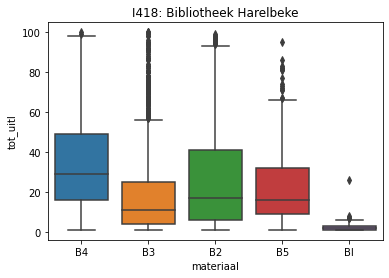

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5835.000000    5835.000000  5835.000000         I418   
mean     24.565895    2015.522365    15.756470         I418   
std      23.179345       5.586049     7.109903         I418   
min       1.000000    1993.000000     0.000000         I418   
25%       6.000000    2013.000000    11.000000         I418   
50%      17.000000    2017.000000    15.000000         I418   
75%      36.000000    2020.000000    22.000000         I418   
max     100.000000    2022.000000    29.000000         I418   

                 bibliotheek  
count  Bibliotheek Harelbeke  
mean   Bibliotheek Harelbeke  
std    Bibliotheek Harelbeke  
min    Bibliotheek Harelbeke  
25%    Bibliotheek Harelbeke  
50%    Bibliotheek Harelbeke  
75%    Bibliotheek Harelbeke  
max    Bibliotheek Harelbeke

____________________________________________________________
Bibliotheek Heuvelland


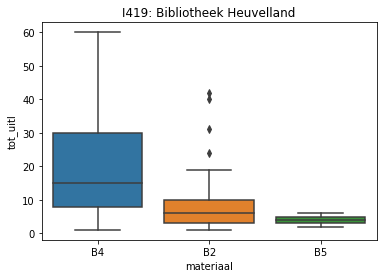

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count  76.000000      76.000000  76.000000         I419   
mean   12.776316    2017.618421  18.894737         I419   
std    13.609407       3.798130   5.691113         I419   
min     1.000000    2010.000000   3.000000         I419   
25%     3.000000    2015.000000  13.000000         I419   
50%     8.000000    2018.500000  22.000000         I419   
75%    15.250000    2021.000000  24.000000         I419   
max    60.000000    2022.000000  24.000000         I419   

                  bibliotheek  
count  Bibliotheek Heuvelland  
mean   Bibliotheek Heuvelland  
std    Bibliotheek Heuvelland  
min    Bibliotheek Heuvelland  
25%    Bibliotheek Heuvelland  
50%    Bibliotheek Heuvelland  
75%    Bibliotheek Heuvelland  
max    Bibliotheek Heuvelland

____________________________________________________________
Bibliotheek Hooglede


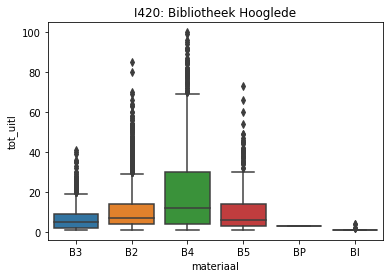

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6065.000000    6065.000000  6065.000000         I420   
mean     12.096455    2017.385161    13.876999         I420   
std      14.009718       3.281491     4.089779         I420   
min       1.000000    2008.000000     0.000000         I420   
25%       3.000000    2015.000000    12.000000         I420   
50%       7.000000    2018.000000    14.000000         I420   
75%      15.000000    2020.000000    16.000000         I420   
max     100.000000    2022.000000    24.000000         I420   

                bibliotheek  
count  Bibliotheek Hooglede  
mean   Bibliotheek Hooglede  
std    Bibliotheek Hooglede  
min    Bibliotheek Hooglede  
25%    Bibliotheek Hooglede  
50%    Bibliotheek Hooglede  
75%    Bibliotheek Hooglede  
max    Bibliotheek Hooglede

____________________________________________________________
Bibliotheek Houthulst en Lo-Reninge


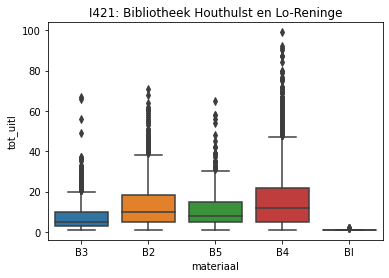

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7884.000000    7884.000000  7884.000000         I421   
mean     13.097539    2017.741755    12.989346         I421   
std      12.643072       3.284710     4.828495         I421   
min       1.000000    2006.000000     0.000000         I421   
25%       4.000000    2016.000000    10.000000         I421   
50%       9.000000    2019.000000    13.000000         I421   
75%      18.000000    2020.000000    16.000000         I421   
max      99.000000    2022.000000    24.000000         I421   

                               bibliotheek  
count  Bibliotheek Houthulst en Lo-Reninge  
mean   Bibliotheek Houthulst en Lo-Reninge  
std    Bibliotheek Houthulst en Lo-Reninge  
min    Bibliotheek Houthulst en Lo-Reninge  
25%    Bibliotheek Houthulst en Lo-Reninge  
50%    Bibliotheek Houthulst en Lo-Reninge  
75%    Bibliotheek Houthulst en Lo-Reninge  
max    Bibliotheek Houthulst en Lo-Reninge

____________________________________________________________
Bibliotheek Ichtegem


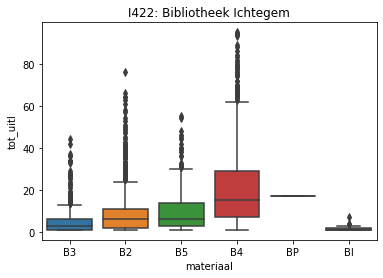

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4921.000000    4921.000000  4921.000000         I422   
mean     11.801463    2018.110953     8.735013         I422   
std      13.828369       3.037483     5.385362         I422   
min       1.000000    2009.000000     0.000000         I422   
25%       2.000000    2016.000000     5.000000         I422   
50%       6.000000    2019.000000     8.000000         I422   
75%      15.000000    2020.000000    11.000000         I422   
max      95.000000    2022.000000    27.000000         I422   

                bibliotheek  
count  Bibliotheek Ichtegem  
mean   Bibliotheek Ichtegem  
std    Bibliotheek Ichtegem  
min    Bibliotheek Ichtegem  
25%    Bibliotheek Ichtegem  
50%    Bibliotheek Ichtegem  
75%    Bibliotheek Ichtegem  
max    Bibliotheek Ichtegem

____________________________________________________________
Bibliotheek Ieper


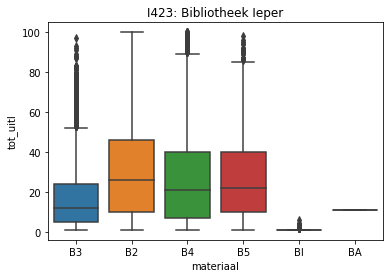

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  18096.000000   18096.000000  18096.000000         I423   
mean      23.630858    2017.274646     12.738837         I423   
std       21.277168       5.629301      6.484508         I423   
min        1.000000    1997.000000      0.000000         I423   
25%        6.000000    2016.000000      8.000000         I423   
50%       17.000000    2020.000000     12.000000         I423   
75%       36.000000    2021.000000     17.000000         I423   
max      100.000000    2022.000000     25.000000         I423   

             bibliotheek  
count  Bibliotheek Ieper  
mean   Bibliotheek Ieper  
std    Bibliotheek Ieper  
min    Bibliotheek Ieper  
25%    Bibliotheek Ieper  
50%    Bibliotheek Ieper  
75%    Bibliotheek Ieper  
max    Bibliotheek Ieper

____________________________________________________________
Bibliotheek Ingelmunster


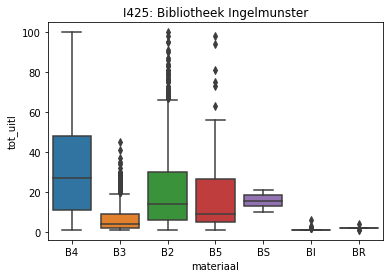

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3398.000000     3398.00000  3398.000000         I425   
mean     20.211889     2017.39229    16.576221         I425   
std      20.797292        4.17663     7.632834         I425   
min       1.000000     2006.00000     0.000000         I425   
25%       4.250000     2015.00000    11.000000         I425   
50%      12.000000     2019.00000    18.000000         I425   
75%      30.000000     2021.00000    23.000000         I425   
max     100.000000     2022.00000    28.000000         I425   

                    bibliotheek  
count  Bibliotheek Ingelmunster  
mean   Bibliotheek Ingelmunster  
std    Bibliotheek Ingelmunster  
min    Bibliotheek Ingelmunster  
25%    Bibliotheek Ingelmunster  
50%    Bibliotheek Ingelmunster  
75%    Bibliotheek Ingelmunster  
max    Bibliotheek Ingelmunster

____________________________________________________________
Bibliotheek Izegem


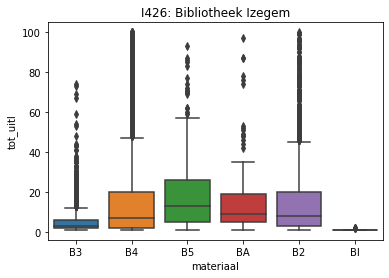

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  12097.000000   12097.000000  12097.000000         I426   
mean      11.494337    2015.216665     15.103993         I426   
std       16.792176       3.754111      6.518665         I426   
min        1.000000    2007.000000      0.000000         I426   
25%        2.000000    2012.000000     10.000000         I426   
50%        5.000000    2015.000000     16.000000         I426   
75%       12.000000    2018.000000     21.000000         I426   
max      100.000000    2022.000000     25.000000         I426   

              bibliotheek  
count  Bibliotheek Izegem  
mean   Bibliotheek Izegem  
std    Bibliotheek Izegem  
min    Bibliotheek Izegem  
25%    Bibliotheek Izegem  
50%    Bibliotheek Izegem  
75%    Bibliotheek Izegem  
max    Bibliotheek Izegem

____________________________________________________________
Bibliotheek Jabbeke


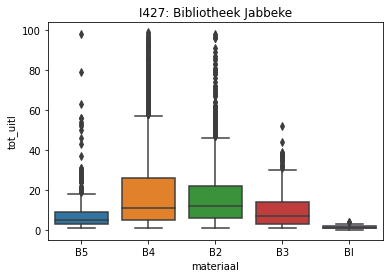

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5329.000000    5329.000000  5329.000000         I427   
mean     16.171327    2017.146557    11.876525         I427   
std      17.379101       3.824082     5.775660         I427   
min       0.000000    1995.000000     0.000000         I427   
25%       5.000000    2015.000000     8.000000         I427   
50%      10.000000    2018.000000    12.000000         I427   
75%      21.000000    2020.000000    16.000000         I427   
max      99.000000    2022.000000    29.000000         I427   

               bibliotheek  
count  Bibliotheek Jabbeke  
mean   Bibliotheek Jabbeke  
std    Bibliotheek Jabbeke  
min    Bibliotheek Jabbeke  
25%    Bibliotheek Jabbeke  
50%    Bibliotheek Jabbeke  
75%    Bibliotheek Jabbeke  
max    Bibliotheek Jabbeke

____________________________________________________________
Bibliotheek Knokke-Heist


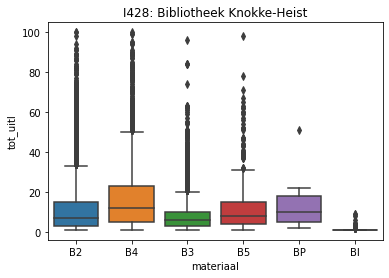

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  17418.000000   17418.000000  17418.000000         I428   
mean      11.806752    2018.599782      8.362728         I428   
std       13.170645       2.073588      5.418546         I428   
min        1.000000    2009.000000      0.000000         I428   
25%        3.000000    2017.000000      4.000000         I428   
50%        7.000000    2018.000000      7.000000         I428   
75%       15.000000    2020.000000     11.000000         I428   
max      100.000000    2022.000000     28.000000         I428   

                    bibliotheek  
count  Bibliotheek Knokke-Heist  
mean   Bibliotheek Knokke-Heist  
std    Bibliotheek Knokke-Heist  
min    Bibliotheek Knokke-Heist  
25%    Bibliotheek Knokke-Heist  
50%    Bibliotheek Knokke-Heist  
75%    Bibliotheek Knokke-Heist  
max    Bibliotheek Knokke-Heist

____________________________________________________________
Bibliotheek Koekelare


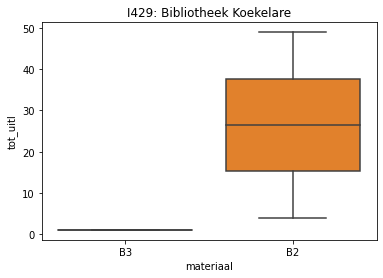

tot_uitl  ltst_jaar_uit   lft_exem instantie_id            bibliotheek
count   3.000000       3.000000   3.000000         I429  Bibliotheek Koekelare
mean   18.000000    2018.666667  18.333333         I429  Bibliotheek Koekelare
std    26.888659       5.773503   3.511885         I429  Bibliotheek Koekelare
min     1.000000    2012.000000  15.000000         I429  Bibliotheek Koekelare
25%     2.500000    2017.000000  16.500000         I429  Bibliotheek Koekelare
50%     4.000000    2022.000000  18.000000         I429  Bibliotheek Koekelare
75%    26.500000    2022.000000  20.000000         I429  Bibliotheek Koekelare
max    49.000000    2022.000000  22.000000         I429  Bibliotheek Koekelare

____________________________________________________________
Bibliotheek Koksijde


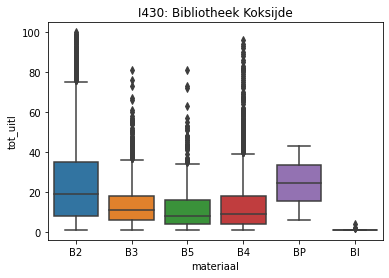

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9827.000000     9827.00000  9827.000000         I430   
mean     18.360334     2019.30691     9.408874         I430   
std      17.516632        2.14193     4.640628         I430   
min       1.000000     2007.00000     0.000000         I430   
25%       6.000000     2018.00000     6.000000         I430   
50%      13.000000     2020.00000     9.000000         I430   
75%      25.000000     2021.00000    12.000000         I430   
max     100.000000     2022.00000    28.000000         I430   

                bibliotheek  
count  Bibliotheek Koksijde  
mean   Bibliotheek Koksijde  
std    Bibliotheek Koksijde  
min    Bibliotheek Koksijde  
25%    Bibliotheek Koksijde  
50%    Bibliotheek Koksijde  
75%    Bibliotheek Koksijde  
max    Bibliotheek Koksijde

____________________________________________________________
Bibliotheek Kortemark


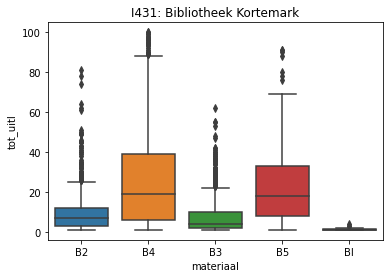

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4235.000000    4235.000000  4235.000000         I431   
mean     13.217001    2017.714522    10.510744         I431   
std      16.693785       2.982545     6.518682         I431   
min       1.000000    2007.000000     0.000000         I431   
25%       3.000000    2016.000000     5.000000         I431   
50%       7.000000    2017.000000    10.000000         I431   
75%      17.000000    2021.000000    15.000000         I431   
max     100.000000    2022.000000    28.000000         I431   

                 bibliotheek  
count  Bibliotheek Kortemark  
mean   Bibliotheek Kortemark  
std    Bibliotheek Kortemark  
min    Bibliotheek Kortemark  
25%    Bibliotheek Kortemark  
50%    Bibliotheek Kortemark  
75%    Bibliotheek Kortemark  
max    Bibliotheek Kortemark

____________________________________________________________
Bibliotheek Kortrijk


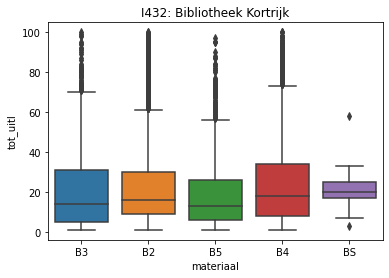

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  16349.000000   16349.000000  16349.000000         I432   
mean      21.800294    2017.621812     12.981161         I432   
std       18.928812       3.660429      6.214255         I432   
min        1.000000    1999.000000      0.000000         I432   
25%        7.000000    2016.000000      8.000000         I432   
50%       16.000000    2019.000000     13.000000         I432   
75%       31.000000    2020.000000     17.000000         I432   
max      100.000000    2022.000000     39.000000         I432   

                bibliotheek  
count  Bibliotheek Kortrijk  
mean   Bibliotheek Kortrijk  
std    Bibliotheek Kortrijk  
min    Bibliotheek Kortrijk  
25%    Bibliotheek Kortrijk  
50%    Bibliotheek Kortrijk  
75%    Bibliotheek Kortrijk  
max    Bibliotheek Kortrijk

____________________________________________________________
Bibliotheek Kuurne


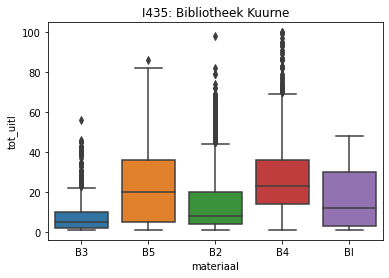

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5356.000000    5356.000000  5356.000000         I435   
mean     16.718820    2018.956311    13.413928         I435   
std      16.017384       2.394897     6.053409         I435   
min       1.000000    2010.000000     0.000000         I435   
25%       4.000000    2018.000000     9.000000         I435   
50%      11.000000    2020.000000    13.000000         I435   
75%      24.000000    2021.000000    17.000000         I435   
max     100.000000    2022.000000    30.000000         I435   

              bibliotheek  
count  Bibliotheek Kuurne  
mean   Bibliotheek Kuurne  
std    Bibliotheek Kuurne  
min    Bibliotheek Kuurne  
25%    Bibliotheek Kuurne  
50%    Bibliotheek Kuurne  
75%    Bibliotheek Kuurne  
max    Bibliotheek Kuurne

____________________________________________________________
Bibliotheek Langemark-Poelkapelle


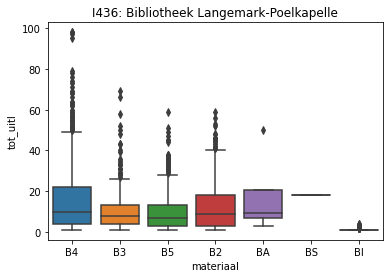

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2536.000000    2536.000000  2536.000000         I436   
mean     11.835174    2014.496057    16.249606         I436   
std      12.615183       5.153500     7.352521         I436   
min       1.000000    2000.000000     0.000000         I436   
25%       3.000000    2011.000000    13.000000         I436   
50%       8.000000    2015.000000    19.000000         I436   
75%      15.000000    2018.000000    22.000000         I436   
max      98.000000    2022.000000    25.000000         I436   

                             bibliotheek  
count  Bibliotheek Langemark-Poelkapelle  
mean   Bibliotheek Langemark-Poelkapelle  
std    Bibliotheek Langemark-Poelkapelle  
min    Bibliotheek Langemark-Poelkapelle  
25%    Bibliotheek Langemark-Poelkapelle  
50%    Bibliotheek Langemark-Poelkapelle  
75%    Bibliotheek Langemark-Poelkapelle  
max    Bibliotheek Langemark-Poelkapelle

____________________________________________________________
Bibliotheek Ledegem


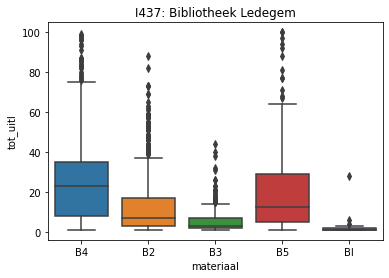

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2628.000000    2628.000000  2628.000000         I437   
mean     16.972603    2017.824581    16.523592         I437   
std      18.072139       3.503228     6.312914         I437   
min       1.000000    2008.000000     0.000000         I437   
25%       3.000000    2016.000000    15.000000         I437   
50%      10.000000    2019.000000    18.000000         I437   
75%      27.000000    2020.000000    21.000000         I437   
max     100.000000    2022.000000    27.000000         I437   

               bibliotheek  
count  Bibliotheek Ledegem  
mean   Bibliotheek Ledegem  
std    Bibliotheek Ledegem  
min    Bibliotheek Ledegem  
25%    Bibliotheek Ledegem  
50%    Bibliotheek Ledegem  
75%    Bibliotheek Ledegem  
max    Bibliotheek Ledegem

____________________________________________________________
Bibliotheek Lendelede


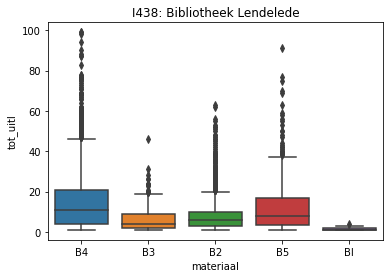

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4908.000000    4908.000000  4908.000000         I438   
mean     12.181948    2018.212918    17.088427         I438   
std      13.034251       3.085379     4.865956         I438   
min       1.000000    2010.000000     0.000000         I438   
25%       3.000000    2017.000000    15.000000         I438   
50%       8.000000    2019.000000    18.000000         I438   
75%      16.000000    2021.000000    21.000000         I438   
max      99.000000    2022.000000    23.000000         I438   

                 bibliotheek  
count  Bibliotheek Lendelede  
mean   Bibliotheek Lendelede  
std    Bibliotheek Lendelede  
min    Bibliotheek Lendelede  
25%    Bibliotheek Lendelede  
50%    Bibliotheek Lendelede  
75%    Bibliotheek Lendelede  
max    Bibliotheek Lendelede

____________________________________________________________
Bibliotheek Lichtervelde


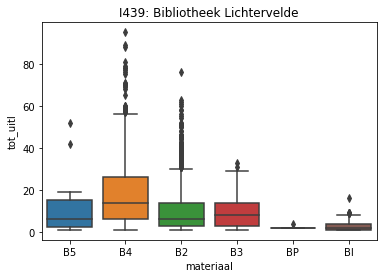

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3058.000000    3058.000000  3058.000000         I439   
mean     13.039568    2018.205363    14.734140         I439   
std      13.305699       3.084198     5.432696         I439   
min       1.000000    2010.000000     0.000000         I439   
25%       3.000000    2017.000000    12.000000         I439   
50%       8.000000    2019.000000    15.000000         I439   
75%      19.000000    2020.000000    19.000000         I439   
max      95.000000    2022.000000    22.000000         I439   

                    bibliotheek  
count  Bibliotheek Lichtervelde  
mean   Bibliotheek Lichtervelde  
std    Bibliotheek Lichtervelde  
min    Bibliotheek Lichtervelde  
25%    Bibliotheek Lichtervelde  
50%    Bibliotheek Lichtervelde  
75%    Bibliotheek Lichtervelde  
max    Bibliotheek Lichtervelde

____________________________________________________________
Bibliotheek Menen


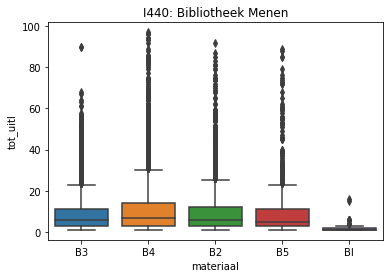

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  11852.000000   11852.000000  11852.000000         I440   
mean      10.289909    2016.643520     16.246878         I440   
std       11.966658       3.457065      6.458148         I440   
min        1.000000    2009.000000      0.000000         I440   
25%        3.000000    2014.000000     12.000000         I440   
50%        6.000000    2017.000000     16.000000         I440   
75%       12.000000    2019.000000     21.000000         I440   
max       97.000000    2022.000000     29.000000         I440   

             bibliotheek  
count  Bibliotheek Menen  
mean   Bibliotheek Menen  
std    Bibliotheek Menen  
min    Bibliotheek Menen  
25%    Bibliotheek Menen  
50%    Bibliotheek Menen  
75%    Bibliotheek Menen  
max    Bibliotheek Menen

____________________________________________________________
Bibliotheek Meulebeke


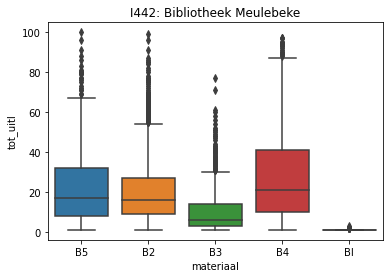

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4873.000000    4873.000000  4873.000000         I442   
mean     21.781449    2016.510363    15.644162         I442   
std      19.503727       3.640104     5.476232         I442   
min       1.000000    1999.000000     0.000000         I442   
25%       7.000000    2015.000000    12.000000         I442   
50%      15.000000    2017.000000    17.000000         I442   
75%      31.000000    2019.000000    20.000000         I442   
max     100.000000    2022.000000    23.000000         I442   

                 bibliotheek  
count  Bibliotheek Meulebeke  
mean   Bibliotheek Meulebeke  
std    Bibliotheek Meulebeke  
min    Bibliotheek Meulebeke  
25%    Bibliotheek Meulebeke  
50%    Bibliotheek Meulebeke  
75%    Bibliotheek Meulebeke  
max    Bibliotheek Meulebeke

____________________________________________________________
Bibliotheek Middelkerke


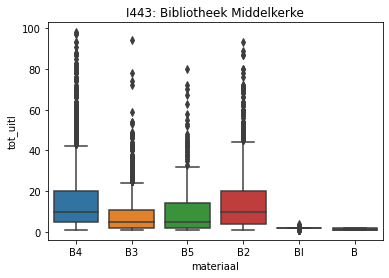

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6213.000000    6213.000000  6213.000000         I443   
mean     12.134718    2017.441655    11.870916         I443   
std      13.726084       3.466148     8.166475         I443   
min       1.000000    2007.000000     0.000000         I443   
25%       3.000000    2016.000000     5.000000         I443   
50%       7.000000    2019.000000    10.000000         I443   
75%      16.000000    2020.000000    19.000000         I443   
max      98.000000    2022.000000    29.000000         I443   

                   bibliotheek  
count  Bibliotheek Middelkerke  
mean   Bibliotheek Middelkerke  
std    Bibliotheek Middelkerke  
min    Bibliotheek Middelkerke  
25%    Bibliotheek Middelkerke  
50%    Bibliotheek Middelkerke  
75%    Bibliotheek Middelkerke  
max    Bibliotheek Middelkerke

____________________________________________________________
Bibliotheek Moorslede


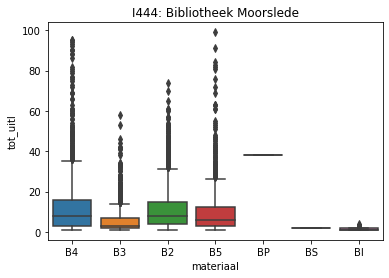

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6330.000000    6330.000000  6330.000000         I444   
mean      9.619747    2017.095261    15.292259         I444   
std      11.204302       3.439281     6.558671         I444   
min       1.000000    2008.000000     0.000000         I444   
25%       2.000000    2015.000000    11.000000         I444   
50%       6.000000    2018.000000    15.000000         I444   
75%      13.000000    2020.000000    21.000000         I444   
max      99.000000    2022.000000    27.000000         I444   

                 bibliotheek  
count  Bibliotheek Moorslede  
mean   Bibliotheek Moorslede  
std    Bibliotheek Moorslede  
min    Bibliotheek Moorslede  
25%    Bibliotheek Moorslede  
50%    Bibliotheek Moorslede  
75%    Bibliotheek Moorslede  
max    Bibliotheek Moorslede

____________________________________________________________
Bibliotheek Nieuwpoort


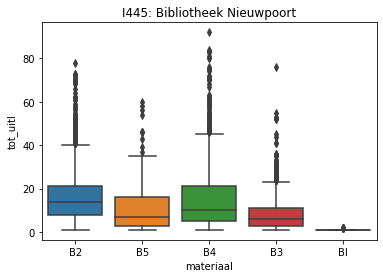

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4649.000000    4649.000000  4649.000000         I445   
mean     13.808346    2017.610239    14.403097         I445   
std      12.148786       2.772178     4.844985         I445   
min       1.000000    2008.000000     0.000000         I445   
25%       5.000000    2016.000000    11.000000         I445   
50%      10.000000    2018.000000    15.000000         I445   
75%      19.000000    2020.000000    18.000000         I445   
max      92.000000    2022.000000    24.000000         I445   

                  bibliotheek  
count  Bibliotheek Nieuwpoort  
mean   Bibliotheek Nieuwpoort  
std    Bibliotheek Nieuwpoort  
min    Bibliotheek Nieuwpoort  
25%    Bibliotheek Nieuwpoort  
50%    Bibliotheek Nieuwpoort  
75%    Bibliotheek Nieuwpoort  
max    Bibliotheek Nieuwpoort

____________________________________________________________
Bibliotheek Oostkamp


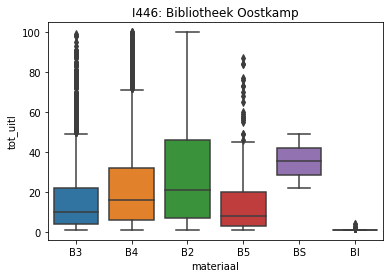

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  10706.000000   10706.000000  10706.000000         I446   
mean      21.715206    2017.782085     13.811134         I446   
std       21.530046       3.492818      6.704172         I446   
min        1.000000    2006.000000      0.000000         I446   
25%        5.000000    2016.000000      9.000000         I446   
50%       14.000000    2019.000000     13.000000         I446   
75%       33.000000    2021.000000     18.000000         I446   
max      100.000000    2022.000000     29.000000         I446   

                bibliotheek  
count  Bibliotheek Oostkamp  
mean   Bibliotheek Oostkamp  
std    Bibliotheek Oostkamp  
min    Bibliotheek Oostkamp  
25%    Bibliotheek Oostkamp  
50%    Bibliotheek Oostkamp  
75%    Bibliotheek Oostkamp  
max    Bibliotheek Oostkamp

____________________________________________________________
Bibliotheek Oostrozebeke


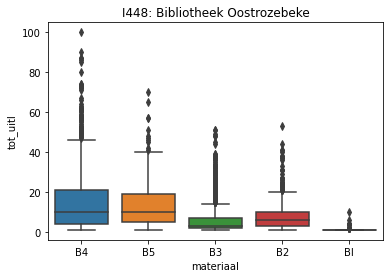

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4333.000000    4333.000000  4333.000000         I448   
mean      9.139626    2016.930072    12.569121         I448   
std      11.165800       3.391295     5.546383         I448   
min       1.000000    2008.000000     0.000000         I448   
25%       2.000000    2015.000000     9.000000         I448   
50%       5.000000    2017.000000    12.000000         I448   
75%      11.000000    2019.000000    18.000000         I448   
max     100.000000    2022.000000    22.000000         I448   

                    bibliotheek  
count  Bibliotheek Oostrozebeke  
mean   Bibliotheek Oostrozebeke  
std    Bibliotheek Oostrozebeke  
min    Bibliotheek Oostrozebeke  
25%    Bibliotheek Oostrozebeke  
50%    Bibliotheek Oostrozebeke  
75%    Bibliotheek Oostrozebeke  
max    Bibliotheek Oostrozebeke

____________________________________________________________
Bibliotheek Oudenburg


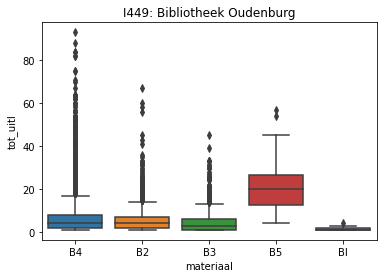

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5815.000000    5815.000000  5815.000000         I449   
mean      6.087704    2012.796045    15.559071         I449   
std       8.247830       4.047111     4.736240         I449   
min       1.000000    2006.000000     0.000000         I449   
25%       2.000000    2009.500000    13.000000         I449   
50%       3.000000    2013.000000    17.000000         I449   
75%       7.000000    2016.000000    19.000000         I449   
max      93.000000    2022.000000    23.000000         I449   

                 bibliotheek  
count  Bibliotheek Oudenburg  
mean   Bibliotheek Oudenburg  
std    Bibliotheek Oudenburg  
min    Bibliotheek Oudenburg  
25%    Bibliotheek Oudenburg  
50%    Bibliotheek Oudenburg  
75%    Bibliotheek Oudenburg  
max    Bibliotheek Oudenburg

____________________________________________________________
Bibliotheek Pittem


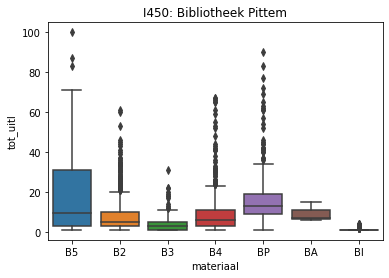

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2281.000000    2281.000000  2281.000000         I450   
mean      9.125384    2017.692679    11.625164         I450   
std      11.055167       3.521212     6.655051         I450   
min       1.000000    2008.000000     0.000000         I450   
25%       2.000000    2015.000000     7.000000         I450   
50%       5.000000    2019.000000    11.000000         I450   
75%      12.000000    2021.000000    16.000000         I450   
max     100.000000    2022.000000    26.000000         I450   

              bibliotheek  
count  Bibliotheek Pittem  
mean   Bibliotheek Pittem  
std    Bibliotheek Pittem  
min    Bibliotheek Pittem  
25%    Bibliotheek Pittem  
50%    Bibliotheek Pittem  
75%    Bibliotheek Pittem  
max    Bibliotheek Pittem

____________________________________________________________
Bibliotheek Poperinge


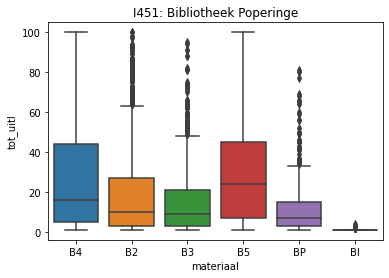

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7268.000000    7268.000000  7268.000000         I451   
mean     22.022977    2016.913043    16.532058         I451   
std      23.890913       4.411306     5.215456         I451   
min       1.000000    1998.000000     0.000000         I451   
25%       4.000000    2015.000000    13.000000         I451   
50%      12.000000    2018.000000    18.000000         I451   
75%      32.000000    2020.000000    20.000000         I451   
max     100.000000    2022.000000    25.000000         I451   

                 bibliotheek  
count  Bibliotheek Poperinge  
mean   Bibliotheek Poperinge  
std    Bibliotheek Poperinge  
min    Bibliotheek Poperinge  
25%    Bibliotheek Poperinge  
50%    Bibliotheek Poperinge  
75%    Bibliotheek Poperinge  
max    Bibliotheek Poperinge

____________________________________________________________
Bibliotheek Roeselare


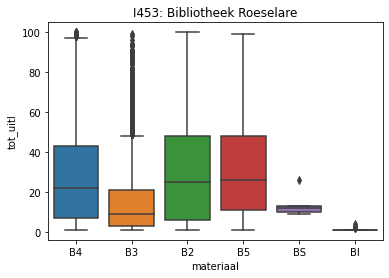

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  17770.000000   17770.000000  17770.000000         I453   
mean      23.129826    2016.885594     12.749184         I453   
std       23.052775       4.846362      5.562223         I453   
min        1.000000    1996.000000      0.000000         I453   
25%        4.000000    2014.000000      9.000000         I453   
50%       15.000000    2019.000000     12.000000         I453   
75%       36.000000    2020.000000     17.000000         I453   
max      100.000000    2022.000000     28.000000         I453   

                 bibliotheek  
count  Bibliotheek Roeselare  
mean   Bibliotheek Roeselare  
std    Bibliotheek Roeselare  
min    Bibliotheek Roeselare  
25%    Bibliotheek Roeselare  
50%    Bibliotheek Roeselare  
75%    Bibliotheek Roeselare  
max    Bibliotheek Roeselare

____________________________________________________________
Bibliotheek Staden


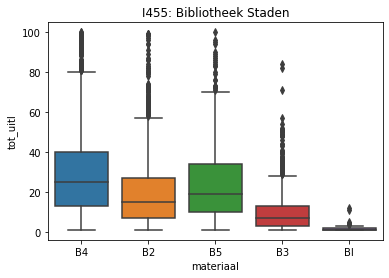

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9003.000000    9003.000000  9003.000000         I455   
mean     22.450072    2019.357103    10.086638         I455   
std      19.407293       2.315700     5.004757         I455   
min       1.000000    1999.000000     0.000000         I455   
25%       7.000000    2018.000000     7.000000         I455   
50%      17.000000    2020.000000    10.000000         I455   
75%      32.000000    2021.000000    13.000000         I455   
max     100.000000    2022.000000    27.000000         I455   

              bibliotheek  
count  Bibliotheek Staden  
mean   Bibliotheek Staden  
std    Bibliotheek Staden  
min    Bibliotheek Staden  
25%    Bibliotheek Staden  
50%    Bibliotheek Staden  
75%    Bibliotheek Staden  
max    Bibliotheek Staden

____________________________________________________________
Bibliotheek Tielt


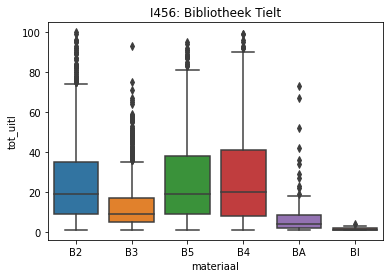

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  6433.000000    6433.000000  6433.000000         I456  Bibliotheek Tielt
mean     19.819835    2017.512047    14.708845         I456  Bibliotheek Tielt
std      18.701123       3.694349     6.818403         I456  Bibliotheek Tielt
min       1.000000    2002.000000     0.000000         I456  Bibliotheek Tielt
25%       6.000000    2015.000000    10.000000         I456  Bibliotheek Tielt
50%      13.000000    2018.000000    15.000000         I456  Bibliotheek Tielt
75%      28.000000    2021.000000    20.000000         I456  Bibliotheek Tielt
max     100.000000    2022.000000    27.000000         I456  Bibliotheek Tielt

____________________________________________________________
Bibliotheek Torhout


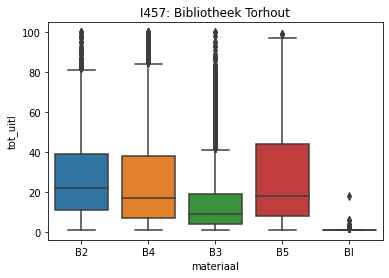

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  10010.000000   10010.000000  10010.000000         I457   
mean      20.519281    2016.461339     14.895205         I457   
std       21.207444       4.820544      7.377542         I457   
min        1.000000    1997.000000      0.000000         I457   
25%        5.000000    2014.000000     10.000000         I457   
50%       13.000000    2018.000000     14.000000         I457   
75%       29.000000    2020.000000     22.000000         I457   
max      100.000000    2022.000000     28.000000         I457   

               bibliotheek  
count  Bibliotheek Torhout  
mean   Bibliotheek Torhout  
std    Bibliotheek Torhout  
min    Bibliotheek Torhout  
25%    Bibliotheek Torhout  
50%    Bibliotheek Torhout  
75%    Bibliotheek Torhout  
max    Bibliotheek Torhout

____________________________________________________________
Bibliotheek Veurne


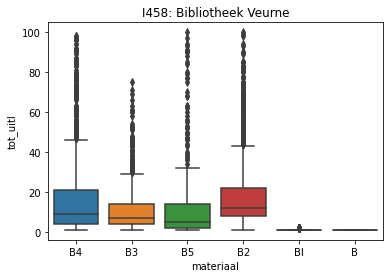

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5366.000000    5366.000000  5366.000000         I458   
mean     14.505963    2016.904398    14.546962         I458   
std      16.444214       3.629432     6.457888         I458   
min       1.000000    2007.000000     0.000000         I458   
25%       4.000000    2014.000000    10.000000         I458   
50%       9.000000    2017.000000    14.000000         I458   
75%      17.000000    2020.000000    19.000000         I458   
max     100.000000    2022.000000    27.000000         I458   

              bibliotheek  
count  Bibliotheek Veurne  
mean   Bibliotheek Veurne  
std    Bibliotheek Veurne  
min    Bibliotheek Veurne  
25%    Bibliotheek Veurne  
50%    Bibliotheek Veurne  
75%    Bibliotheek Veurne  
max    Bibliotheek Veurne

____________________________________________________________
Bibliotheek Waregem


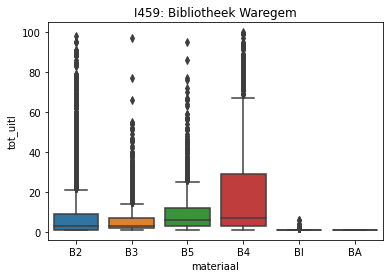

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7933.000000    7933.000000  7933.000000         I459   
mean     10.912517    2018.993571     8.745998         I459   
std      16.377209       3.120311     1.983326         I459   
min       1.000000    2012.000000     0.000000         I459   
25%       2.000000    2017.000000     8.000000         I459   
50%       4.000000    2020.000000     9.000000         I459   
75%      12.000000    2022.000000    10.000000         I459   
max     100.000000    2022.000000    10.000000         I459   

               bibliotheek  
count  Bibliotheek Waregem  
mean   Bibliotheek Waregem  
std    Bibliotheek Waregem  
min    Bibliotheek Waregem  
25%    Bibliotheek Waregem  
50%    Bibliotheek Waregem  
75%    Bibliotheek Waregem  
max    Bibliotheek Waregem

____________________________________________________________
Bibliotheek Wervik


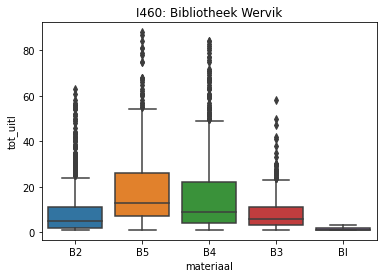

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4234.000000    4234.000000  4234.000000         I460   
mean     11.474256    2016.641001    12.480633         I460   
std      13.134530       3.653047     5.986971         I460   
min       1.000000    2007.000000     0.000000         I460   
25%       3.000000    2014.000000     8.000000         I460   
50%       7.000000    2018.000000    12.000000         I460   
75%      15.000000    2020.000000    17.000000         I460   
max      88.000000    2022.000000    25.000000         I460   

              bibliotheek  
count  Bibliotheek Wervik  
mean   Bibliotheek Wervik  
std    Bibliotheek Wervik  
min    Bibliotheek Wervik  
25%    Bibliotheek Wervik  
50%    Bibliotheek Wervik  
75%    Bibliotheek Wervik  
max    Bibliotheek Wervik

____________________________________________________________
Bibliotheek Wevelgem


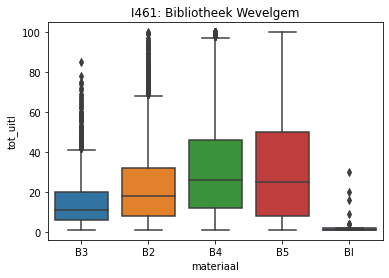

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  12414.000000   12414.000000  12414.000000         I461   
mean      25.498147    2017.500000     13.773723         I461   
std       21.677524       3.995562      5.759481         I461   
min        1.000000    1996.000000      0.000000         I461   
25%        9.000000    2015.000000     10.000000         I461   
50%       19.000000    2019.000000     14.000000         I461   
75%       36.000000    2021.000000     18.000000         I461   
max      100.000000    2022.000000     29.000000         I461   

                bibliotheek  
count  Bibliotheek Wevelgem  
mean   Bibliotheek Wevelgem  
std    Bibliotheek Wevelgem  
min    Bibliotheek Wevelgem  
25%    Bibliotheek Wevelgem  
50%    Bibliotheek Wevelgem  
75%    Bibliotheek Wevelgem  
max    Bibliotheek Wevelgem

____________________________________________________________
Bibliotheek Wielsbeke


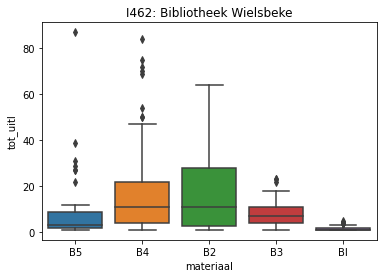

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  982.000000     982.000000  982.000000         I462   
mean     8.225051    2020.294297    7.396130         I462   
std     11.684402       2.087277    9.124962         I462   
min      1.000000    2008.000000    0.000000         I462   
25%      1.000000    2020.000000    0.000000         I462   
50%      3.000000    2021.000000    3.000000         I462   
75%     11.000000    2022.000000   11.000000         I462   
max     87.000000    2022.000000   26.000000         I462   

                 bibliotheek  
count  Bibliotheek Wielsbeke  
mean   Bibliotheek Wielsbeke  
std    Bibliotheek Wielsbeke  
min    Bibliotheek Wielsbeke  
25%    Bibliotheek Wielsbeke  
50%    Bibliotheek Wielsbeke  
75%    Bibliotheek Wielsbeke  
max    Bibliotheek Wielsbeke

____________________________________________________________
Bibliotheek Wingene


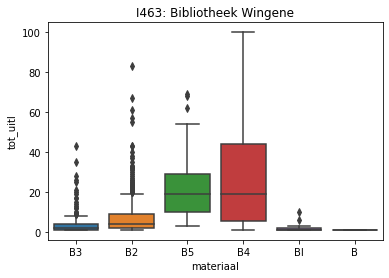

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1412.000000    1412.000000  1412.000000         I463   
mean      9.173513    2016.451841    14.351275         I463   
std      13.650297       3.204325     8.252988         I463   
min       1.000000    2009.000000     0.000000         I463   
25%       2.000000    2014.000000     8.000000         I463   
50%       4.000000    2016.000000    15.000000         I463   
75%      10.000000    2019.000000    22.000000         I463   
max     100.000000    2022.000000    31.000000         I463   

               bibliotheek  
count  Bibliotheek Wingene  
mean   Bibliotheek Wingene  
std    Bibliotheek Wingene  
min    Bibliotheek Wingene  
25%    Bibliotheek Wingene  
50%    Bibliotheek Wingene  
75%    Bibliotheek Wingene  
max    Bibliotheek Wingene

____________________________________________________________
Bibliotheek Zedelgem


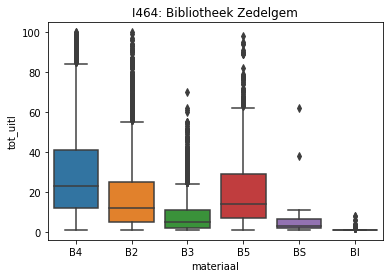

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  11365.000000   11365.000000  11355.000000         I464   
mean      16.811263    2017.866344     12.585381         I464   
std       18.489569       3.192961      6.068962         I464   
min        1.000000    2008.000000      0.000000         I464   
25%        4.000000    2016.000000      8.000000         I464   
50%       10.000000    2019.000000     12.000000         I464   
75%       23.000000    2020.000000     17.000000         I464   
max      100.000000    2022.000000     29.000000         I464   

                bibliotheek  
count  Bibliotheek Zedelgem  
mean   Bibliotheek Zedelgem  
std    Bibliotheek Zedelgem  
min    Bibliotheek Zedelgem  
25%    Bibliotheek Zedelgem  
50%    Bibliotheek Zedelgem  
75%    Bibliotheek Zedelgem  
max    Bibliotheek Zedelgem

____________________________________________________________
Bibliotheek Zonnebeke


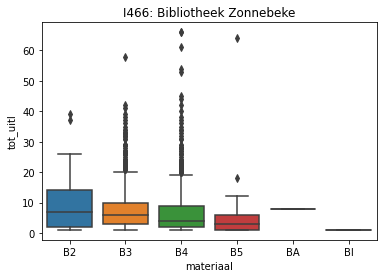

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2185.000000    2185.000000  2185.000000         I466   
mean      7.484211    2016.283295    15.495195         I466   
std       7.400924       2.824510     8.699559         I466   
min       1.000000    2007.000000     0.000000         I466   
25%       3.000000    2014.000000    11.000000         I466   
50%       5.000000    2016.000000    17.000000         I466   
75%       9.000000    2017.000000    22.000000         I466   
max      66.000000    2022.000000    28.000000         I466   

                 bibliotheek  
count  Bibliotheek Zonnebeke  
mean   Bibliotheek Zonnebeke  
std    Bibliotheek Zonnebeke  
min    Bibliotheek Zonnebeke  
25%    Bibliotheek Zonnebeke  
50%    Bibliotheek Zonnebeke  
75%    Bibliotheek Zonnebeke  
max    Bibliotheek Zonnebeke

____________________________________________________________
Bibliotheek Zwevegem


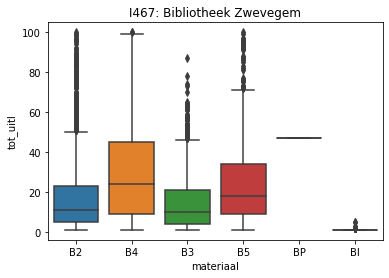

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7339.000000    7339.000000  7339.000000         I467   
mean     20.801199    2018.879956    12.242949         I467   
std      20.828018       2.850582     6.191038         I467   
min       1.000000    2009.000000     0.000000         I467   
25%       5.000000    2018.000000     8.000000         I467   
50%      14.000000    2020.000000    12.000000         I467   
75%      30.000000    2021.000000    17.000000         I467   
max     100.000000    2022.000000    28.000000         I467   

                bibliotheek  
count  Bibliotheek Zwevegem  
mean   Bibliotheek Zwevegem  
std    Bibliotheek Zwevegem  
min    Bibliotheek Zwevegem  
25%    Bibliotheek Zwevegem  
50%    Bibliotheek Zwevegem  
75%    Bibliotheek Zwevegem  
max    Bibliotheek Zwevegem

____________________________________________________________
Bibliotheek Anderlecht


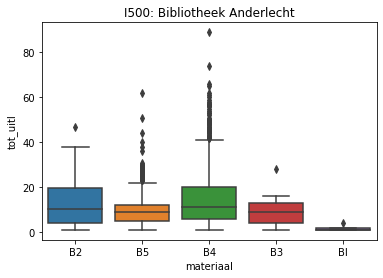

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2278.000000    2278.000000  2278.000000         I500   
mean     13.273047    2019.117647     9.820018         I500   
std      10.946313       2.028180     4.688927         I500   
min       1.000000    2013.000000     0.000000         I500   
25%       5.000000    2018.000000     6.000000         I500   
50%      10.000000    2019.000000    11.000000         I500   
75%      18.000000    2021.000000    13.000000         I500   
max      89.000000    2022.000000    26.000000         I500   

                  bibliotheek  
count  Bibliotheek Anderlecht  
mean   Bibliotheek Anderlecht  
std    Bibliotheek Anderlecht  
min    Bibliotheek Anderlecht  
25%    Bibliotheek Anderlecht  
50%    Bibliotheek Anderlecht  
75%    Bibliotheek Anderlecht  
max    Bibliotheek Anderlecht

____________________________________________________________
Bibliotheek Brussel-stad


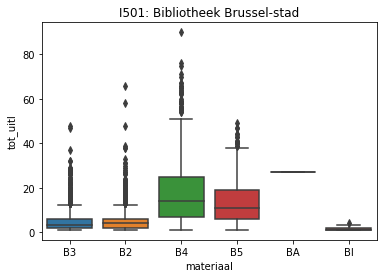

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5820.000000    5820.000000  5703.000000         I501   
mean      8.880241    2013.569244    14.800982         I501   
std      10.303435       6.617208     7.991699         I501   
min       1.000000    1998.000000     0.000000         I501   
25%       2.000000    2008.000000     8.000000         I501   
50%       5.000000    2015.000000    15.000000         I501   
75%      11.000000    2020.000000    21.000000         I501   
max      90.000000    2022.000000    29.000000         I501   

                    bibliotheek  
count  Bibliotheek Brussel-stad  
mean   Bibliotheek Brussel-stad  
std    Bibliotheek Brussel-stad  
min    Bibliotheek Brussel-stad  
25%    Bibliotheek Brussel-stad  
50%    Bibliotheek Brussel-stad  
75%    Bibliotheek Brussel-stad  
max    Bibliotheek Brussel-stad

____________________________________________________________
Bibliotheek Elsene


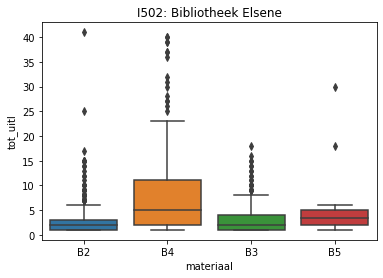

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1264.000000    1264.000000  1264.000000         I502   
mean      4.122627    2015.327532     9.760285         I502   
std       5.117773       3.061575     2.783899         I502   
min       1.000000    2009.000000     0.000000         I502   
25%       1.000000    2013.000000     8.000000         I502   
50%       2.000000    2015.000000    10.000000         I502   
75%       5.000000    2018.000000    12.000000         I502   
max      41.000000    2022.000000    14.000000         I502   

              bibliotheek  
count  Bibliotheek Elsene  
mean   Bibliotheek Elsene  
std    Bibliotheek Elsene  
min    Bibliotheek Elsene  
25%    Bibliotheek Elsene  
50%    Bibliotheek Elsene  
75%    Bibliotheek Elsene  
max    Bibliotheek Elsene

____________________________________________________________
Bibliotheek Etterbeek


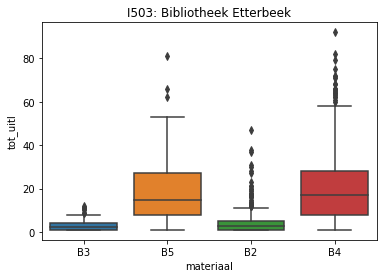

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2350.000000    2350.000000  2350.000000         I503   
mean     13.639574    2018.028085    10.099574         I503   
std      13.818992       3.539845     3.864163         I503   
min       1.000000    2008.000000     0.000000         I503   
25%       3.000000    2015.000000     7.000000         I503   
50%       9.000000    2019.000000    11.000000         I503   
75%      21.000000    2021.000000    13.000000         I503   
max      92.000000    2022.000000    15.000000         I503   

                 bibliotheek  
count  Bibliotheek Etterbeek  
mean   Bibliotheek Etterbeek  
std    Bibliotheek Etterbeek  
min    Bibliotheek Etterbeek  
25%    Bibliotheek Etterbeek  
50%    Bibliotheek Etterbeek  
75%    Bibliotheek Etterbeek  
max    Bibliotheek Etterbeek

____________________________________________________________
Bibliotheek Evere


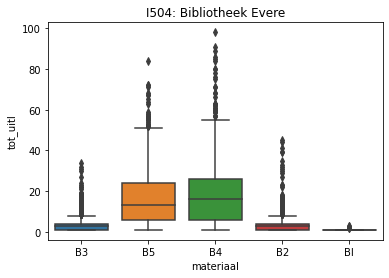

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  5256.000000    5256.000000  5256.000000         I504  Bibliotheek Evere
mean      9.276065    2014.366438    13.792618         I504  Bibliotheek Evere
std      12.257935       4.824104     4.536562         I504  Bibliotheek Evere
min       1.000000    2002.000000     0.000000         I504  Bibliotheek Evere
25%       2.000000    2011.000000    11.000000         I504  Bibliotheek Evere
50%       4.000000    2015.000000    15.000000         I504  Bibliotheek Evere
75%      11.000000    2019.000000    18.000000         I504  Bibliotheek Evere
max      98.000000    2022.000000    23.000000         I504  Bibliotheek Evere

____________________________________________________________
Bibliotheek Ganshoren


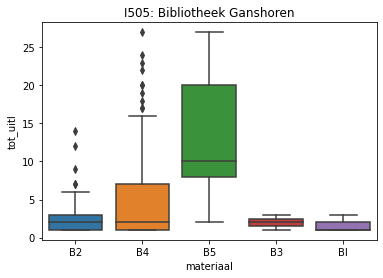

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  313.000000     313.000000  313.000000         I505   
mean     3.872204    2020.319489    3.661342         I505   
std      5.025221       1.467655    1.658411         I505   
min      1.000000    2017.000000    0.000000         I505   
25%      1.000000    2020.000000    3.000000         I505   
50%      2.000000    2021.000000    4.000000         I505   
75%      4.000000    2021.000000    5.000000         I505   
max     27.000000    2022.000000    6.000000         I505   

                 bibliotheek  
count  Bibliotheek Ganshoren  
mean   Bibliotheek Ganshoren  
std    Bibliotheek Ganshoren  
min    Bibliotheek Ganshoren  
25%    Bibliotheek Ganshoren  
50%    Bibliotheek Ganshoren  
75%    Bibliotheek Ganshoren  
max    Bibliotheek Ganshoren

____________________________________________________________
Bibliotheek Jette


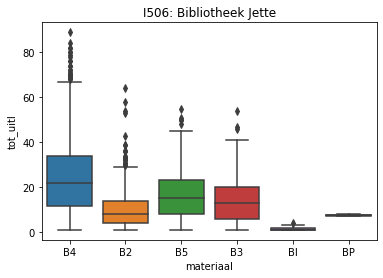

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  2048.000000    2048.000000  2048.000000         I506  Bibliotheek Jette
mean     18.547852    2018.558594    10.093262         I506  Bibliotheek Jette
std      14.935152       2.906369     5.716097         I506  Bibliotheek Jette
min       1.000000    2001.000000     0.000000         I506  Bibliotheek Jette
25%       7.000000    2016.000000     6.000000         I506  Bibliotheek Jette
50%      15.000000    2020.000000     9.000000         I506  Bibliotheek Jette
75%      27.000000    2021.000000    14.000000         I506  Bibliotheek Jette
max      89.000000    2022.000000    23.000000         I506  Bibliotheek Jette

____________________________________________________________
Bibliotheek Koekelberg


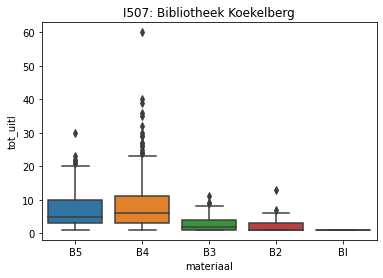

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  485.000000     485.000000  485.000000         I507   
mean     6.183505    2018.098969   11.076289         I507   
std      7.008653       2.998364    4.816504         I507   
min      1.000000    2009.000000    0.000000         I507   
25%      2.000000    2017.000000    8.000000         I507   
50%      4.000000    2019.000000   11.000000         I507   
75%      8.000000    2020.000000   16.000000         I507   
max     60.000000    2022.000000   18.000000         I507   

                  bibliotheek  
count  Bibliotheek Koekelberg  
mean   Bibliotheek Koekelberg  
std    Bibliotheek Koekelberg  
min    Bibliotheek Koekelberg  
25%    Bibliotheek Koekelberg  
50%    Bibliotheek Koekelberg  
75%    Bibliotheek Koekelberg  
max    Bibliotheek Koekelberg

____________________________________________________________
Bibliotheek Muntpunt


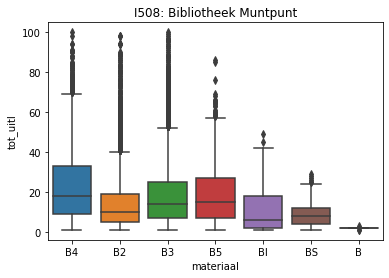

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  17568.000000   17568.000000  16791.000000         I508   
mean      17.718010    2018.034608      9.528259         I508   
std       15.582449       4.335026      6.239485         I508   
min        1.000000    1993.000000      0.000000         I508   
25%        6.000000    2017.000000      5.000000         I508   
50%       13.000000    2019.000000      8.000000         I508   
75%       25.000000    2020.000000     14.000000         I508   
max      100.000000    2022.000000     29.000000         I508   

                bibliotheek  
count  Bibliotheek Muntpunt  
mean   Bibliotheek Muntpunt  
std    Bibliotheek Muntpunt  
min    Bibliotheek Muntpunt  
25%    Bibliotheek Muntpunt  
50%    Bibliotheek Muntpunt  
75%    Bibliotheek Muntpunt  
max    Bibliotheek Muntpunt

____________________________________________________________
Bibliotheek Oudergem


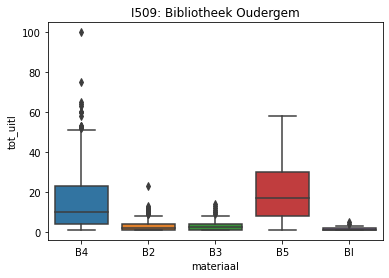

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1318.000000    1318.000000  1318.000000         I509   
mean      8.955235    2018.764036     6.726859         I509   
std      11.812261       2.719710     2.803034         I509   
min       1.000000    2012.000000     0.000000         I509   
25%       2.000000    2017.000000     5.000000         I509   
50%       4.000000    2020.000000     7.000000         I509   
75%      10.000000    2021.000000     9.000000         I509   
max     100.000000    2022.000000    11.000000         I509   

                bibliotheek  
count  Bibliotheek Oudergem  
mean   Bibliotheek Oudergem  
std    Bibliotheek Oudergem  
min    Bibliotheek Oudergem  
25%    Bibliotheek Oudergem  
50%    Bibliotheek Oudergem  
75%    Bibliotheek Oudergem  
max    Bibliotheek Oudergem

____________________________________________________________
Bibliotheek Schaarbeek


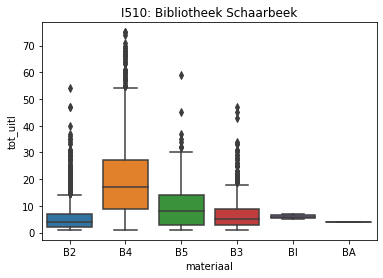

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6638.000000    6638.000000  6638.000000         I510   
mean     11.701265    2019.196143     6.599729         I510   
std      11.551880       2.831638     3.730597         I510   
min       1.000000    2001.000000     0.000000         I510   
25%       4.000000    2018.000000     4.000000         I510   
50%       8.000000    2020.000000     6.000000         I510   
75%      16.000000    2021.000000     8.000000         I510   
max      75.000000    2022.000000    21.000000         I510   

                  bibliotheek  
count  Bibliotheek Schaarbeek  
mean   Bibliotheek Schaarbeek  
std    Bibliotheek Schaarbeek  
min    Bibliotheek Schaarbeek  
25%    Bibliotheek Schaarbeek  
50%    Bibliotheek Schaarbeek  
75%    Bibliotheek Schaarbeek  
max    Bibliotheek Schaarbeek

____________________________________________________________
Bibliotheek Sint-Agatha-Berchem


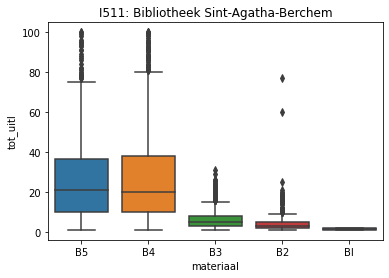

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5421.000000    5421.000000  5421.000000         I511   
mean     18.301789    2016.487179    15.094632         I511   
std      19.422522       4.529167     4.696911         I511   
min       1.000000    2001.000000     0.000000         I511   
25%       4.000000    2014.000000    12.000000         I511   
50%      11.000000    2018.000000    16.000000         I511   
75%      26.000000    2020.000000    19.000000         I511   
max     100.000000    2022.000000    22.000000         I511   

                           bibliotheek  
count  Bibliotheek Sint-Agatha-Berchem  
mean   Bibliotheek Sint-Agatha-Berchem  
std    Bibliotheek Sint-Agatha-Berchem  
min    Bibliotheek Sint-Agatha-Berchem  
25%    Bibliotheek Sint-Agatha-Berchem  
50%    Bibliotheek Sint-Agatha-Berchem  
75%    Bibliotheek Sint-Agatha-Berchem  
max    Bibliotheek Sint-Agatha-Berchem

____________________________________________________________
Bibliotheek Sint-Gillis


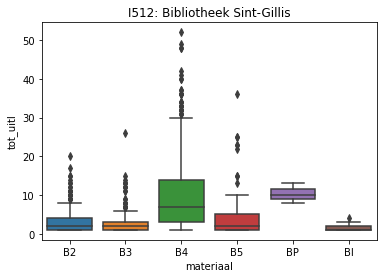

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1870.000000    1870.000000  1862.000000         I512   
mean      5.840642    2016.763102     9.624597         I512   
std       7.146353       4.623784     4.866327         I512   
min       1.000000    1995.000000     0.000000         I512   
25%       1.000000    2014.000000     6.000000         I512   
50%       3.000000    2017.000000     9.000000         I512   
75%       7.000000    2021.000000    12.000000         I512   
max      52.000000    2022.000000    27.000000         I512   

                   bibliotheek  
count  Bibliotheek Sint-Gillis  
mean   Bibliotheek Sint-Gillis  
std    Bibliotheek Sint-Gillis  
min    Bibliotheek Sint-Gillis  
25%    Bibliotheek Sint-Gillis  
50%    Bibliotheek Sint-Gillis  
75%    Bibliotheek Sint-Gillis  
max    Bibliotheek Sint-Gillis

____________________________________________________________
Bibliotheek Sint-Jans-Molenbeek


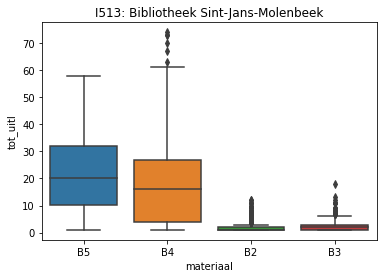

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2319.000000    2319.000000  2319.000000         I513   
mean      8.200517    2016.295386     9.205692         I513   
std      11.990465       3.693304     2.347036         I513   
min       1.000000    2009.000000     0.000000         I513   
25%       1.000000    2013.000000     8.000000         I513   
50%       2.000000    2016.000000     9.000000         I513   
75%       9.000000    2020.000000    11.000000         I513   
max      74.000000    2022.000000    15.000000         I513   

                           bibliotheek  
count  Bibliotheek Sint-Jans-Molenbeek  
mean   Bibliotheek Sint-Jans-Molenbeek  
std    Bibliotheek Sint-Jans-Molenbeek  
min    Bibliotheek Sint-Jans-Molenbeek  
25%    Bibliotheek Sint-Jans-Molenbeek  
50%    Bibliotheek Sint-Jans-Molenbeek  
75%    Bibliotheek Sint-Jans-Molenbeek  
max    Bibliotheek Sint-Jans-Molenbeek

____________________________________________________________
Bibliotheek Sint-Joost-ten-Node


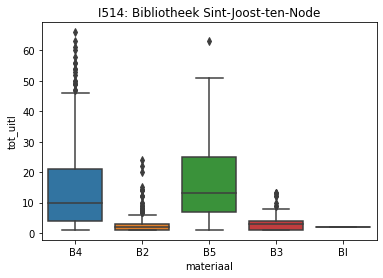

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1660.000000    1660.000000  1660.000000         I514   
mean      9.815060    2018.935542     6.289157         I514   
std      11.343405       2.510028     3.064822         I514   
min       1.000000    2011.000000     0.000000         I514   
25%       2.000000    2017.000000     4.000000         I514   
50%       5.000000    2020.000000     6.000000         I514   
75%      13.000000    2021.000000     9.000000         I514   
max      66.000000    2022.000000    12.000000         I514   

                           bibliotheek  
count  Bibliotheek Sint-Joost-ten-Node  
mean   Bibliotheek Sint-Joost-ten-Node  
std    Bibliotheek Sint-Joost-ten-Node  
min    Bibliotheek Sint-Joost-ten-Node  
25%    Bibliotheek Sint-Joost-ten-Node  
50%    Bibliotheek Sint-Joost-ten-Node  
75%    Bibliotheek Sint-Joost-ten-Node  
max    Bibliotheek Sint-Joost-ten-Node

____________________________________________________________
Bibliotheek Sint-Lambrechts-Woluwe


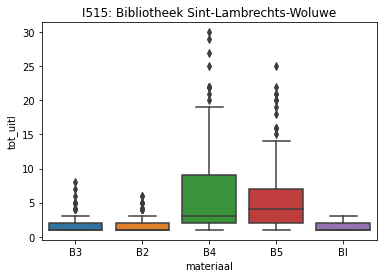

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1230.000000    1230.000000  1230.000000         I515   
mean      2.881301    2018.312195     5.765041         I515   
std       3.742383       1.820263     1.217948         I515   
min       1.000000    2015.000000     0.000000         I515   
25%       1.000000    2017.000000     6.000000         I515   
50%       2.000000    2018.000000     6.000000         I515   
75%       3.000000    2020.000000     6.000000         I515   
max      30.000000    2022.000000     7.000000         I515   

                              bibliotheek  
count  Bibliotheek Sint-Lambrechts-Woluwe  
mean   Bibliotheek Sint-Lambrechts-Woluwe  
std    Bibliotheek Sint-Lambrechts-Woluwe  
min    Bibliotheek Sint-Lambrechts-Woluwe  
25%    Bibliotheek Sint-Lambrechts-Woluwe  
50%    Bibliotheek Sint-Lambrechts-Woluwe  
75%    Bibliotheek Sint-Lambrechts-Woluwe  
max    Bibliotheek Sint-Lambrechts-Woluwe

____________________________________________________________
Bibliotheek Sint-Pieters-Woluwe


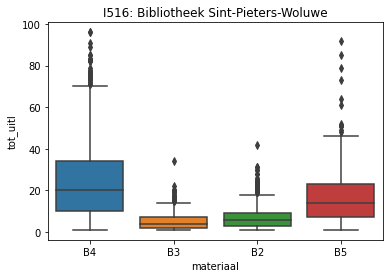

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3682.000000    3682.000000  3682.000000         I516   
mean     17.226236    2017.272949    15.620858         I516   
std      15.985345       4.214781     4.561295         I516   
min       1.000000    2004.000000     0.000000         I516   
25%       5.000000    2015.000000    14.000000         I516   
50%      12.000000    2019.000000    17.000000         I516   
75%      25.000000    2021.000000    19.000000         I516   
max      96.000000    2022.000000    21.000000         I516   

                           bibliotheek  
count  Bibliotheek Sint-Pieters-Woluwe  
mean   Bibliotheek Sint-Pieters-Woluwe  
std    Bibliotheek Sint-Pieters-Woluwe  
min    Bibliotheek Sint-Pieters-Woluwe  
25%    Bibliotheek Sint-Pieters-Woluwe  
50%    Bibliotheek Sint-Pieters-Woluwe  
75%    Bibliotheek Sint-Pieters-Woluwe  
max    Bibliotheek Sint-Pieters-Woluwe

____________________________________________________________
Bibliotheek Ukkel


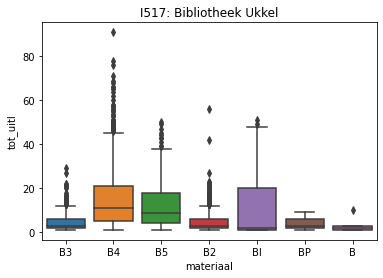

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  4271.000000    4271.000000  4271.000000         I517  Bibliotheek Ukkel
mean      8.676422    2018.656755     7.821119         I517  Bibliotheek Ukkel
std      10.094551       2.573000     3.851376         I517  Bibliotheek Ukkel
min       1.000000    2008.000000     0.000000         I517  Bibliotheek Ukkel
25%       2.000000    2017.000000     5.000000         I517  Bibliotheek Ukkel
50%       5.000000    2019.000000     8.000000         I517  Bibliotheek Ukkel
75%      11.000000    2021.000000    11.000000         I517  Bibliotheek Ukkel
max      91.000000    2022.000000    15.000000         I517  Bibliotheek Ukkel

____________________________________________________________
Bibliotheek Vorst


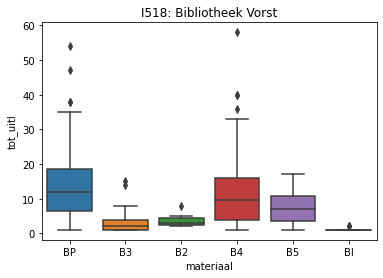

tot_uitl  ltst_jaar_uit    lft_exem instantie_id        bibliotheek
count  318.000000     318.000000  318.000000         I518  Bibliotheek Vorst
mean    10.056604    2019.915094    5.053459         I518  Bibliotheek Vorst
std      9.645610       2.106552    3.947643         I518  Bibliotheek Vorst
min      1.000000    2010.000000    0.000000         I518  Bibliotheek Vorst
25%      2.000000    2020.000000    2.000000         I518  Bibliotheek Vorst
50%      7.000000    2020.000000    5.000000         I518  Bibliotheek Vorst
75%     15.000000    2021.000000    7.000000         I518  Bibliotheek Vorst
max     58.000000    2022.000000   20.000000         I518  Bibliotheek Vorst

____________________________________________________________
Bibliotheek Watermaal-Bosvoorde


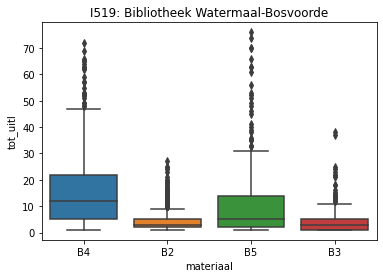

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2783.000000    2783.000000  2783.000000         I519   
mean      7.831117    2016.026949    12.745239         I519   
std      10.285127       3.523413     6.112602         I519   
min       1.000000    2003.000000     0.000000         I519   
25%       2.000000    2014.000000     8.000000         I519   
50%       4.000000    2016.000000    10.000000         I519   
75%       9.000000    2019.000000    17.000000         I519   
max      76.000000    2022.000000    26.000000         I519   

                           bibliotheek  
count  Bibliotheek Watermaal-Bosvoorde  
mean   Bibliotheek Watermaal-Bosvoorde  
std    Bibliotheek Watermaal-Bosvoorde  
min    Bibliotheek Watermaal-Bosvoorde  
25%    Bibliotheek Watermaal-Bosvoorde  
50%    Bibliotheek Watermaal-Bosvoorde  
75%    Bibliotheek Watermaal-Bosvoorde  
max    Bibliotheek Watermaal-Bosvoorde

____________________________________________________________
Bibliotheek Aarschot


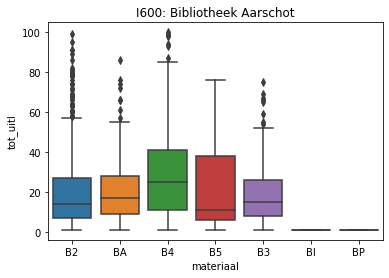

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2051.000000    2051.000000  2051.000000         I600   
mean     23.006826    2018.545588    16.046806         I600   
std      18.640448       3.899374     7.559569         I600   
min       1.000000    1994.000000     0.000000         I600   
25%       8.500000    2017.000000    11.000000         I600   
50%      18.000000    2020.000000    16.000000         I600   
75%      33.000000    2021.000000    20.000000         I600   
max     100.000000    2022.000000    40.000000         I600   

                bibliotheek  
count  Bibliotheek Aarschot  
mean   Bibliotheek Aarschot  
std    Bibliotheek Aarschot  
min    Bibliotheek Aarschot  
25%    Bibliotheek Aarschot  
50%    Bibliotheek Aarschot  
75%    Bibliotheek Aarschot  
max    Bibliotheek Aarschot

____________________________________________________________
Bibliotheek Affligem


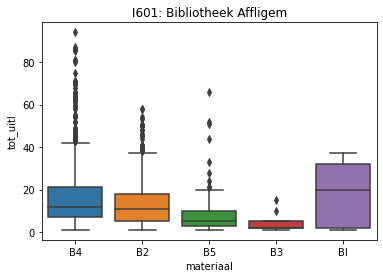

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2871.000000    2871.000000  2871.000000         I601   
mean     14.252177    2019.601533    14.508882         I601   
std      11.883632       2.069199     4.640885         I601   
min       1.000000    2012.000000     0.000000         I601   
25%       6.000000    2019.000000    12.000000         I601   
50%      11.000000    2020.000000    16.000000         I601   
75%      19.000000    2021.000000    18.000000         I601   
max      94.000000    2022.000000    20.000000         I601   

                bibliotheek  
count  Bibliotheek Affligem  
mean   Bibliotheek Affligem  
std    Bibliotheek Affligem  
min    Bibliotheek Affligem  
25%    Bibliotheek Affligem  
50%    Bibliotheek Affligem  
75%    Bibliotheek Affligem  
max    Bibliotheek Affligem

____________________________________________________________
Bibliotheek Asse


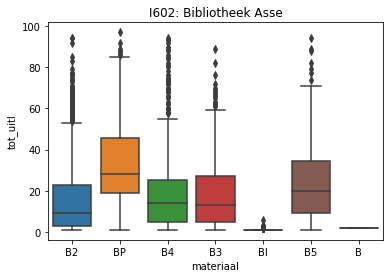

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  4980.000000    4980.000000  4980.000000         I602  Bibliotheek Asse
mean     17.555221    2018.815462     8.512450         I602  Bibliotheek Asse
std      17.483862       2.805949     2.538248         I602  Bibliotheek Asse
min       1.000000    2005.000000     0.000000         I602  Bibliotheek Asse
25%       4.000000    2017.000000     9.000000         I602  Bibliotheek Asse
50%      12.000000    2020.000000     9.000000         I602  Bibliotheek Asse
75%      26.000000    2021.000000    10.000000         I602  Bibliotheek Asse
max      97.000000    2022.000000    10.000000         I602  Bibliotheek Asse

____________________________________________________________
Bibliotheek Beersel


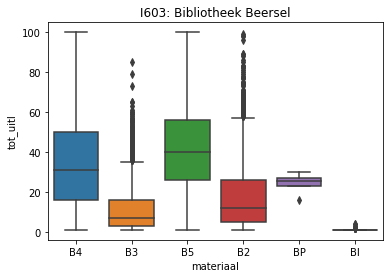

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8526.000000    8526.000000  8526.000000         I603   
mean     24.923763    2019.664438     8.828525         I603   
std      22.189370       2.676124     4.005616         I603   
min       1.000000    2005.000000     0.000000         I603   
25%       6.000000    2019.000000     6.000000         I603   
50%      19.000000    2021.000000    10.000000         I603   
75%      37.000000    2021.000000    12.000000         I603   
max     100.000000    2022.000000    13.000000         I603   

               bibliotheek  
count  Bibliotheek Beersel  
mean   Bibliotheek Beersel  
std    Bibliotheek Beersel  
min    Bibliotheek Beersel  
25%    Bibliotheek Beersel  
50%    Bibliotheek Beersel  
75%    Bibliotheek Beersel  
max    Bibliotheek Beersel

____________________________________________________________
Bibliotheek Begijnendijk


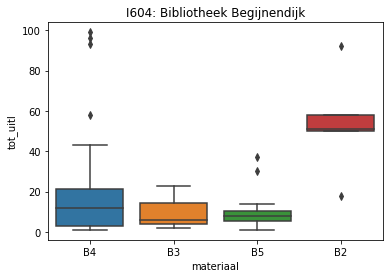

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count  90.000000      90.000000  90.000000         I604   
mean   16.955556    2018.722222   7.444444         I604   
std    21.513994       2.141237   2.796913         I604   
min     1.000000    2012.000000   0.000000         I604   
25%     3.250000    2018.000000   7.000000         I604   
50%    10.000000    2018.000000   7.000000         I604   
75%    20.750000    2020.750000   8.000000         I604   
max    99.000000    2022.000000  17.000000         I604   

                    bibliotheek  
count  Bibliotheek Begijnendijk  
mean   Bibliotheek Begijnendijk  
std    Bibliotheek Begijnendijk  
min    Bibliotheek Begijnendijk  
25%    Bibliotheek Begijnendijk  
50%    Bibliotheek Begijnendijk  
75%    Bibliotheek Begijnendijk  
max    Bibliotheek Begijnendijk

____________________________________________________________
Bibliotheek Bekkevoort


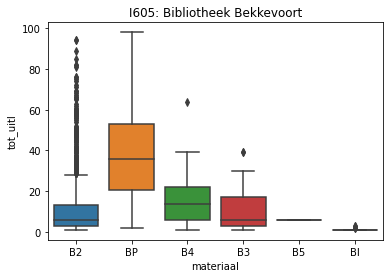

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2324.000000    2324.000000  2324.000000         I605   
mean     14.755594    2017.305938    14.354561         I605   
std      17.528934       3.690075     4.585151         I605   
min       1.000000    2010.000000     0.000000         I605   
25%       3.000000    2014.000000    12.000000         I605   
50%       8.000000    2018.000000    15.000000         I605   
75%      18.000000    2021.000000    18.000000         I605   
max      98.000000    2022.000000    21.000000         I605   

                  bibliotheek  
count  Bibliotheek Bekkevoort  
mean   Bibliotheek Bekkevoort  
std    Bibliotheek Bekkevoort  
min    Bibliotheek Bekkevoort  
25%    Bibliotheek Bekkevoort  
50%    Bibliotheek Bekkevoort  
75%    Bibliotheek Bekkevoort  
max    Bibliotheek Bekkevoort

____________________________________________________________
Bibliotheek Bertem


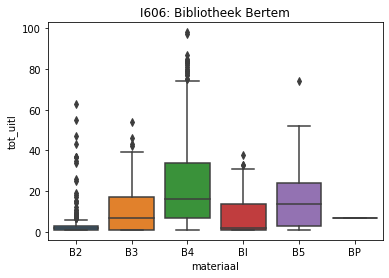

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1590.000000    1590.000000  1590.000000         I606   
mean     15.211950    2019.301258     7.998742         I606   
std      18.260433       2.720305     2.620776         I606   
min       1.000000    2012.000000     0.000000         I606   
25%       2.000000    2017.000000     8.000000         I606   
50%       7.000000    2021.000000     9.000000         I606   
75%      22.000000    2021.000000    10.000000         I606   
max      98.000000    2022.000000    10.000000         I606   

              bibliotheek  
count  Bibliotheek Bertem  
mean   Bibliotheek Bertem  
std    Bibliotheek Bertem  
min    Bibliotheek Bertem  
25%    Bibliotheek Bertem  
50%    Bibliotheek Bertem  
75%    Bibliotheek Bertem  
max    Bibliotheek Bertem

____________________________________________________________
Bibliotheek Bierbeek


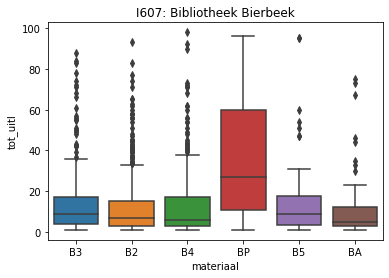

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1818.000000    1818.000000  1818.000000         I607   
mean     13.557206    2016.298680    11.314631         I607   
std      16.412952       4.051595     2.945667         I607   
min       1.000000    2005.000000     0.000000         I607   
25%       3.000000    2013.000000    11.000000         I607   
50%       8.000000    2017.000000    13.000000         I607   
75%      17.000000    2020.000000    13.000000         I607   
max      98.000000    2022.000000    13.000000         I607   

                bibliotheek  
count  Bibliotheek Bierbeek  
mean   Bibliotheek Bierbeek  
std    Bibliotheek Bierbeek  
min    Bibliotheek Bierbeek  
25%    Bibliotheek Bierbeek  
50%    Bibliotheek Bierbeek  
75%    Bibliotheek Bierbeek  
max    Bibliotheek Bierbeek

____________________________________________________________
Bibliotheek Diest


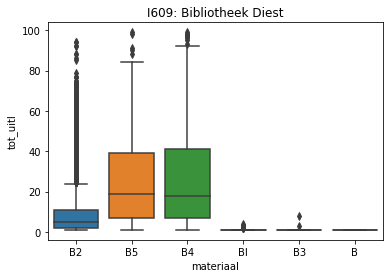

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  9875.000000    9875.000000  9875.000000         I609  Bibliotheek Diest
mean     12.723443    2017.140152     9.663595         I609  Bibliotheek Diest
std      16.454963       3.559615     4.084018         I609  Bibliotheek Diest
min       1.000000    2005.000000     0.000000         I609  Bibliotheek Diest
25%       3.000000    2015.000000     6.000000         I609  Bibliotheek Diest
50%       6.000000    2018.000000    12.000000         I609  Bibliotheek Diest
75%      15.000000    2020.000000    13.000000         I609  Bibliotheek Diest
max      99.000000    2022.000000    13.000000         I609  Bibliotheek Diest

____________________________________________________________
Bibliotheek Dilbeek


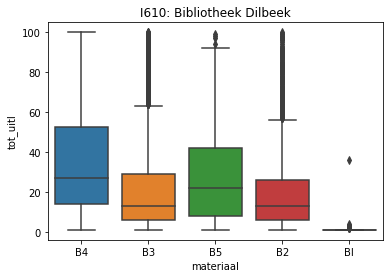

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9873.000000    9873.000000  9873.000000         I610   
mean     22.775448    2018.626456     9.516358         I610   
std      22.167380       2.973416     3.817499         I610   
min       1.000000    2005.000000     0.000000         I610   
25%       6.000000    2017.000000     7.000000         I610   
50%      15.000000    2019.000000     9.000000         I610   
75%      32.000000    2021.000000    13.000000         I610   
max     100.000000    2022.000000    15.000000         I610   

               bibliotheek  
count  Bibliotheek Dilbeek  
mean   Bibliotheek Dilbeek  
std    Bibliotheek Dilbeek  
min    Bibliotheek Dilbeek  
25%    Bibliotheek Dilbeek  
50%    Bibliotheek Dilbeek  
75%    Bibliotheek Dilbeek  
max    Bibliotheek Dilbeek

____________________________________________________________
Bibliotheek Galmaarden


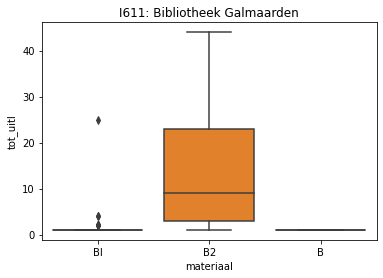

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count  54.000000      54.000000  54.000000         I611   
mean    5.277778    2020.962963   1.648148         I611   
std     9.641531       1.345334   2.578265         I611   
min     1.000000    2016.000000   0.000000         I611   
25%     1.000000    2021.000000   0.000000         I611   
50%     1.000000    2021.000000   0.000000         I611   
75%     3.000000    2022.000000   5.000000         I611   
max    44.000000    2022.000000   6.000000         I611   

                  bibliotheek  
count  Bibliotheek Galmaarden  
mean   Bibliotheek Galmaarden  
std    Bibliotheek Galmaarden  
min    Bibliotheek Galmaarden  
25%    Bibliotheek Galmaarden  
50%    Bibliotheek Galmaarden  
75%    Bibliotheek Galmaarden  
max    Bibliotheek Galmaarden

____________________________________________________________
Bibliotheek Geetbets


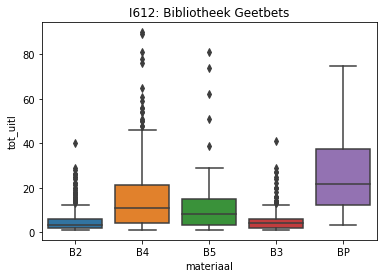

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1413.000000    1413.000000  1413.000000         I612   
mean      9.150035    2017.296532    10.098372         I612   
std      11.749034       3.499570     4.447150         I612   
min       1.000000    2005.000000     0.000000         I612   
25%       2.000000    2015.000000    10.000000         I612   
50%       5.000000    2018.000000    12.000000         I612   
75%      11.000000    2020.000000    13.000000         I612   
max      90.000000    2022.000000    14.000000         I612   

                bibliotheek  
count  Bibliotheek Geetbets  
mean   Bibliotheek Geetbets  
std    Bibliotheek Geetbets  
min    Bibliotheek Geetbets  
25%    Bibliotheek Geetbets  
50%    Bibliotheek Geetbets  
75%    Bibliotheek Geetbets  
max    Bibliotheek Geetbets

____________________________________________________________
Bibliotheek Glabbeek


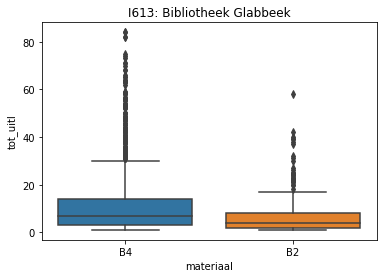

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2185.000000    2185.000000  2185.000000         I613   
mean     10.311213    2016.201373    10.228833         I613   
std      11.897232       3.316583     2.547855         I613   
min       1.000000    2010.000000     0.000000         I613   
25%       3.000000    2014.000000     9.000000         I613   
50%       6.000000    2016.000000    11.000000         I613   
75%      13.000000    2019.000000    12.000000         I613   
max      84.000000    2022.000000    12.000000         I613   

                bibliotheek  
count  Bibliotheek Glabbeek  
mean   Bibliotheek Glabbeek  
std    Bibliotheek Glabbeek  
min    Bibliotheek Glabbeek  
25%    Bibliotheek Glabbeek  
50%    Bibliotheek Glabbeek  
75%    Bibliotheek Glabbeek  
max    Bibliotheek Glabbeek

____________________________________________________________
Bibliotheek Gooik


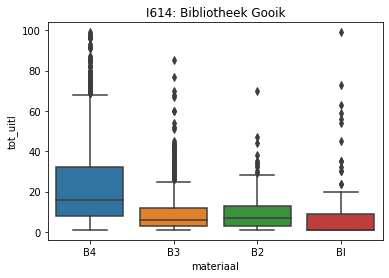

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  2601.000000    2601.000000  2601.000000         I614  Bibliotheek Gooik
mean     16.223760    2017.975779     9.908497         I614  Bibliotheek Gooik
std      17.883617       2.984284     2.553295         I614  Bibliotheek Gooik
min       1.000000    2010.000000     0.000000         I614  Bibliotheek Gooik
25%       4.000000    2016.000000     9.000000         I614  Bibliotheek Gooik
50%      10.000000    2018.000000    11.000000         I614  Bibliotheek Gooik
75%      21.000000    2020.000000    12.000000         I614  Bibliotheek Gooik
max      99.000000    2022.000000    12.000000         I614  Bibliotheek Gooik

____________________________________________________________
Bibliotheek Grimbergen


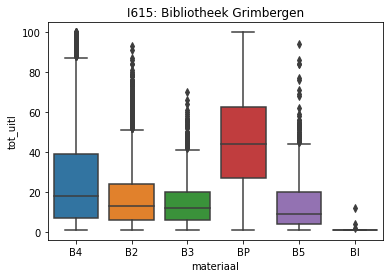

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  9278.000000    9278.000000  9278.000000         I615   
mean     21.986958    2019.242833     8.026945         I615   
std      20.704847       2.151077     2.575983         I615   
min       1.000000    2005.000000     0.000000         I615   
25%       7.000000    2018.000000     7.000000         I615   
50%      15.000000    2020.000000     9.000000         I615   
75%      31.000000    2021.000000    10.000000         I615   
max     100.000000    2022.000000    10.000000         I615   

                  bibliotheek  
count  Bibliotheek Grimbergen  
mean   Bibliotheek Grimbergen  
std    Bibliotheek Grimbergen  
min    Bibliotheek Grimbergen  
25%    Bibliotheek Grimbergen  
50%    Bibliotheek Grimbergen  
75%    Bibliotheek Grimbergen  
max    Bibliotheek Grimbergen

____________________________________________________________
Bibliotheek Halle


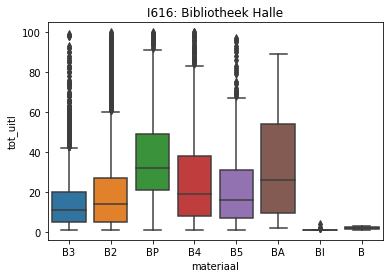

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  15580.000000   15580.000000  15580.000000         I616   
mean      20.444095    2017.668164     11.111874         I616   
std       19.195375       3.785171      3.206903         I616   
min        1.000000    2005.000000      0.000000         I616   
25%        6.000000    2016.000000      9.000000         I616   
50%       14.000000    2019.000000     12.000000         I616   
75%       29.000000    2020.000000     14.000000         I616   
max      100.000000    2022.000000     15.000000         I616   

             bibliotheek  
count  Bibliotheek Halle  
mean   Bibliotheek Halle  
std    Bibliotheek Halle  
min    Bibliotheek Halle  
25%    Bibliotheek Halle  
50%    Bibliotheek Halle  
75%    Bibliotheek Halle  
max    Bibliotheek Halle

____________________________________________________________
Bibliotheek HaBoBIB


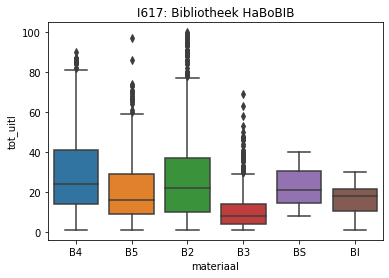

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3701.000000    3701.000000  3700.000000         I617   
mean     21.960821    2019.077817    11.202162         I617   
std      18.686339       3.048508     4.357838         I617   
min       1.000000    2001.000000     0.000000         I617   
25%       8.000000    2018.000000     8.000000         I617   
50%      17.000000    2020.000000    11.000000         I617   
75%      31.000000    2021.000000    13.000000         I617   
max     100.000000    2022.000000    28.000000         I617   

               bibliotheek  
count  Bibliotheek HaBoBIB  
mean   Bibliotheek HaBoBIB  
std    Bibliotheek HaBoBIB  
min    Bibliotheek HaBoBIB  
25%    Bibliotheek HaBoBIB  
50%    Bibliotheek HaBoBIB  
75%    Bibliotheek HaBoBIB  
max    Bibliotheek HaBoBIB

____________________________________________________________
Bibliotheek Herent


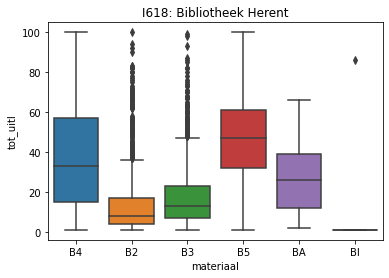

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4535.000000    4535.000000  4535.000000         I618   
mean     23.689526    2018.644101     9.713561         I618   
std      22.692498       3.306354     3.471508         I618   
min       1.000000    2008.000000     0.000000         I618   
25%       6.000000    2017.000000     7.000000         I618   
50%      15.000000    2020.000000    10.000000         I618   
75%      35.000000    2021.000000    13.000000         I618   
max     100.000000    2022.000000    14.000000         I618   

              bibliotheek  
count  Bibliotheek Herent  
mean   Bibliotheek Herent  
std    Bibliotheek Herent  
min    Bibliotheek Herent  
25%    Bibliotheek Herent  
50%    Bibliotheek Herent  
75%    Bibliotheek Herent  
max    Bibliotheek Herent

____________________________________________________________
Bibliotheek Herne


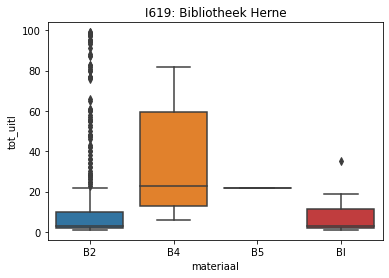

tot_uitl  ltst_jaar_uit    lft_exem instantie_id        bibliotheek
count  469.000000     469.000000  469.000000         I619  Bibliotheek Herne
mean    14.364606    2019.215352    5.268657         I619  Bibliotheek Herne
std     23.823633       1.729118    3.812415         I619  Bibliotheek Herne
min      1.000000    2009.000000    0.000000         I619  Bibliotheek Herne
25%      2.000000    2018.000000    2.000000         I619  Bibliotheek Herne
50%      3.000000    2019.000000    4.000000         I619  Bibliotheek Herne
75%     13.000000    2020.000000    8.000000         I619  Bibliotheek Herne
max     99.000000    2022.000000   13.000000         I619  Bibliotheek Herne

____________________________________________________________
Bibliotheek Hoeilaart


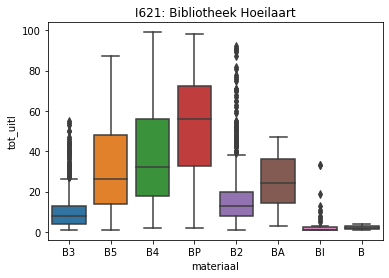

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2404.000000    2404.000000  2404.000000         I621   
mean     19.120216    2019.667221    10.725874         I621   
std      19.725522       2.307218     6.731160         I621   
min       1.000000    2010.000000     0.000000         I621   
25%       6.000000    2018.000000     5.000000         I621   
50%      12.000000    2020.000000    10.000000         I621   
75%      23.000000    2022.000000    15.000000         I621   
max      99.000000    2022.000000    25.000000         I621   

                 bibliotheek  
count  Bibliotheek Hoeilaart  
mean   Bibliotheek Hoeilaart  
std    Bibliotheek Hoeilaart  
min    Bibliotheek Hoeilaart  
25%    Bibliotheek Hoeilaart  
50%    Bibliotheek Hoeilaart  
75%    Bibliotheek Hoeilaart  
max    Bibliotheek Hoeilaart

____________________________________________________________
Bibliotheek Holsbeek


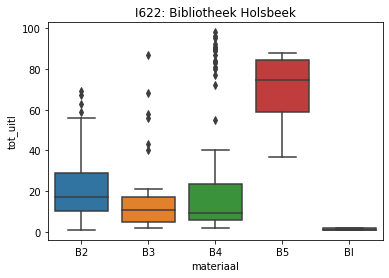

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  255.000000     255.000000  255.000000         I622   
mean    21.862745    2020.352941    9.113725         I622   
std     23.733112       2.489533    8.484284         I622   
min      1.000000    2011.000000    0.000000         I622   
25%      6.000000    2019.000000    1.000000         I622   
50%     14.000000    2022.000000    7.000000         I622   
75%     27.500000    2022.000000   17.000000         I622   
max     98.000000    2022.000000   25.000000         I622   

                bibliotheek  
count  Bibliotheek Holsbeek  
mean   Bibliotheek Holsbeek  
std    Bibliotheek Holsbeek  
min    Bibliotheek Holsbeek  
25%    Bibliotheek Holsbeek  
50%    Bibliotheek Holsbeek  
75%    Bibliotheek Holsbeek  
max    Bibliotheek Holsbeek

____________________________________________________________
Bibliotheek Huldenberg


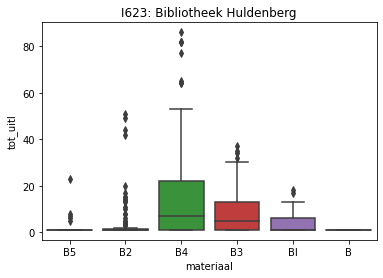

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  454.000000     454.000000  454.000000         I623   
mean     8.947137    2017.262115    9.107930         I623   
std     14.368897       3.500807    3.697058         I623   
min      1.000000    2012.000000    0.000000         I623   
25%      1.000000    2014.000000    7.000000         I623   
50%      1.000000    2017.000000   10.000000         I623   
75%     11.000000    2021.000000   12.000000         I623   
max     86.000000    2022.000000   14.000000         I623   

                  bibliotheek  
count  Bibliotheek Huldenberg  
mean   Bibliotheek Huldenberg  
std    Bibliotheek Huldenberg  
min    Bibliotheek Huldenberg  
25%    Bibliotheek Huldenberg  
50%    Bibliotheek Huldenberg  
75%    Bibliotheek Huldenberg  
max    Bibliotheek Huldenberg

____________________________________________________________
Bibliotheek Kampenhout


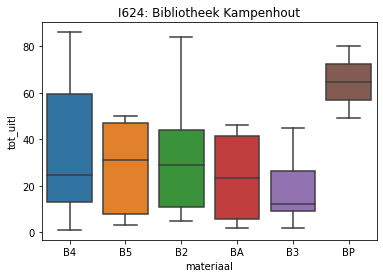

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count  65.000000      65.000000  65.000000         I624   
mean   29.923077    2020.938462  11.276923         I624   
std    23.810651       1.666554   6.596656         I624   
min     1.000000    2016.000000   0.000000         I624   
25%     9.000000    2020.000000   8.000000         I624   
50%    25.000000    2022.000000  11.000000         I624   
75%    46.000000    2022.000000  16.000000         I624   
max    86.000000    2022.000000  25.000000         I624   

                  bibliotheek  
count  Bibliotheek Kampenhout  
mean   Bibliotheek Kampenhout  
std    Bibliotheek Kampenhout  
min    Bibliotheek Kampenhout  
25%    Bibliotheek Kampenhout  
50%    Bibliotheek Kampenhout  
75%    Bibliotheek Kampenhout  
max    Bibliotheek Kampenhout

____________________________________________________________
Bibliotheek Kapelle-op-den-Bos


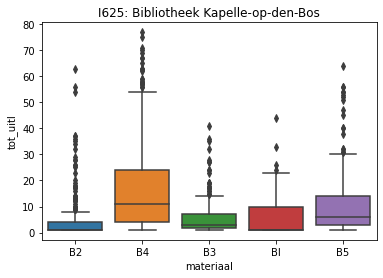

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1825.000000    1825.000000  1825.000000         I625   
mean     11.655342    2019.406027     4.896438         I625   
std      13.576703       1.854956     1.446303         I625   
min       1.000000    2015.000000     0.000000         I625   
25%       2.000000    2018.000000     5.000000         I625   
50%       6.000000    2020.000000     5.000000         I625   
75%      17.000000    2021.000000     6.000000         I625   
max      77.000000    2022.000000     6.000000         I625   

                          bibliotheek  
count  Bibliotheek Kapelle-op-den-Bos  
mean   Bibliotheek Kapelle-op-den-Bos  
std    Bibliotheek Kapelle-op-den-Bos  
min    Bibliotheek Kapelle-op-den-Bos  
25%    Bibliotheek Kapelle-op-den-Bos  
50%    Bibliotheek Kapelle-op-den-Bos  
75%    Bibliotheek Kapelle-op-den-Bos  
max    Bibliotheek Kapelle-op-den-Bos

____________________________________________________________
Bibliotheek Keerbergen


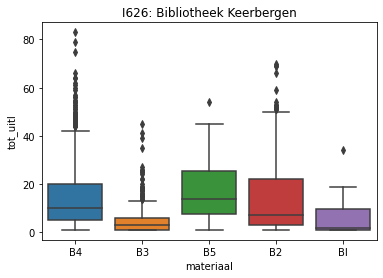

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1757.000000    1757.000000  1757.000000         I626   
mean     11.211725    2019.602163     6.081389         I626   
std      12.971522       1.860896     1.282740         I626   
min       1.000000    2005.000000     0.000000         I626   
25%       2.000000    2019.000000     6.000000         I626   
50%       6.000000    2020.000000     6.000000         I626   
75%      14.000000    2021.000000     7.000000         I626   
max      83.000000    2022.000000     7.000000         I626   

                  bibliotheek  
count  Bibliotheek Keerbergen  
mean   Bibliotheek Keerbergen  
std    Bibliotheek Keerbergen  
min    Bibliotheek Keerbergen  
25%    Bibliotheek Keerbergen  
50%    Bibliotheek Keerbergen  
75%    Bibliotheek Keerbergen  
max    Bibliotheek Keerbergen

____________________________________________________________
Bibliotheek Kortenaken


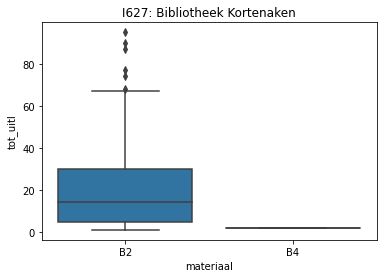

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  201.000000     201.000000  201.000000         I627   
mean    21.039801    2020.119403    6.388060         I627   
std     20.350145       1.508533    3.650843         I627   
min      1.000000    2014.000000    0.000000         I627   
25%      5.000000    2019.000000    2.000000         I627   
50%     14.000000    2020.000000    9.000000         I627   
75%     30.000000    2021.000000   10.000000         I627   
max     95.000000    2022.000000   10.000000         I627   

                  bibliotheek  
count  Bibliotheek Kortenaken  
mean   Bibliotheek Kortenaken  
std    Bibliotheek Kortenaken  
min    Bibliotheek Kortenaken  
25%    Bibliotheek Kortenaken  
50%    Bibliotheek Kortenaken  
75%    Bibliotheek Kortenaken  
max    Bibliotheek Kortenaken

____________________________________________________________
Bibliotheek Kortenberg


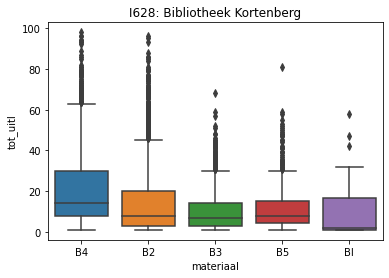

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6008.000000    6008.000000  6008.000000         I628   
mean     15.684587    2019.655293     5.528129         I628   
std      16.026111       1.663718     1.146883         I628   
min       1.000000    2015.000000     0.000000         I628   
25%       4.000000    2019.000000     5.000000         I628   
50%      10.000000    2020.000000     6.000000         I628   
75%      21.000000    2021.000000     6.000000         I628   
max      98.000000    2022.000000     7.000000         I628   

                  bibliotheek  
count  Bibliotheek Kortenberg  
mean   Bibliotheek Kortenberg  
std    Bibliotheek Kortenberg  
min    Bibliotheek Kortenberg  
25%    Bibliotheek Kortenberg  
50%    Bibliotheek Kortenberg  
75%    Bibliotheek Kortenberg  
max    Bibliotheek Kortenberg

____________________________________________________________
Bibliotheek Kraainem


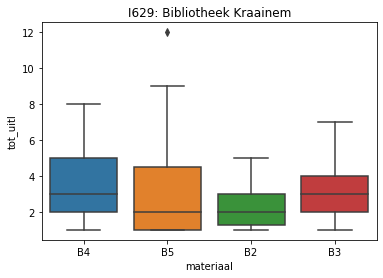

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  153.000000     153.000000  153.000000         I629   
mean     3.366013    2021.640523    0.849673         I629   
std      2.184731       0.481423    0.358565         I629   
min      1.000000    2021.000000    0.000000         I629   
25%      2.000000    2021.000000    1.000000         I629   
50%      3.000000    2022.000000    1.000000         I629   
75%      5.000000    2022.000000    1.000000         I629   
max     12.000000    2022.000000    1.000000         I629   

                bibliotheek  
count  Bibliotheek Kraainem  
mean   Bibliotheek Kraainem  
std    Bibliotheek Kraainem  
min    Bibliotheek Kraainem  
25%    Bibliotheek Kraainem  
50%    Bibliotheek Kraainem  
75%    Bibliotheek Kraainem  
max    Bibliotheek Kraainem

____________________________________________________________
Bibliotheek Landen


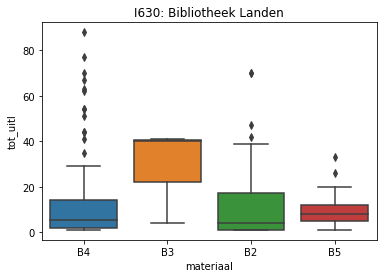

tot_uitl  ltst_jaar_uit    lft_exem instantie_id         bibliotheek
count  240.000000     240.000000  240.000000         I630  Bibliotheek Landen
mean    11.454167    2019.550000   12.141667         I630  Bibliotheek Landen
std     15.192970       2.290055    6.400570         I630  Bibliotheek Landen
min      1.000000    2014.000000    0.000000         I630  Bibliotheek Landen
25%      3.000000    2018.000000    8.000000         I630  Bibliotheek Landen
50%      6.000000    2020.000000   14.000000         I630  Bibliotheek Landen
75%     14.000000    2021.000000   18.000000         I630  Bibliotheek Landen
max     88.000000    2022.000000   21.000000         I630  Bibliotheek Landen

____________________________________________________________
Bibliotheek Lennik


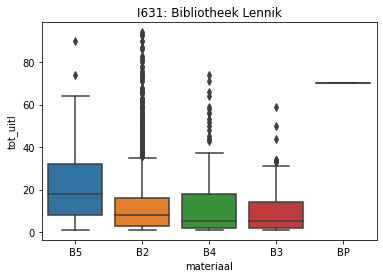

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1898.000000    1898.000000  1898.000000         I631   
mean     13.651212    2015.860379    13.008430         I631   
std      15.963967       4.460569     2.924265         I631   
min       1.000000    2007.000000     0.000000         I631   
25%       3.000000    2012.000000    13.000000         I631   
50%       8.000000    2017.000000    14.000000         I631   
75%      17.000000    2019.000000    15.000000         I631   
max      94.000000    2022.000000    15.000000         I631   

              bibliotheek  
count  Bibliotheek Lennik  
mean   Bibliotheek Lennik  
std    Bibliotheek Lennik  
min    Bibliotheek Lennik  
25%    Bibliotheek Lennik  
50%    Bibliotheek Lennik  
75%    Bibliotheek Lennik  
max    Bibliotheek Lennik

____________________________________________________________
Bibliotheek Leuven


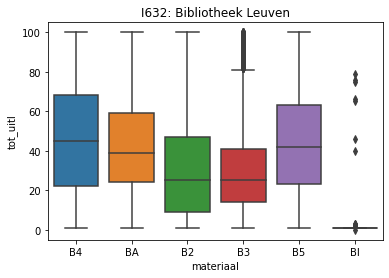

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  24526.000000   24526.000000  17962.00000         I632   
mean      35.246351    2019.474843      7.60873         I632   
std       26.014895       2.263516      4.61521         I632   
min        0.000000    2005.000000      0.00000         I632   
25%       13.000000    2018.000000      4.00000         I632   
50%       30.000000    2020.000000      8.00000         I632   
75%       53.000000    2021.000000     12.00000         I632   
max      100.000000    2022.000000     16.00000         I632   

              bibliotheek  
count  Bibliotheek Leuven  
mean   Bibliotheek Leuven  
std    Bibliotheek Leuven  
min    Bibliotheek Leuven  
25%    Bibliotheek Leuven  
50%    Bibliotheek Leuven  
75%    Bibliotheek Leuven  
max    Bibliotheek Leuven

____________________________________________________________
Bibliotheek Liedekerke


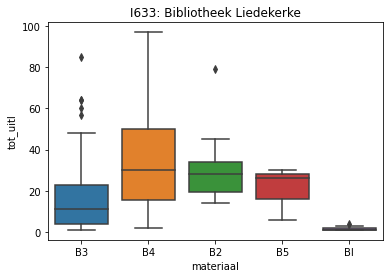

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  240.000000     240.000000  238.000000         I633   
mean    21.516667    2020.879167    6.983193         I633   
std     21.201754       2.523111    4.746721         I633   
min      1.000000    1999.000000    0.000000         I633   
25%      4.000000    2021.000000    4.000000         I633   
50%     15.500000    2022.000000    6.000000         I633   
75%     32.000000    2022.000000   10.000000         I633   
max     97.000000    2022.000000   19.000000         I633   

                  bibliotheek  
count  Bibliotheek Liedekerke  
mean   Bibliotheek Liedekerke  
std    Bibliotheek Liedekerke  
min    Bibliotheek Liedekerke  
25%    Bibliotheek Liedekerke  
50%    Bibliotheek Liedekerke  
75%    Bibliotheek Liedekerke  
max    Bibliotheek Liedekerke

____________________________________________________________
Bibliotheek Linkebeek


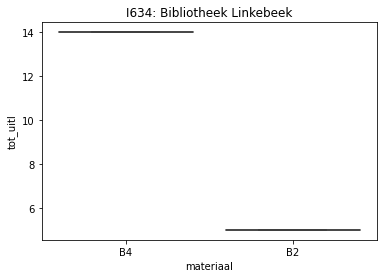

tot_uitl  ltst_jaar_uit   lft_exem instantie_id            bibliotheek
count   2.000000            2.0   2.000000         I634  Bibliotheek Linkebeek
mean    9.500000         2022.0   9.500000         I634  Bibliotheek Linkebeek
std     6.363961            0.0  13.435029         I634  Bibliotheek Linkebeek
min     5.000000         2022.0   0.000000         I634  Bibliotheek Linkebeek
25%     7.250000         2022.0   4.750000         I634  Bibliotheek Linkebeek
50%     9.500000         2022.0   9.500000         I634  Bibliotheek Linkebeek
75%    11.750000         2022.0  14.250000         I634  Bibliotheek Linkebeek
max    14.000000         2022.0  19.000000         I634  Bibliotheek Linkebeek

____________________________________________________________
Bibliotheek Linter


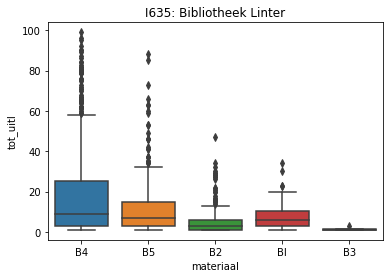

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1715.000000    1715.000000  1715.000000         I635   
mean     11.962682    2017.088630    12.309621         I635   
std      16.908457       4.011981     2.282114         I635   
min       1.000000    2005.000000     0.000000         I635   
25%       2.000000    2014.000000    12.000000         I635   
50%       5.000000    2018.000000    13.000000         I635   
75%      13.000000    2021.000000    13.000000         I635   
max      99.000000    2022.000000    14.000000         I635   

              bibliotheek  
count  Bibliotheek Linter  
mean   Bibliotheek Linter  
std    Bibliotheek Linter  
min    Bibliotheek Linter  
25%    Bibliotheek Linter  
50%    Bibliotheek Linter  
75%    Bibliotheek Linter  
max    Bibliotheek Linter

____________________________________________________________
Bibliotheek Londerzeel


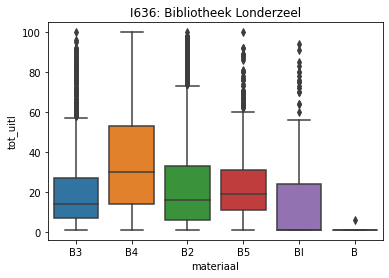

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  10271.000000   10271.000000  10271.000000         I636   
mean      24.999611    2018.011586     12.268328         I636   
std       22.018563       3.753552      3.831435         I636   
min        1.000000    2005.000000      0.000000         I636   
25%        8.000000    2016.000000     10.000000         I636   
50%       18.000000    2019.000000     14.000000         I636   
75%       36.000000    2021.000000     15.000000         I636   
max      100.000000    2022.000000     16.000000         I636   

                  bibliotheek  
count  Bibliotheek Londerzeel  
mean   Bibliotheek Londerzeel  
std    Bibliotheek Londerzeel  
min    Bibliotheek Londerzeel  
25%    Bibliotheek Londerzeel  
50%    Bibliotheek Londerzeel  
75%    Bibliotheek Londerzeel  
max    Bibliotheek Londerzeel

____________________________________________________________
Bibliotheek Lubbeek


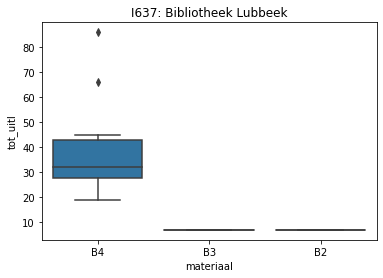

tot_uitl  ltst_jaar_uit   lft_exem instantie_id          bibliotheek
count  15.000000      15.000000  15.000000         I637  Bibliotheek Lubbeek
mean   32.466667    2021.400000  12.866667         I637  Bibliotheek Lubbeek
std    21.589901       0.828079   6.674757         I637  Bibliotheek Lubbeek
min     7.000000    2019.000000   0.000000         I637  Bibliotheek Lubbeek
25%    21.000000    2021.000000   8.000000         I637  Bibliotheek Lubbeek
50%    30.000000    2022.000000  14.000000         I637  Bibliotheek Lubbeek
75%    39.000000    2022.000000  18.500000         I637  Bibliotheek Lubbeek
max    86.000000    2022.000000  21.000000         I637  Bibliotheek Lubbeek

____________________________________________________________
Bibliotheek Machelen


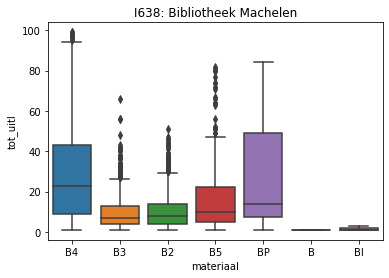

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4117.000000    4117.000000  4117.000000         I638   
mean     17.968424    2017.190673    11.863250         I638   
std      18.776885       3.731362     3.224361         I638   
min       1.000000    2007.000000     0.000000         I638   
25%       5.000000    2015.000000    10.000000         I638   
50%      11.000000    2018.000000    13.000000         I638   
75%      24.000000    2020.000000    14.000000         I638   
max      99.000000    2022.000000    15.000000         I638   

                bibliotheek  
count  Bibliotheek Machelen  
mean   Bibliotheek Machelen  
std    Bibliotheek Machelen  
min    Bibliotheek Machelen  
25%    Bibliotheek Machelen  
50%    Bibliotheek Machelen  
75%    Bibliotheek Machelen  
max    Bibliotheek Machelen

____________________________________________________________
Bibliotheek Meise


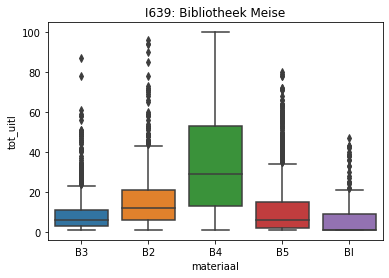

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  5264.000000    5264.000000  5264.000000         I639  Bibliotheek Meise
mean     17.022986    2018.196998    10.722834         I639  Bibliotheek Meise
std      19.346890       3.042504     3.152125         I639  Bibliotheek Meise
min       1.000000    2005.000000     0.000000         I639  Bibliotheek Meise
25%       4.000000    2017.000000    11.000000         I639  Bibliotheek Meise
50%       9.000000    2019.000000    12.000000         I639  Bibliotheek Meise
75%      23.000000    2021.000000    12.000000         I639  Bibliotheek Meise
max     100.000000    2022.000000    13.000000         I639  Bibliotheek Meise

____________________________________________________________
Bibliotheek Merchtem


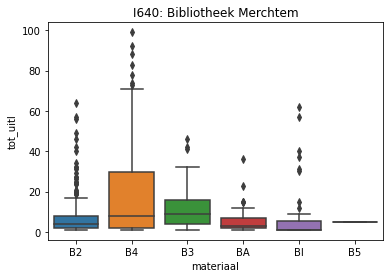

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  835.000000     835.000000  835.000000         I640   
mean    12.634731    2019.233533    6.657485         I640   
std     15.881213       2.207319    2.648931         I640   
min      1.000000    2014.000000    0.000000         I640   
25%      2.000000    2018.000000    7.000000         I640   
50%      6.000000    2020.000000    8.000000         I640   
75%     17.000000    2021.000000    8.000000         I640   
max     99.000000    2022.000000    8.000000         I640   

                bibliotheek  
count  Bibliotheek Merchtem  
mean   Bibliotheek Merchtem  
std    Bibliotheek Merchtem  
min    Bibliotheek Merchtem  
25%    Bibliotheek Merchtem  
50%    Bibliotheek Merchtem  
75%    Bibliotheek Merchtem  
max    Bibliotheek Merchtem

____________________________________________________________
Bibliotheek Opwijk


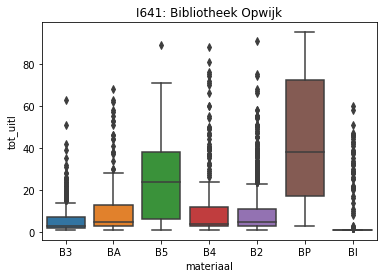

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3562.000000    3562.000000  3562.000000         I641   
mean      8.186131    2016.893318    10.525267         I641   
std      11.662405       4.091466     4.555016         I641   
min       1.000000    2005.000000     0.000000         I641   
25%       2.000000    2014.000000    12.000000         I641   
50%       4.000000    2018.000000    13.000000         I641   
75%       9.000000    2021.000000    13.000000         I641   
max      95.000000    2022.000000    13.000000         I641   

              bibliotheek  
count  Bibliotheek Opwijk  
mean   Bibliotheek Opwijk  
std    Bibliotheek Opwijk  
min    Bibliotheek Opwijk  
25%    Bibliotheek Opwijk  
50%    Bibliotheek Opwijk  
75%    Bibliotheek Opwijk  
max    Bibliotheek Opwijk

____________________________________________________________
Bibliotheek Oud-Heverlee


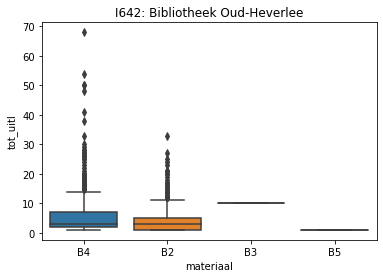

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2107.000000    2107.000000  2107.000000         I642   
mean      4.276697    2019.305173     4.351685         I642   
std       4.909711       1.406938     0.632456         I642   
min       1.000000    2017.000000     0.000000         I642   
25%       1.000000    2018.000000     4.000000         I642   
50%       3.000000    2019.000000     4.000000         I642   
75%       5.000000    2020.000000     5.000000         I642   
max      68.000000    2022.000000     5.000000         I642   

                    bibliotheek  
count  Bibliotheek Oud-Heverlee  
mean   Bibliotheek Oud-Heverlee  
std    Bibliotheek Oud-Heverlee  
min    Bibliotheek Oud-Heverlee  
25%    Bibliotheek Oud-Heverlee  
50%    Bibliotheek Oud-Heverlee  
75%    Bibliotheek Oud-Heverlee  
max    Bibliotheek Oud-Heverlee

____________________________________________________________
Bibliotheek Overijse


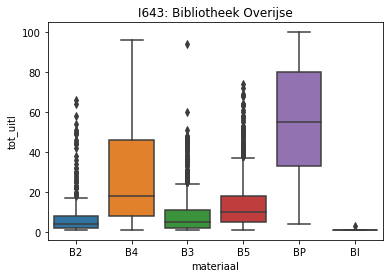

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3114.000000    3114.000000  3114.000000         I643   
mean     19.473025    2019.675016    15.215478         I643   
std      22.410820       2.507753     6.275514         I643   
min       1.000000    2012.000000     0.000000         I643   
25%       4.000000    2018.000000    10.000000         I643   
50%      10.000000    2021.000000    16.000000         I643   
75%      26.000000    2022.000000    21.000000         I643   
max     100.000000    2022.000000    24.000000         I643   

                bibliotheek  
count  Bibliotheek Overijse  
mean   Bibliotheek Overijse  
std    Bibliotheek Overijse  
min    Bibliotheek Overijse  
25%    Bibliotheek Overijse  
50%    Bibliotheek Overijse  
75%    Bibliotheek Overijse  
max    Bibliotheek Overijse

____________________________________________________________
Bibliotheek Pepingen


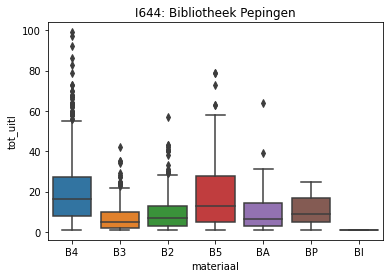

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1916.000000    1916.000000  1916.000000         I644   
mean     12.980689    2017.172756    12.459812         I644   
std      13.676384       3.732842     2.723067         I644   
min       1.000000    2005.000000     0.000000         I644   
25%       4.000000    2015.000000    13.000000         I644   
50%       9.000000    2018.000000    13.000000         I644   
75%      17.000000    2020.000000    14.000000         I644   
max      99.000000    2022.000000    14.000000         I644   

                bibliotheek  
count  Bibliotheek Pepingen  
mean   Bibliotheek Pepingen  
std    Bibliotheek Pepingen  
min    Bibliotheek Pepingen  
25%    Bibliotheek Pepingen  
50%    Bibliotheek Pepingen  
75%    Bibliotheek Pepingen  
max    Bibliotheek Pepingen

____________________________________________________________
Bibliotheek Roosdaal


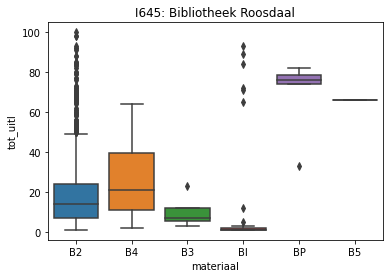

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1670.000000    1670.000000  1670.000000         I645   
mean     17.587425    2017.828144    10.134132         I645   
std      17.406650       2.570245     3.901572         I645   
min       1.000000    2009.000000     0.000000         I645   
25%       5.000000    2017.000000     9.000000         I645   
50%      13.000000    2018.000000    12.000000         I645   
75%      23.000000    2019.000000    13.000000         I645   
max     100.000000    2022.000000    13.000000         I645   

                bibliotheek  
count  Bibliotheek Roosdaal  
mean   Bibliotheek Roosdaal  
std    Bibliotheek Roosdaal  
min    Bibliotheek Roosdaal  
25%    Bibliotheek Roosdaal  
50%    Bibliotheek Roosdaal  
75%    Bibliotheek Roosdaal  
max    Bibliotheek Roosdaal

____________________________________________________________
Bibliotheek Rotselaar


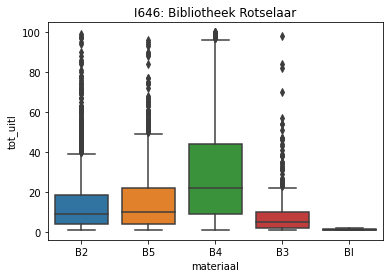

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6957.000000    6957.000000  6957.000000         I646   
mean     20.123329    2018.145178    11.401754         I646   
std      20.603566       3.672892     2.464996         I646   
min       1.000000    2008.000000     0.000000         I646   
25%       5.000000    2016.000000    11.000000         I646   
50%      12.000000    2019.000000    13.000000         I646   
75%      29.000000    2021.000000    13.000000         I646   
max     100.000000    2022.000000    13.000000         I646   

                 bibliotheek  
count  Bibliotheek Rotselaar  
mean   Bibliotheek Rotselaar  
std    Bibliotheek Rotselaar  
min    Bibliotheek Rotselaar  
25%    Bibliotheek Rotselaar  
50%    Bibliotheek Rotselaar  
75%    Bibliotheek Rotselaar  
max    Bibliotheek Rotselaar

____________________________________________________________
Bibliotheek Scherpenheuvel-Zichem


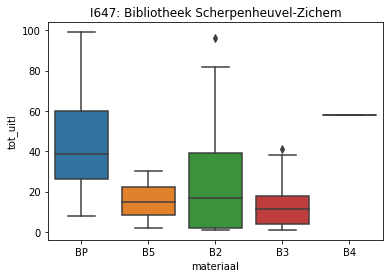

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  297.000000     297.000000  297.000000         I647   
mean    36.000000    2020.508418   12.898990         I647   
std     24.152528       1.832725    6.826263         I647   
min      1.000000    2010.000000    0.000000         I647   
25%     18.000000    2020.000000    8.000000         I647   
50%     32.000000    2021.000000   13.000000         I647   
75%     52.000000    2022.000000   18.000000         I647   
max     99.000000    2022.000000   27.000000         I647   

                             bibliotheek  
count  Bibliotheek Scherpenheuvel-Zichem  
mean   Bibliotheek Scherpenheuvel-Zichem  
std    Bibliotheek Scherpenheuvel-Zichem  
min    Bibliotheek Scherpenheuvel-Zichem  
25%    Bibliotheek Scherpenheuvel-Zichem  
50%    Bibliotheek Scherpenheuvel-Zichem  
75%    Bibliotheek Scherpenheuvel-Zichem  
max    Bibliotheek Scherpenheuvel-Zichem

____________________________________________________________
Bibliotheek Sint-Genesius-Rode


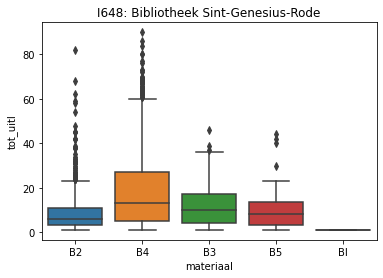

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2988.000000    2988.000000  2988.000000         I648   
mean     14.019746    2020.009371     5.814926         I648   
std      14.144335       1.761636     1.510886         I648   
min       1.000000    2015.000000     0.000000         I648   
25%       4.000000    2019.000000     5.000000         I648   
50%       9.000000    2020.000000     6.000000         I648   
75%      19.000000    2021.000000     7.000000         I648   
max      90.000000    2022.000000     7.000000         I648   

                          bibliotheek  
count  Bibliotheek Sint-Genesius-Rode  
mean   Bibliotheek Sint-Genesius-Rode  
std    Bibliotheek Sint-Genesius-Rode  
min    Bibliotheek Sint-Genesius-Rode  
25%    Bibliotheek Sint-Genesius-Rode  
50%    Bibliotheek Sint-Genesius-Rode  
75%    Bibliotheek Sint-Genesius-Rode  
max    Bibliotheek Sint-Genesius-Rode

____________________________________________________________
Bibliotheek Sint-Pieters-Leeuw


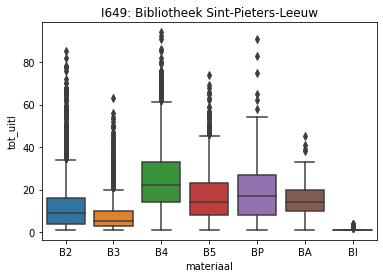

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  12499.000000   12499.000000  12499.000000         I649   
mean      15.477558    2019.429554      6.435315         I649   
std       13.757881       1.826021      1.365524         I649   
min        1.000000    2005.000000      0.000000         I649   
25%        5.000000    2019.000000      7.000000         I649   
50%       11.000000    2020.000000      7.000000         I649   
75%       22.000000    2021.000000      7.000000         I649   
max       94.000000    2022.000000      8.000000         I649   

                          bibliotheek  
count  Bibliotheek Sint-Pieters-Leeuw  
mean   Bibliotheek Sint-Pieters-Leeuw  
std    Bibliotheek Sint-Pieters-Leeuw  
min    Bibliotheek Sint-Pieters-Leeuw  
25%    Bibliotheek Sint-Pieters-Leeuw  
50%    Bibliotheek Sint-Pieters-Leeuw  
75%    Bibliotheek Sint-Pieters-Leeuw  
max    Bibliotheek Sint-Pieters-Leeuw

____________________________________________________________
Bibliotheek Steenokkerzeel


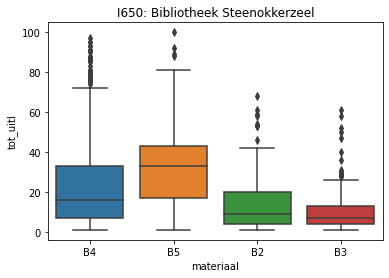

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1450.000000    1450.000000  1450.000000         I650   
mean     19.288276    2019.182759    15.490345         I650   
std      19.054524       2.887895     3.086108         I650   
min       1.000000    2010.000000     0.000000         I650   
25%       6.000000    2018.000000    14.000000         I650   
50%      13.000000    2020.000000    16.000000         I650   
75%      27.000000    2022.000000    18.000000         I650   
max     100.000000    2022.000000    18.000000         I650   

                      bibliotheek  
count  Bibliotheek Steenokkerzeel  
mean   Bibliotheek Steenokkerzeel  
std    Bibliotheek Steenokkerzeel  
min    Bibliotheek Steenokkerzeel  
25%    Bibliotheek Steenokkerzeel  
50%    Bibliotheek Steenokkerzeel  
75%    Bibliotheek Steenokkerzeel  
max    Bibliotheek Steenokkerzeel

____________________________________________________________
Bibliotheek Ternat


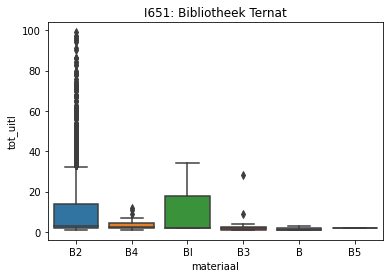

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2462.000000    2462.000000  2462.000000         I651   
mean     10.521527    2019.045491     6.277823         I651   
std      15.288720       2.775854     4.307368         I651   
min       1.000000    2009.000000     0.000000         I651   
25%       2.000000    2018.000000     3.000000         I651   
50%       3.000000    2019.000000     5.000000         I651   
75%      13.000000    2021.000000    12.000000         I651   
max      99.000000    2022.000000    12.000000         I651   

              bibliotheek  
count  Bibliotheek Ternat  
mean   Bibliotheek Ternat  
std    Bibliotheek Ternat  
min    Bibliotheek Ternat  
25%    Bibliotheek Ternat  
50%    Bibliotheek Ternat  
75%    Bibliotheek Ternat  
max    Bibliotheek Ternat

____________________________________________________________
Bibliotheek Tervuren


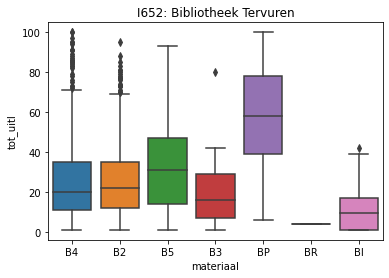

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1639.000000    1639.000000  1639.000000         I652   
mean     30.601586    2020.940818     7.016473         I652   
std      23.438706       1.424806     4.128622         I652   
min       1.000000    2010.000000     0.000000         I652   
25%      13.000000    2021.000000     4.000000         I652   
50%      24.000000    2021.000000     7.000000         I652   
75%      43.000000    2022.000000    10.000000         I652   
max     100.000000    2022.000000    26.000000         I652   

                bibliotheek  
count  Bibliotheek Tervuren  
mean   Bibliotheek Tervuren  
std    Bibliotheek Tervuren  
min    Bibliotheek Tervuren  
25%    Bibliotheek Tervuren  
50%    Bibliotheek Tervuren  
75%    Bibliotheek Tervuren  
max    Bibliotheek Tervuren

____________________________________________________________
Bibliotheek Tielt-Winge


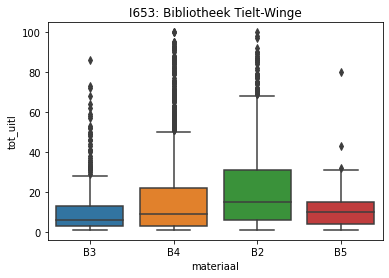

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  3280.000000    3280.000000  3280.00000         I653   
mean     16.887805    2017.905488    10.57500         I653   
std      18.922634       3.349641     2.02813         I653   
min       1.000000    2005.000000     0.00000         I653   
25%       4.000000    2016.000000    10.00000         I653   
50%      10.000000    2019.000000    11.00000         I653   
75%      23.000000    2021.000000    12.00000         I653   
max     100.000000    2022.000000    12.00000         I653   

                   bibliotheek  
count  Bibliotheek Tielt-Winge  
mean   Bibliotheek Tielt-Winge  
std    Bibliotheek Tielt-Winge  
min    Bibliotheek Tielt-Winge  
25%    Bibliotheek Tielt-Winge  
50%    Bibliotheek Tielt-Winge  
75%    Bibliotheek Tielt-Winge  
max    Bibliotheek Tielt-Winge

____________________________________________________________
Bibliotheek Tienen


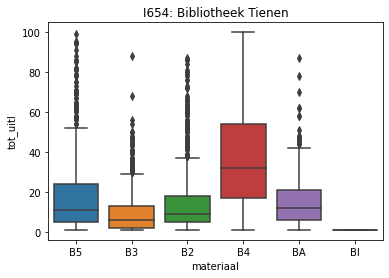

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3513.000000    3513.000000  3511.000000         I654   
mean     19.662966    2016.143182    18.029336         I654   
std      20.809534       5.303569     6.833468         I654   
min       1.000000    1999.000000     0.000000         I654   
25%       5.000000    2014.000000    13.000000         I654   
50%      12.000000    2017.000000    19.000000         I654   
75%      27.000000    2020.000000    24.000000         I654   
max     100.000000    2022.000000    28.000000         I654   

              bibliotheek  
count  Bibliotheek Tienen  
mean   Bibliotheek Tienen  
std    Bibliotheek Tienen  
min    Bibliotheek Tienen  
25%    Bibliotheek Tienen  
50%    Bibliotheek Tienen  
75%    Bibliotheek Tienen  
max    Bibliotheek Tienen

____________________________________________________________
Bibliotheek Tremelo


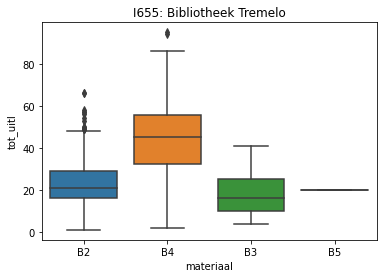

tot_uitl  ltst_jaar_uit    lft_exem instantie_id          bibliotheek
count  609.000000     609.000000  609.000000         I655  Bibliotheek Tremelo
mean    25.288998    2020.021346   11.942529         I655  Bibliotheek Tremelo
std     13.687365       2.058648    4.036631         I655  Bibliotheek Tremelo
min      1.000000    2011.000000    0.000000         I655  Bibliotheek Tremelo
25%     16.000000    2019.000000    9.000000         I655  Bibliotheek Tremelo
50%     22.000000    2021.000000   11.000000         I655  Bibliotheek Tremelo
75%     32.000000    2022.000000   14.000000         I655  Bibliotheek Tremelo
max     95.000000    2022.000000   28.000000         I655  Bibliotheek Tremelo

____________________________________________________________
Bibliotheek Vilvoorde


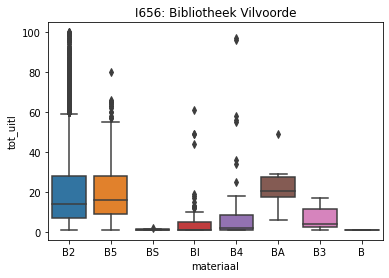

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  10737.000000   10737.000000  10737.000000         I656   
mean      19.400671    2018.508149      9.042377         I656   
std       17.202421       2.847750      2.745300         I656   
min        1.000000    2010.000000      0.000000         I656   
25%        7.000000    2017.000000      7.000000         I656   
50%       14.000000    2019.000000     10.000000         I656   
75%       27.000000    2021.000000     11.000000         I656   
max      100.000000    2022.000000     12.000000         I656   

                 bibliotheek  
count  Bibliotheek Vilvoorde  
mean   Bibliotheek Vilvoorde  
std    Bibliotheek Vilvoorde  
min    Bibliotheek Vilvoorde  
25%    Bibliotheek Vilvoorde  
50%    Bibliotheek Vilvoorde  
75%    Bibliotheek Vilvoorde  
max    Bibliotheek Vilvoorde

____________________________________________________________
Bibliotheek Wemmel


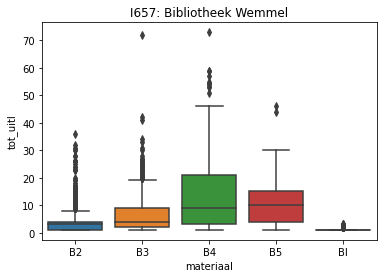

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3095.000000    3095.000000  3095.000000         I657   
mean      5.589661    2018.313409     5.541195         I657   
std       7.386785       2.413332     2.450314         I657   
min       1.000000    2005.000000     0.000000         I657   
25%       1.000000    2016.000000     5.000000         I657   
50%       3.000000    2018.000000     7.000000         I657   
75%       7.000000    2021.000000     7.000000         I657   
max      73.000000    2022.000000     8.000000         I657   

              bibliotheek  
count  Bibliotheek Wemmel  
mean   Bibliotheek Wemmel  
std    Bibliotheek Wemmel  
min    Bibliotheek Wemmel  
25%    Bibliotheek Wemmel  
50%    Bibliotheek Wemmel  
75%    Bibliotheek Wemmel  
max    Bibliotheek Wemmel

____________________________________________________________
Bibliotheek Wezembeek-Oppem


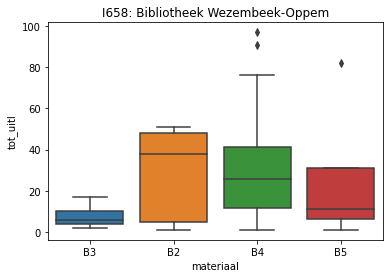

tot_uitl  ltst_jaar_uit   lft_exem instantie_id  \
count  67.000000      67.000000  67.000000         I658   
mean   22.641791    2020.805970   7.029851         I658   
std    23.053759       2.076118   4.185003         I658   
min     1.000000    2014.000000   0.000000         I658   
25%     6.000000    2020.000000   3.500000         I658   
50%    14.000000    2022.000000   7.000000         I658   
75%    32.500000    2022.000000  10.500000         I658   
max    97.000000    2022.000000  13.000000         I658   

                       bibliotheek  
count  Bibliotheek Wezembeek-Oppem  
mean   Bibliotheek Wezembeek-Oppem  
std    Bibliotheek Wezembeek-Oppem  
min    Bibliotheek Wezembeek-Oppem  
25%    Bibliotheek Wezembeek-Oppem  
50%    Bibliotheek Wezembeek-Oppem  
75%    Bibliotheek Wezembeek-Oppem  
max    Bibliotheek Wezembeek-Oppem

____________________________________________________________
Bibliotheek Zaventem


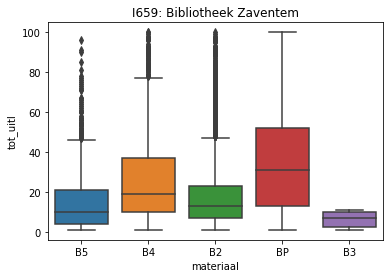

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  8665.000000    8665.000000  8665.000000         I659   
mean     20.386844    2018.206578    11.029890         I659   
std      19.431329       3.209739     4.030087         I659   
min       1.000000    2006.000000     0.000000         I659   
25%       7.000000    2017.000000    10.000000         I659   
50%      14.000000    2019.000000    12.000000         I659   
75%      27.000000    2021.000000    14.000000         I659   
max     100.000000    2022.000000    16.000000         I659   

                bibliotheek  
count  Bibliotheek Zaventem  
mean   Bibliotheek Zaventem  
std    Bibliotheek Zaventem  
min    Bibliotheek Zaventem  
25%    Bibliotheek Zaventem  
50%    Bibliotheek Zaventem  
75%    Bibliotheek Zaventem  
max    Bibliotheek Zaventem

____________________________________________________________
Bibliotheek Zemst


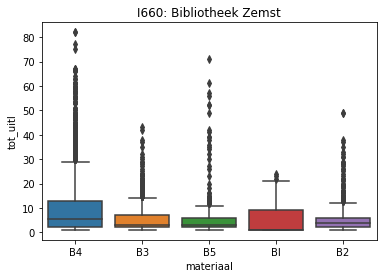

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  5769.000000    5769.000000  5769.000000         I660  Bibliotheek Zemst
mean      7.581903    2018.482926     4.963772         I660  Bibliotheek Zemst
std       9.742894       1.933650     1.364387         I660  Bibliotheek Zemst
min       1.000000    2005.000000     0.000000         I660  Bibliotheek Zemst
25%       2.000000    2017.000000     5.000000         I660  Bibliotheek Zemst
50%       4.000000    2018.000000     5.000000         I660  Bibliotheek Zemst
75%       9.000000    2020.000000     6.000000         I660  Bibliotheek Zemst
max      82.000000    2022.000000     6.000000         I660  Bibliotheek Zemst

____________________________________________________________
Bibliotheek Zoutleeuw


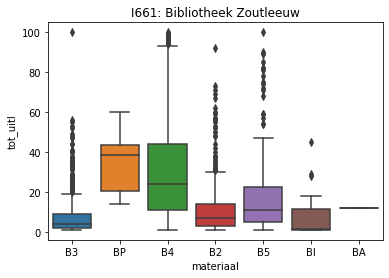

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1808.000000    1808.000000  1808.000000         I661   
mean     21.131637    2018.365044     9.308628         I661   
std      22.376250       3.594797     4.816832         I661   
min       1.000000    2008.000000     0.000000         I661   
25%       4.000000    2017.000000     6.000000         I661   
50%      12.000000    2020.000000    12.000000         I661   
75%      31.000000    2021.000000    13.000000         I661   
max     100.000000    2022.000000    14.000000         I661   

                 bibliotheek  
count  Bibliotheek Zoutleeuw  
mean   Bibliotheek Zoutleeuw  
std    Bibliotheek Zoutleeuw  
min    Bibliotheek Zoutleeuw  
25%    Bibliotheek Zoutleeuw  
50%    Bibliotheek Zoutleeuw  
75%    Bibliotheek Zoutleeuw  
max    Bibliotheek Zoutleeuw

____________________________________________________________
Bibliotheek Aartselaar


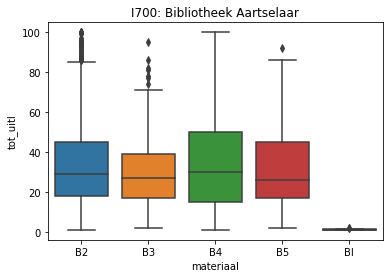

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3285.000000    3285.000000  3285.000000         I700   
mean     33.356164    2019.704718    11.050228         I700   
std      21.820294       2.036032     3.487262         I700   
min       1.000000    2008.000000     0.000000         I700   
25%      17.000000    2018.000000     8.000000         I700   
50%      28.000000    2020.000000    12.000000         I700   
75%      46.000000    2021.000000    14.000000         I700   
max     100.000000    2022.000000    15.000000         I700   

                  bibliotheek  
count  Bibliotheek Aartselaar  
mean   Bibliotheek Aartselaar  
std    Bibliotheek Aartselaar  
min    Bibliotheek Aartselaar  
25%    Bibliotheek Aartselaar  
50%    Bibliotheek Aartselaar  
75%    Bibliotheek Aartselaar  
max    Bibliotheek Aartselaar

____________________________________________________________
Bibliotheek Antwerpen


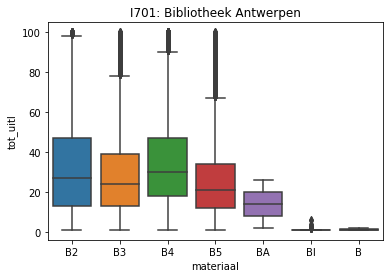

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  73225.000000   73225.000000  73225.000000         I701   
mean      31.235644    2020.355261      9.226275         I701   
std       21.510554       2.030213      4.658351         I701   
min        1.000000    2003.000000      0.000000         I701   
25%       15.000000    2020.000000      6.000000         I701   
50%       26.000000    2021.000000      9.000000         I701   
75%       43.000000    2022.000000     12.000000         I701   
max      100.000000    2022.000000     19.000000         I701   

                 bibliotheek  
count  Bibliotheek Antwerpen  
mean   Bibliotheek Antwerpen  
std    Bibliotheek Antwerpen  
min    Bibliotheek Antwerpen  
25%    Bibliotheek Antwerpen  
50%    Bibliotheek Antwerpen  
75%    Bibliotheek Antwerpen  
max    Bibliotheek Antwerpen

____________________________________________________________
Bibliotheek Arendonk


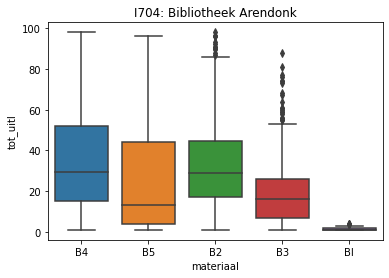

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1907.000000    1907.000000  1907.000000         I704   
mean     28.261143    2020.362874     8.180912         I704   
std      23.214610       1.972116     3.608794         I704   
min       1.000000    2010.000000     0.000000         I704   
25%       9.000000    2020.000000     7.000000         I704   
50%      23.000000    2021.000000     9.000000         I704   
75%      41.000000    2022.000000    11.000000         I704   
max      98.000000    2022.000000    12.000000         I704   

                bibliotheek  
count  Bibliotheek Arendonk  
mean   Bibliotheek Arendonk  
std    Bibliotheek Arendonk  
min    Bibliotheek Arendonk  
25%    Bibliotheek Arendonk  
50%    Bibliotheek Arendonk  
75%    Bibliotheek Arendonk  
max    Bibliotheek Arendonk

____________________________________________________________
Bibliotheek Balen


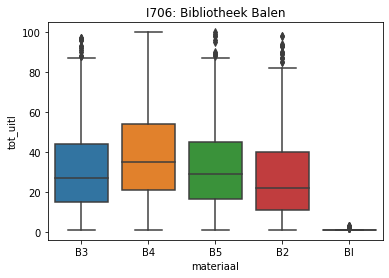

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  4416.000000    4416.000000  4416.000000         I706  Bibliotheek Balen
mean     33.223732    2020.470109     9.729167         I706  Bibliotheek Balen
std      21.922756       1.972980     3.893139         I706  Bibliotheek Balen
min       1.000000    2009.000000     0.000000         I706  Bibliotheek Balen
25%      16.000000    2020.000000     7.000000         I706  Bibliotheek Balen
50%      29.000000    2021.000000    10.000000         I706  Bibliotheek Balen
75%      47.000000    2022.000000    13.000000         I706  Bibliotheek Balen
max     100.000000    2022.000000    15.000000         I706  Bibliotheek Balen

____________________________________________________________
Bibliotheek Beerse


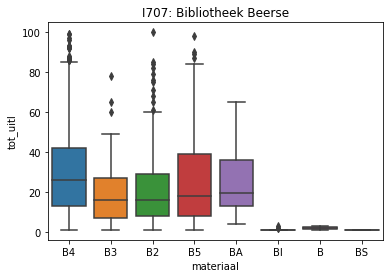

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1802.000000    1802.000000  1802.000000         I707   
mean     26.289123    2020.026637     8.790788         I707   
std      20.437828       1.924263     2.764907         I707   
min       1.000000    2010.000000     0.000000         I707   
25%      10.000000    2019.000000     7.000000         I707   
50%      21.000000    2021.000000    10.000000         I707   
75%      38.000000    2021.000000    11.000000         I707   
max     100.000000    2022.000000    11.000000         I707   

              bibliotheek  
count  Bibliotheek Beerse  
mean   Bibliotheek Beerse  
std    Bibliotheek Beerse  
min    Bibliotheek Beerse  
25%    Bibliotheek Beerse  
50%    Bibliotheek Beerse  
75%    Bibliotheek Beerse  
max    Bibliotheek Beerse

____________________________________________________________
Bibliotheek Berlaar


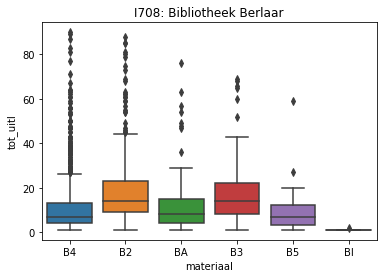

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1593.000000    1593.000000  1593.000000         I708   
mean     13.789705    2017.977401    11.074702         I708   
std      14.281769       3.053047     2.288834         I708   
min       1.000000    2010.000000     0.000000         I708   
25%       4.000000    2016.000000    12.000000         I708   
50%       9.000000    2018.000000    12.000000         I708   
75%      17.000000    2021.000000    12.000000         I708   
max      90.000000    2022.000000    12.000000         I708   

               bibliotheek  
count  Bibliotheek Berlaar  
mean   Bibliotheek Berlaar  
std    Bibliotheek Berlaar  
min    Bibliotheek Berlaar  
25%    Bibliotheek Berlaar  
50%    Bibliotheek Berlaar  
75%    Bibliotheek Berlaar  
max    Bibliotheek Berlaar

____________________________________________________________
Bibliotheek Boechout


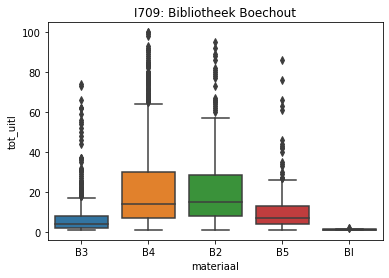

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2852.000000    2852.000000  2852.000000         I709   
mean     15.847125    2019.341865     7.558906         I709   
std      17.515973       2.167785     1.299853         I709   
min       1.000000    2014.000000     0.000000         I709   
25%       4.000000    2018.000000     8.000000         I709   
50%      10.000000    2020.000000     8.000000         I709   
75%      21.000000    2021.000000     8.000000         I709   
max     100.000000    2022.000000     8.000000         I709   

                bibliotheek  
count  Bibliotheek Boechout  
mean   Bibliotheek Boechout  
std    Bibliotheek Boechout  
min    Bibliotheek Boechout  
25%    Bibliotheek Boechout  
50%    Bibliotheek Boechout  
75%    Bibliotheek Boechout  
max    Bibliotheek Boechout

____________________________________________________________
Bibliotheek Bonheiden


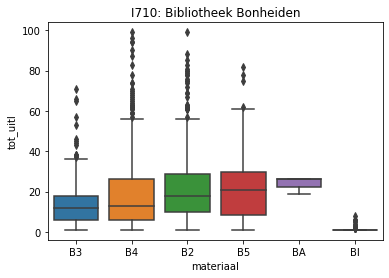

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1569.000000    1569.000000  1569.000000         I710   
mean     18.099426    2018.515615    10.091778         I710   
std      16.888373       2.652717     3.770250         I710   
min       1.000000    2009.000000     0.000000         I710   
25%       6.000000    2018.000000    10.000000         I710   
50%      13.000000    2019.000000    12.000000         I710   
75%      25.000000    2020.000000    12.000000         I710   
max      99.000000    2022.000000    13.000000         I710   

                 bibliotheek  
count  Bibliotheek Bonheiden  
mean   Bibliotheek Bonheiden  
std    Bibliotheek Bonheiden  
min    Bibliotheek Bonheiden  
25%    Bibliotheek Bonheiden  
50%    Bibliotheek Bonheiden  
75%    Bibliotheek Bonheiden  
max    Bibliotheek Bonheiden

____________________________________________________________
Bibliotheek Boom


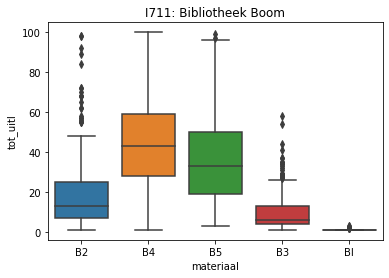

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  2286.000000    2286.000000  2286.000000         I711  Bibliotheek Boom
mean     29.848644    2019.426072    10.243657         I711  Bibliotheek Boom
std      24.089890       3.002334     4.003679         I711  Bibliotheek Boom
min       1.000000    2008.000000     0.000000         I711  Bibliotheek Boom
25%       9.000000    2017.000000     8.000000         I711  Bibliotheek Boom
50%      25.000000    2021.000000    12.000000         I711  Bibliotheek Boom
75%      45.000000    2022.000000    14.000000         I711  Bibliotheek Boom
max     100.000000    2022.000000    14.000000         I711  Bibliotheek Boom

____________________________________________________________
Bibliotheek Bornem


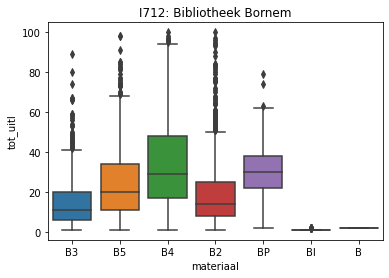

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3334.000000    3334.000000  3334.000000         I712   
mean     22.569886    2018.927714     9.520396         I712   
std      19.603367       2.761528     3.408049         I712   
min       1.000000    2009.000000     0.000000         I712   
25%       8.000000    2017.000000     8.000000         I712   
50%      17.000000    2019.000000    12.000000         I712   
75%      31.000000    2021.000000    12.000000         I712   
max     100.000000    2022.000000    12.000000         I712   

              bibliotheek  
count  Bibliotheek Bornem  
mean   Bibliotheek Bornem  
std    Bibliotheek Bornem  
min    Bibliotheek Bornem  
25%    Bibliotheek Bornem  
50%    Bibliotheek Bornem  
75%    Bibliotheek Bornem  
max    Bibliotheek Bornem

____________________________________________________________
Bibliotheek Borsbeek


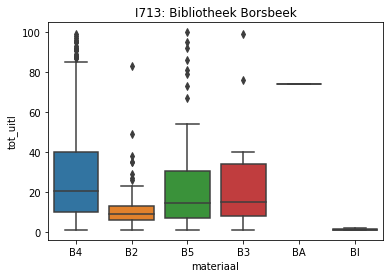

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1140.000000    1140.000000  1140.000000         I713   
mean     24.549123    2019.792982    10.726316         I713   
std      22.617603       2.377673     2.667170         I713   
min       1.000000    2009.000000     0.000000         I713   
25%       8.000000    2019.000000    11.000000         I713   
50%      16.000000    2021.000000    12.000000         I713   
75%      35.000000    2022.000000    12.000000         I713   
max     100.000000    2022.000000    13.000000         I713   

                bibliotheek  
count  Bibliotheek Borsbeek  
mean   Bibliotheek Borsbeek  
std    Bibliotheek Borsbeek  
min    Bibliotheek Borsbeek  
25%    Bibliotheek Borsbeek  
50%    Bibliotheek Borsbeek  
75%    Bibliotheek Borsbeek  
max    Bibliotheek Borsbeek

____________________________________________________________
Bibliotheek Brasschaat


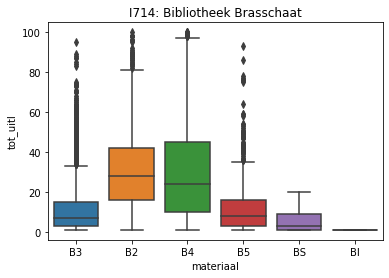

tot_uitl  ltst_jaar_uit      lft_exem instantie_id  \
count  10063.000000   10063.000000  10063.000000         I714   
mean      23.921296    2019.298420      9.804929         I714   
std       21.763893       3.077622      2.116515         I714   
min        1.000000    2010.000000      0.000000         I714   
25%        6.000000    2018.000000      9.000000         I714   
50%       17.000000    2021.000000     11.000000         I714   
75%       37.000000    2021.000000     11.000000         I714   
max      100.000000    2022.000000     11.000000         I714   

                  bibliotheek  
count  Bibliotheek Brasschaat  
mean   Bibliotheek Brasschaat  
std    Bibliotheek Brasschaat  
min    Bibliotheek Brasschaat  
25%    Bibliotheek Brasschaat  
50%    Bibliotheek Brasschaat  
75%    Bibliotheek Brasschaat  
max    Bibliotheek Brasschaat

____________________________________________________________
Bibliotheek Brecht


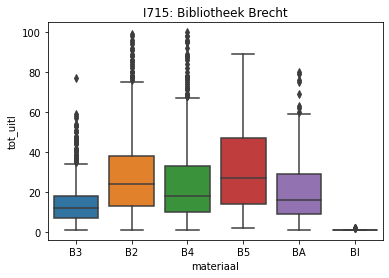

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4537.000000    4537.000000  4537.000000         I715   
mean     22.854529    2019.506061     9.113952         I715   
std      17.648138       1.921640     3.637089         I715   
min       1.000000    2009.000000     0.000000         I715   
25%      10.000000    2019.000000     6.000000         I715   
50%      18.000000    2020.000000    10.000000         I715   
75%      32.000000    2021.000000    13.000000         I715   
max     100.000000    2022.000000    14.000000         I715   

              bibliotheek  
count  Bibliotheek Brecht  
mean   Bibliotheek Brecht  
std    Bibliotheek Brecht  
min    Bibliotheek Brecht  
25%    Bibliotheek Brecht  
50%    Bibliotheek Brecht  
75%    Bibliotheek Brecht  
max    Bibliotheek Brecht

____________________________________________________________
Bibliotheek Dessel


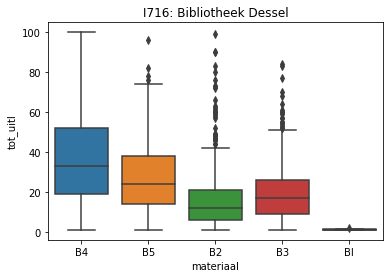

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2551.000000    2551.000000  2551.000000         I716   
mean     25.397099    2019.657389     9.061152         I716   
std      19.917523       2.069627     3.149756         I716   
min       1.000000    2009.000000     0.000000         I716   
25%      10.000000    2018.000000     7.000000         I716   
50%      20.000000    2020.000000     9.000000         I716   
75%      35.000000    2021.000000    12.000000         I716   
max     100.000000    2022.000000    13.000000         I716   

              bibliotheek  
count  Bibliotheek Dessel  
mean   Bibliotheek Dessel  
std    Bibliotheek Dessel  
min    Bibliotheek Dessel  
25%    Bibliotheek Dessel  
50%    Bibliotheek Dessel  
75%    Bibliotheek Dessel  
max    Bibliotheek Dessel

____________________________________________________________
Bibliotheek Duffel


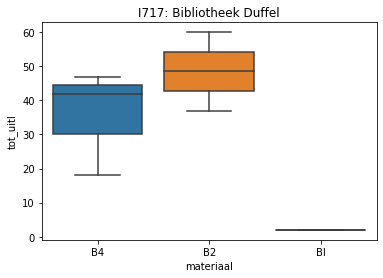

tot_uitl  ltst_jaar_uit   lft_exem instantie_id         bibliotheek
count   6.000000            6.0   6.000000         I717  Bibliotheek Duffel
mean   34.333333         2022.0   9.333333         I717  Bibliotheek Duffel
std    20.963460            0.0   6.976150         I717  Bibliotheek Duffel
min     2.000000         2022.0   0.000000         I717  Bibliotheek Duffel
25%    22.750000         2022.0   5.750000         I717  Bibliotheek Duffel
50%    39.500000         2022.0   8.500000         I717  Bibliotheek Duffel
75%    45.750000         2022.0  12.750000         I717  Bibliotheek Duffel
max    60.000000         2022.0  20.000000         I717  Bibliotheek Duffel

____________________________________________________________
Bibliotheek Edegem


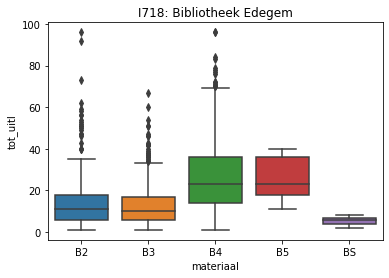

tot_uitl  ltst_jaar_uit    lft_exem instantie_id         bibliotheek
count  896.000000     896.000000  896.000000         I718  Bibliotheek Edegem
mean    17.503348    2020.470982    5.943080         I718  Bibliotheek Edegem
std     15.802128       1.518322    1.620434         I718  Bibliotheek Edegem
min      1.000000    2015.000000    0.000000         I718  Bibliotheek Edegem
25%      7.000000    2020.000000    6.000000         I718  Bibliotheek Edegem
50%     13.000000    2021.000000    6.000000         I718  Bibliotheek Edegem
75%     22.000000    2022.000000    7.000000         I718  Bibliotheek Edegem
max     96.000000    2022.000000    7.000000         I718  Bibliotheek Edegem

____________________________________________________________
Bibliotheek Essen


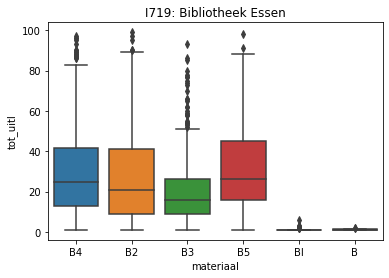

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  1907.000000    1907.000000  1907.000000         I719  Bibliotheek Essen
mean     25.359727    2019.955427     8.917672         I719  Bibliotheek Essen
std      20.696417       2.255832     3.923326         I719  Bibliotheek Essen
min       1.000000    2008.000000     0.000000         I719  Bibliotheek Essen
25%       9.000000    2019.000000     7.000000         I719  Bibliotheek Essen
50%      20.000000    2021.000000     9.000000         I719  Bibliotheek Essen
75%      36.000000    2022.000000    13.000000         I719  Bibliotheek Essen
max      99.000000    2022.000000    14.000000         I719  Bibliotheek Essen

____________________________________________________________
Bibliotheek Geel


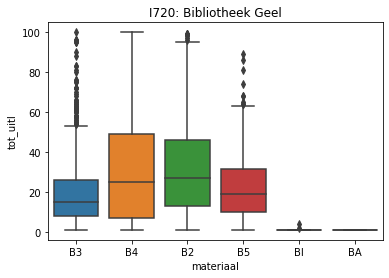

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  4752.000000    4752.000000  4752.000000         I720  Bibliotheek Geel
mean     26.015993    2020.412668     6.470960         I720  Bibliotheek Geel
std      22.092384       1.568727     2.846231         I720  Bibliotheek Geel
min       1.000000    2012.000000     0.000000         I720  Bibliotheek Geel
25%       9.000000    2019.000000     5.000000         I720  Bibliotheek Geel
50%      20.000000    2021.000000     7.000000         I720  Bibliotheek Geel
75%      38.000000    2022.000000     9.000000         I720  Bibliotheek Geel
max     100.000000    2022.000000     9.000000         I720  Bibliotheek Geel

____________________________________________________________
Bibliotheek Grobbendonk


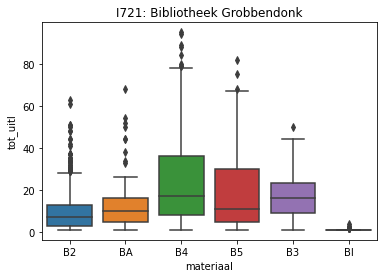

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1794.000000    1794.000000  1794.000000         I721   
mean     15.127648    2018.876812     8.491081         I721   
std      15.972190       2.994490     2.950073         I721   
min       1.000000    2011.000000     0.000000         I721   
25%       4.000000    2017.000000     9.000000         I721   
50%      10.000000    2020.000000    10.000000         I721   
75%      20.750000    2021.000000    10.000000         I721   
max      95.000000    2022.000000    10.000000         I721   

                   bibliotheek  
count  Bibliotheek Grobbendonk  
mean   Bibliotheek Grobbendonk  
std    Bibliotheek Grobbendonk  
min    Bibliotheek Grobbendonk  
25%    Bibliotheek Grobbendonk  
50%    Bibliotheek Grobbendonk  
75%    Bibliotheek Grobbendonk  
max    Bibliotheek Grobbendonk

____________________________________________________________
Bibliotheek Heist-op-den-Berg


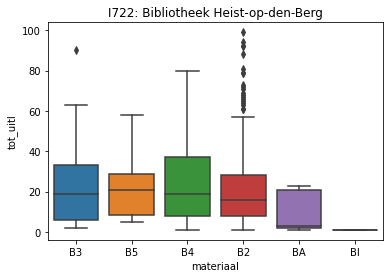

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  578.000000     578.000000  574.000000         I722   
mean    21.314879    2018.742215   15.135889         I722   
std     17.767353       3.274975    5.600954         I722   
min      1.000000    2005.000000    0.000000         I722   
25%      8.000000    2018.000000   11.000000         I722   
50%     16.000000    2019.500000   15.000000         I722   
75%     29.000000    2021.000000   19.000000         I722   
max     99.000000    2022.000000   29.000000         I722   

                         bibliotheek  
count  Bibliotheek Heist-op-den-Berg  
mean   Bibliotheek Heist-op-den-Berg  
std    Bibliotheek Heist-op-den-Berg  
min    Bibliotheek Heist-op-den-Berg  
25%    Bibliotheek Heist-op-den-Berg  
50%    Bibliotheek Heist-op-den-Berg  
75%    Bibliotheek Heist-op-den-Berg  
max    Bibliotheek Heist-op-den-Berg

____________________________________________________________
Bibliotheek Herentals


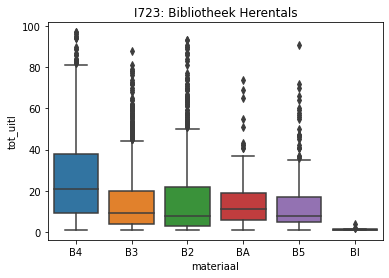

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4238.000000    4238.000000  4238.000000         I723   
mean     17.151015    2019.593204     5.605946         I723   
std      17.310594       1.753158     1.150461         I723   
min       1.000000    2015.000000     0.000000         I723   
25%       5.000000    2018.000000     6.000000         I723   
50%      10.000000    2020.000000     6.000000         I723   
75%      24.000000    2021.000000     6.000000         I723   
max      97.000000    2022.000000     7.000000         I723   

                 bibliotheek  
count  Bibliotheek Herentals  
mean   Bibliotheek Herentals  
std    Bibliotheek Herentals  
min    Bibliotheek Herentals  
25%    Bibliotheek Herentals  
50%    Bibliotheek Herentals  
75%    Bibliotheek Herentals  
max    Bibliotheek Herentals

____________________________________________________________
Bibliotheek Herenthout


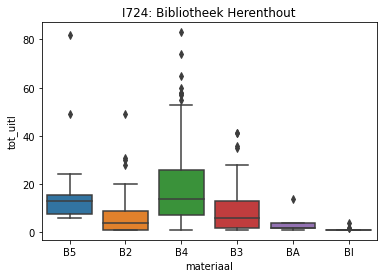

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  500.000000     500.000000  500.000000         I724   
mean    12.446000    2019.962000    8.478000         I724   
std     13.678644       2.254489    4.837802         I724   
min      1.000000    2010.000000    0.000000         I724   
25%      2.000000    2019.000000    5.000000         I724   
50%      8.000000    2020.000000   12.000000         I724   
75%     17.000000    2022.000000   12.000000         I724   
max     83.000000    2022.000000   12.000000         I724   

                  bibliotheek  
count  Bibliotheek Herenthout  
mean   Bibliotheek Herenthout  
std    Bibliotheek Herenthout  
min    Bibliotheek Herenthout  
25%    Bibliotheek Herenthout  
50%    Bibliotheek Herenthout  
75%    Bibliotheek Herenthout  
max    Bibliotheek Herenthout

____________________________________________________________
Bibliotheek Herselt


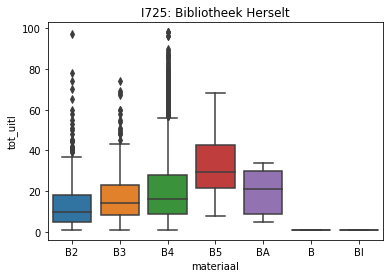

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2380.000000    2380.000000  2380.000000         I725   
mean     18.787815    2018.605882    12.140336         I725   
std      16.730033       3.359897     3.053752         I725   
min       1.000000    2008.000000     0.000000         I725   
25%       7.000000    2017.000000    11.000000         I725   
50%      14.000000    2019.000000    14.000000         I725   
75%      24.000000    2021.000000    14.000000         I725   
max      98.000000    2022.000000    14.000000         I725   

               bibliotheek  
count  Bibliotheek Herselt  
mean   Bibliotheek Herselt  
std    Bibliotheek Herselt  
min    Bibliotheek Herselt  
25%    Bibliotheek Herselt  
50%    Bibliotheek Herselt  
75%    Bibliotheek Herselt  
max    Bibliotheek Herselt

____________________________________________________________
Bibliotheek Hoogstraten


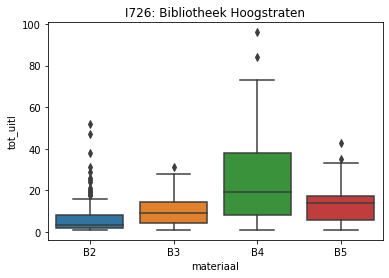

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  405.000000     405.000000  405.000000         I726   
mean    13.434568    2019.720988    8.175309         I726   
std     14.857534       2.052209    4.089516         I726   
min      1.000000    2014.000000    0.000000         I726   
25%      3.000000    2018.000000    6.000000         I726   
50%      8.000000    2020.000000    8.000000         I726   
75%     18.000000    2022.000000   10.000000         I726   
max     96.000000    2022.000000   20.000000         I726   

                   bibliotheek  
count  Bibliotheek Hoogstraten  
mean   Bibliotheek Hoogstraten  
std    Bibliotheek Hoogstraten  
min    Bibliotheek Hoogstraten  
25%    Bibliotheek Hoogstraten  
50%    Bibliotheek Hoogstraten  
75%    Bibliotheek Hoogstraten  
max    Bibliotheek Hoogstraten

____________________________________________________________
Bibliotheek Hove


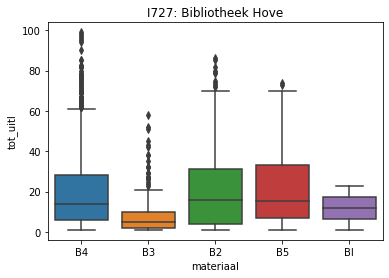

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  2141.000000    2141.000000  2141.000000         I727  Bibliotheek Hove
mean     19.529192    2020.212518     6.615133         I727  Bibliotheek Hove
std      18.652146       1.980784     1.306145         I727  Bibliotheek Hove
min       1.000000    2014.000000     0.000000         I727  Bibliotheek Hove
25%       5.000000    2019.000000     7.000000         I727  Bibliotheek Hove
50%      14.000000    2021.000000     7.000000         I727  Bibliotheek Hove
75%      28.000000    2022.000000     7.000000         I727  Bibliotheek Hove
max      99.000000    2022.000000     8.000000         I727  Bibliotheek Hove

____________________________________________________________
Bibliotheek Hulshout


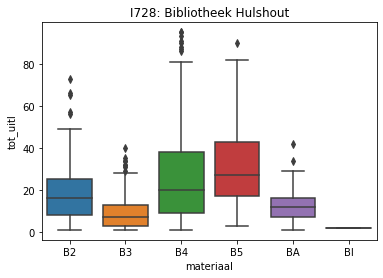

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1568.000000    1568.000000  1568.000000         I728   
mean     19.386480    2019.491709     8.436224         I728   
std      17.476245       2.697927     3.449667         I728   
min       1.000000    2010.000000     0.000000         I728   
25%       6.000000    2018.000000     6.000000         I728   
50%      15.000000    2021.000000    10.000000         I728   
75%      27.000000    2021.000000    11.000000         I728   
max      95.000000    2022.000000    12.000000         I728   

                bibliotheek  
count  Bibliotheek Hulshout  
mean   Bibliotheek Hulshout  
std    Bibliotheek Hulshout  
min    Bibliotheek Hulshout  
25%    Bibliotheek Hulshout  
50%    Bibliotheek Hulshout  
75%    Bibliotheek Hulshout  
max    Bibliotheek Hulshout

____________________________________________________________
IVEBICA


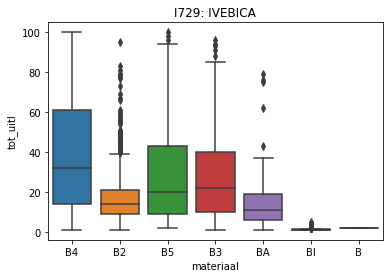

tot_uitl  ltst_jaar_uit     lft_exem instantie_id bibliotheek
count  2873.000000    2873.000000  2873.000000         I729     IVEBICA
mean     23.830839    2019.581274     9.849983         I729     IVEBICA
std      21.093536       2.261713     2.569124         I729     IVEBICA
min       1.000000    2010.000000     0.000000         I729     IVEBICA
25%       9.000000    2019.000000     9.000000         I729     IVEBICA
50%      16.000000    2020.000000    11.000000         I729     IVEBICA
75%      32.000000    2021.000000    11.000000         I729     IVEBICA
max     100.000000    2022.000000    12.000000         I729     IVEBICA

____________________________________________________________
Bibliotheek Kalmthout


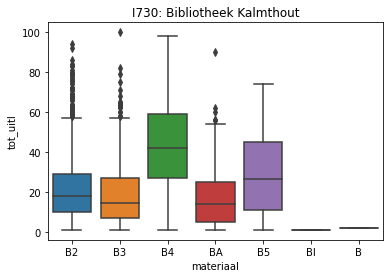

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3049.000000    3049.000000  3049.000000         I730   
mean     25.378813    2020.541817     6.033782         I730   
std      20.119504       1.545134     1.648940         I730   
min       1.000000    2015.000000     0.000000         I730   
25%      10.000000    2020.000000     6.000000         I730   
50%      20.000000    2021.000000     7.000000         I730   
75%      37.000000    2022.000000     7.000000         I730   
max     100.000000    2022.000000     7.000000         I730   

                 bibliotheek  
count  Bibliotheek Kalmthout  
mean   Bibliotheek Kalmthout  
std    Bibliotheek Kalmthout  
min    Bibliotheek Kalmthout  
25%    Bibliotheek Kalmthout  
50%    Bibliotheek Kalmthout  
75%    Bibliotheek Kalmthout  
max    Bibliotheek Kalmthout

____________________________________________________________
Bibliotheek Kapellen


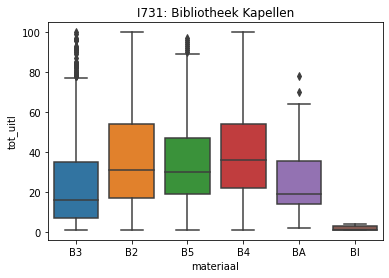

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7078.000000    7078.000000  7078.000000         I731   
mean     32.299378    2020.201045    10.747528         I731   
std      23.350905       2.240547     3.555527         I731   
min       1.000000    2007.000000     0.000000         I731   
25%      13.000000    2019.000000     9.000000         I731   
50%      27.000000    2021.000000    11.000000         I731   
75%      47.000000    2022.000000    14.000000         I731   
max     100.000000    2022.000000    15.000000         I731   

                bibliotheek  
count  Bibliotheek Kapellen  
mean   Bibliotheek Kapellen  
std    Bibliotheek Kapellen  
min    Bibliotheek Kapellen  
25%    Bibliotheek Kapellen  
50%    Bibliotheek Kapellen  
75%    Bibliotheek Kapellen  
max    Bibliotheek Kapellen

____________________________________________________________
Bibliotheek Kasterlee


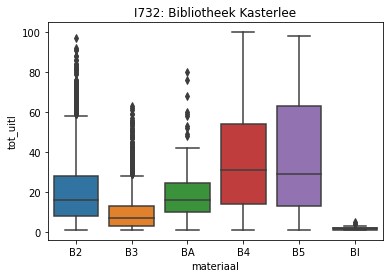

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6380.000000    6380.000000  6380.000000         I732   
mean     18.277900    2018.167555    11.715987         I732   
std      18.705925       3.588792     2.920093         I732   
min       1.000000    2008.000000     0.000000         I732   
25%       5.000000    2016.000000    10.000000         I732   
50%      12.000000    2019.000000    13.000000         I732   
75%      25.000000    2021.000000    14.000000         I732   
max     100.000000    2022.000000    14.000000         I732   

                 bibliotheek  
count  Bibliotheek Kasterlee  
mean   Bibliotheek Kasterlee  
std    Bibliotheek Kasterlee  
min    Bibliotheek Kasterlee  
25%    Bibliotheek Kasterlee  
50%    Bibliotheek Kasterlee  
75%    Bibliotheek Kasterlee  
max    Bibliotheek Kasterlee

____________________________________________________________
Bibliotheek Kontich


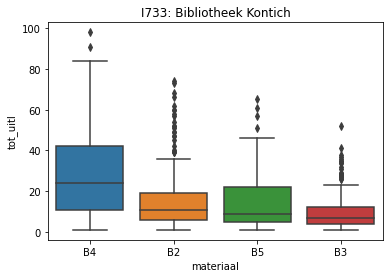

tot_uitl  ltst_jaar_uit    lft_exem instantie_id          bibliotheek
count  709.000000     709.000000  709.000000         I733  Bibliotheek Kontich
mean    16.705219    2019.028209   10.363893         I733  Bibliotheek Kontich
std     16.368695       2.879755    3.958135         I733  Bibliotheek Kontich
min      1.000000    2003.000000    0.000000         I733  Bibliotheek Kontich
25%      6.000000    2018.000000    8.000000         I733  Bibliotheek Kontich
50%     10.000000    2019.000000   10.000000         I733  Bibliotheek Kontich
75%     23.000000    2022.000000   11.000000         I733  Bibliotheek Kontich
max     98.000000    2022.000000   28.000000         I733  Bibliotheek Kontich

____________________________________________________________
Bibliotheek Laakdal


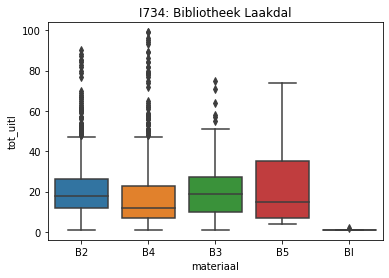

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2086.000000    2086.000000  2086.000000         I734   
mean     19.944391    2018.929530     9.843241         I734   
std      15.579294       1.757838     4.097829         I734   
min       1.000000    2008.000000     0.000000         I734   
25%       9.000000    2018.000000     6.000000         I734   
50%      16.000000    2019.000000    11.000000         I734   
75%      25.000000    2019.000000    14.000000         I734   
max      99.000000    2022.000000    14.000000         I734   

               bibliotheek  
count  Bibliotheek Laakdal  
mean   Bibliotheek Laakdal  
std    Bibliotheek Laakdal  
min    Bibliotheek Laakdal  
25%    Bibliotheek Laakdal  
50%    Bibliotheek Laakdal  
75%    Bibliotheek Laakdal  
max    Bibliotheek Laakdal

____________________________________________________________
Bibliotheek Lier


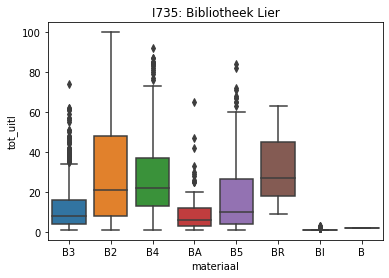

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  3223.000000    3223.000000  3223.000000         I735  Bibliotheek Lier
mean     18.650016    2020.385666     5.744027         I735  Bibliotheek Lier
std      18.478763       1.667748     1.886262         I735  Bibliotheek Lier
min       1.000000    2015.000000     0.000000         I735  Bibliotheek Lier
25%       5.000000    2020.000000     6.000000         I735  Bibliotheek Lier
50%      12.000000    2021.000000     6.000000         I735  Bibliotheek Lier
75%      27.000000    2022.000000     7.000000         I735  Bibliotheek Lier
max     100.000000    2022.000000     7.000000         I735  Bibliotheek Lier

____________________________________________________________
Bibliotheek Lille


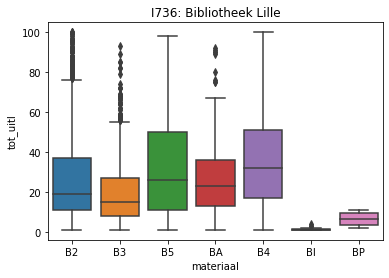

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  3825.000000    3825.000000  3825.000000         I736  Bibliotheek Lille
mean     26.054641    2019.637386     8.506928         I736  Bibliotheek Lille
std      21.389638       2.708273     3.131200         I736  Bibliotheek Lille
min       1.000000    2008.000000     0.000000         I736  Bibliotheek Lille
25%      10.000000    2019.000000     7.000000         I736  Bibliotheek Lille
50%      20.000000    2021.000000     8.000000         I736  Bibliotheek Lille
75%      37.000000    2022.000000    10.000000         I736  Bibliotheek Lille
max     100.000000    2022.000000    14.000000         I736  Bibliotheek Lille

____________________________________________________________
Bibliotheek Lint


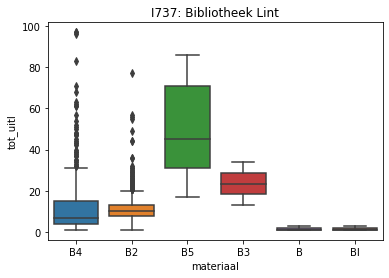

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  1967.00000    1967.000000  1967.000000         I737  Bibliotheek Lint
mean     11.44484    2018.798170     8.036096         I737  Bibliotheek Lint
std       8.71604       2.173183     1.482080         I737  Bibliotheek Lint
min       1.00000    2013.000000     0.000000         I737  Bibliotheek Lint
25%       7.00000    2017.000000     7.000000         I737  Bibliotheek Lint
50%      10.00000    2019.000000     9.000000         I737  Bibliotheek Lint
75%      13.00000    2021.000000     9.000000         I737  Bibliotheek Lint
max      97.00000    2022.000000     9.000000         I737  Bibliotheek Lint

____________________________________________________________
Bibliotheek Malle


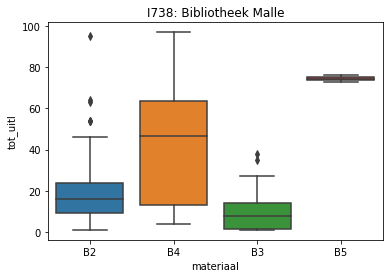

tot_uitl  ltst_jaar_uit    lft_exem instantie_id        bibliotheek
count  291.000000     291.000000  291.000000         I738  Bibliotheek Malle
mean    20.553265    2020.670103    7.890034         I738  Bibliotheek Malle
std     18.422992       1.529401    4.667747         I738  Bibliotheek Malle
min      1.000000    2016.000000    0.000000         I738  Bibliotheek Malle
25%      8.000000    2020.000000    5.000000         I738  Bibliotheek Malle
50%     16.000000    2021.000000    9.000000         I738  Bibliotheek Malle
75%     27.500000    2022.000000   10.000000         I738  Bibliotheek Malle
max     97.000000    2022.000000   22.000000         I738  Bibliotheek Malle

____________________________________________________________
Bibliotheek Mechelen


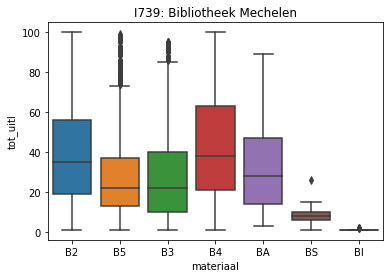

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7861.000000    7861.000000  7861.000000         I739   
mean     33.710469    2020.584913     9.888055         I739   
std      24.083414       1.914940     5.104923         I739   
min       1.000000    2006.000000     0.000000         I739   
25%      14.000000    2020.000000     6.000000         I739   
50%      28.000000    2021.000000    11.000000         I739   
75%      49.000000    2022.000000    15.000000         I739   
max     100.000000    2022.000000    16.000000         I739   

                bibliotheek  
count  Bibliotheek Mechelen  
mean   Bibliotheek Mechelen  
std    Bibliotheek Mechelen  
min    Bibliotheek Mechelen  
25%    Bibliotheek Mechelen  
50%    Bibliotheek Mechelen  
75%    Bibliotheek Mechelen  
max    Bibliotheek Mechelen

____________________________________________________________
Bibliotheek Meerhout


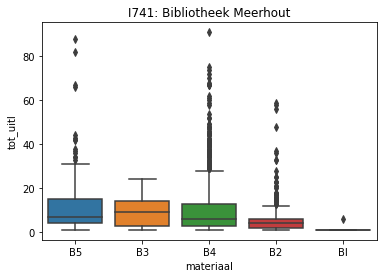

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2185.000000    2185.000000  2185.000000         I741   
mean      9.036156    2019.558810     5.626087         I741   
std      10.610921       1.834086     1.015339         I741   
min       1.000000    2015.000000     0.000000         I741   
25%       3.000000    2018.000000     6.000000         I741   
50%       5.000000    2020.000000     6.000000         I741   
75%      11.000000    2021.000000     6.000000         I741   
max      91.000000    2022.000000     6.000000         I741   

                bibliotheek  
count  Bibliotheek Meerhout  
mean   Bibliotheek Meerhout  
std    Bibliotheek Meerhout  
min    Bibliotheek Meerhout  
25%    Bibliotheek Meerhout  
50%    Bibliotheek Meerhout  
75%    Bibliotheek Meerhout  
max    Bibliotheek Meerhout

____________________________________________________________
Bibliotheek Merksplas


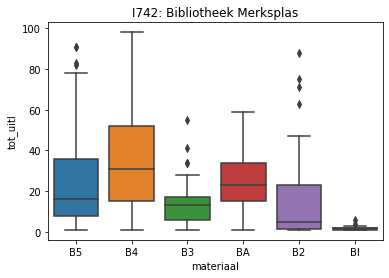

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1171.000000    1171.000000  1171.000000         I742   
mean     26.525192    2020.860803     8.048676         I742   
std      23.850424       1.933137     4.349499         I742   
min       1.000000    2009.000000     0.000000         I742   
25%       6.000000    2020.000000     6.000000         I742   
50%      20.000000    2022.000000     9.000000         I742   
75%      41.000000    2022.000000    12.000000         I742   
max      98.000000    2022.000000    13.000000         I742   

                 bibliotheek  
count  Bibliotheek Merksplas  
mean   Bibliotheek Merksplas  
std    Bibliotheek Merksplas  
min    Bibliotheek Merksplas  
25%    Bibliotheek Merksplas  
50%    Bibliotheek Merksplas  
75%    Bibliotheek Merksplas  
max    Bibliotheek Merksplas

____________________________________________________________
Bibliotheek Mol


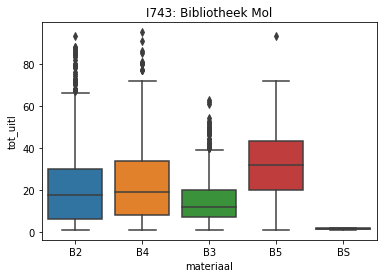

tot_uitl  ltst_jaar_uit     lft_exem instantie_id      bibliotheek
count  3525.000000    3525.000000  3525.000000         I743  Bibliotheek Mol
mean     19.483404    2020.730780     6.362837         I743  Bibliotheek Mol
std      16.217837       1.380658     1.413906         I743  Bibliotheek Mol
min       1.000000    2015.000000     0.000000         I743  Bibliotheek Mol
25%       7.000000    2020.000000     6.000000         I743  Bibliotheek Mol
50%      15.000000    2021.000000     7.000000         I743  Bibliotheek Mol
75%      27.000000    2022.000000     7.000000         I743  Bibliotheek Mol
max      95.000000    2022.000000     7.000000         I743  Bibliotheek Mol

____________________________________________________________
Bibliotheek Mortsel


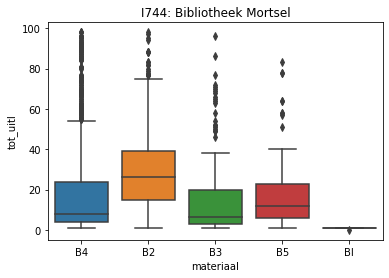

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1895.000000    1895.000000  1895.000000         I744   
mean     21.103958    2019.455937     8.465963         I744   
std      21.892997       2.534875     2.173999         I744   
min       0.000000    2012.000000     0.000000         I744   
25%       4.000000    2018.000000     8.000000         I744   
50%      13.000000    2020.000000     9.000000         I744   
75%      30.000000    2021.000000    10.000000         I744   
max      98.000000    2022.000000    10.000000         I744   

               bibliotheek  
count  Bibliotheek Mortsel  
mean   Bibliotheek Mortsel  
std    Bibliotheek Mortsel  
min    Bibliotheek Mortsel  
25%    Bibliotheek Mortsel  
50%    Bibliotheek Mortsel  
75%    Bibliotheek Mortsel  
max    Bibliotheek Mortsel

____________________________________________________________
Bibliotheek Nijlen


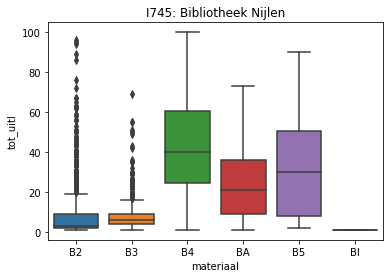

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1102.000000    1102.000000  1102.000000         I745   
mean     16.287659    2018.095281     9.451906         I745   
std      20.991106       3.428920     3.518338         I745   
min       1.000000    2009.000000     0.000000         I745   
25%       3.000000    2016.000000     7.000000         I745   
50%       6.000000    2018.000000    12.000000         I745   
75%      24.000000    2021.000000    12.000000         I745   
max     100.000000    2022.000000    12.000000         I745   

              bibliotheek  
count  Bibliotheek Nijlen  
mean   Bibliotheek Nijlen  
std    Bibliotheek Nijlen  
min    Bibliotheek Nijlen  
25%    Bibliotheek Nijlen  
50%    Bibliotheek Nijlen  
75%    Bibliotheek Nijlen  
max    Bibliotheek Nijlen

____________________________________________________________
Bibliotheek Olen


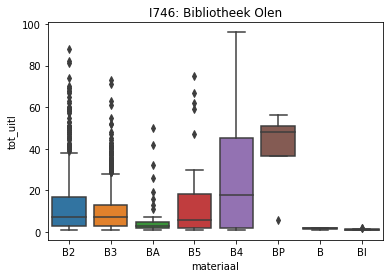

tot_uitl  ltst_jaar_uit     lft_exem instantie_id       bibliotheek
count  2205.000000    2205.000000  2205.000000         I746  Bibliotheek Olen
mean     11.882540    2017.358277    10.793197         I746  Bibliotheek Olen
std      14.084728       3.745352     3.352661         I746  Bibliotheek Olen
min       1.000000    2009.000000     0.000000         I746  Bibliotheek Olen
25%       3.000000    2014.000000    10.000000         I746  Bibliotheek Olen
50%       7.000000    2018.000000    12.000000         I746  Bibliotheek Olen
75%      15.000000    2021.000000    13.000000         I746  Bibliotheek Olen
max      96.000000    2022.000000    13.000000         I746  Bibliotheek Olen

____________________________________________________________
Bibliotheek Oud-Turnhout


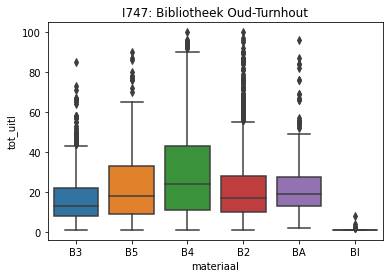

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4796.000000    4796.000000  4796.000000         I747   
mean     23.022727    2019.596747     9.701626         I747   
std      18.321429       2.322852     3.607547         I747   
min       1.000000    2007.000000     0.000000         I747   
25%      10.000000    2018.000000     8.000000         I747   
50%      17.000000    2020.000000    10.000000         I747   
75%      31.000000    2021.000000    13.000000         I747   
max     100.000000    2022.000000    15.000000         I747   

                    bibliotheek  
count  Bibliotheek Oud-Turnhout  
mean   Bibliotheek Oud-Turnhout  
std    Bibliotheek Oud-Turnhout  
min    Bibliotheek Oud-Turnhout  
25%    Bibliotheek Oud-Turnhout  
50%    Bibliotheek Oud-Turnhout  
75%    Bibliotheek Oud-Turnhout  
max    Bibliotheek Oud-Turnhout

____________________________________________________________
Bibliotheek Putte


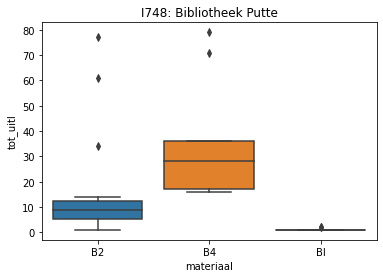

tot_uitl  ltst_jaar_uit   lft_exem instantie_id        bibliotheek
count  44.000000      44.000000  44.000000         I748  Bibliotheek Putte
mean   13.704545    2020.181818   7.772727         I748  Bibliotheek Putte
std    21.014480       3.134747   9.547589         I748  Bibliotheek Putte
min     1.000000    2011.000000   0.000000         I748  Bibliotheek Putte
25%     1.000000    2019.000000   0.000000         I748  Bibliotheek Putte
50%     3.500000    2022.000000   2.000000         I748  Bibliotheek Putte
75%    16.000000    2022.000000  14.750000         I748  Bibliotheek Putte
max    79.000000    2022.000000  25.000000         I748  Bibliotheek Putte

____________________________________________________________
Bibliotheek Puurs-Sint-Amands


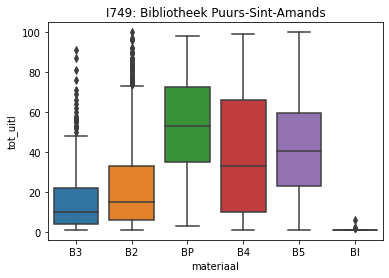

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2757.000000    2757.000000  2757.000000         I749   
mean     28.468625    2019.118244     9.987668         I749   
std      25.939827       3.288358     3.926556         I749   
min       1.000000    2007.000000     0.000000         I749   
25%       7.000000    2017.000000     7.000000         I749   
50%      20.000000    2021.000000    11.000000         I749   
75%      44.000000    2022.000000    13.000000         I749   
max     100.000000    2022.000000    15.000000         I749   

                         bibliotheek  
count  Bibliotheek Puurs-Sint-Amands  
mean   Bibliotheek Puurs-Sint-Amands  
std    Bibliotheek Puurs-Sint-Amands  
min    Bibliotheek Puurs-Sint-Amands  
25%    Bibliotheek Puurs-Sint-Amands  
50%    Bibliotheek Puurs-Sint-Amands  
75%    Bibliotheek Puurs-Sint-Amands  
max    Bibliotheek Puurs-Sint-Amands

____________________________________________________________
Bibliotheek Ranst


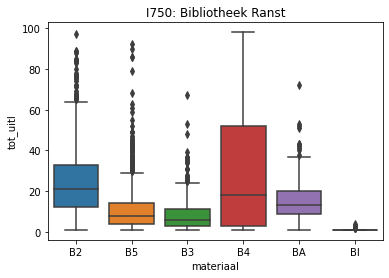

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  3206.000000    3206.000000  3206.000000         I750  Bibliotheek Ranst
mean     19.987211    2018.582034    11.397380         I750  Bibliotheek Ranst
std      21.439087       3.529326     2.885962         I750  Bibliotheek Ranst
min       1.000000    2008.000000     0.000000         I750  Bibliotheek Ranst
25%       5.000000    2017.000000    10.000000         I750  Bibliotheek Ranst
50%      12.000000    2020.000000    13.000000         I750  Bibliotheek Ranst
75%      27.000000    2021.000000    13.000000         I750  Bibliotheek Ranst
max      98.000000    2022.000000    14.000000         I750  Bibliotheek Ranst

____________________________________________________________
Bibliotheek Ravels


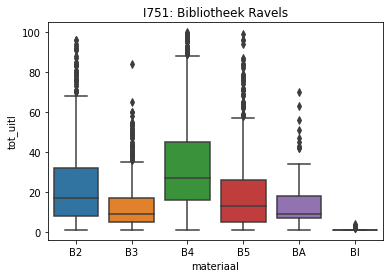

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  4532.000000    4532.000000  4532.000000         I751   
mean     21.962048    2019.812665     8.479479         I751   
std      20.033659       2.254007     4.201898         I751   
min       1.000000    2006.000000     0.000000         I751   
25%       7.000000    2019.000000     5.000000         I751   
50%      16.000000    2020.000000     8.000000         I751   
75%      31.000000    2021.000000    12.000000         I751   
max     100.000000    2022.000000    15.000000         I751   

              bibliotheek  
count  Bibliotheek Ravels  
mean   Bibliotheek Ravels  
std    Bibliotheek Ravels  
min    Bibliotheek Ravels  
25%    Bibliotheek Ravels  
50%    Bibliotheek Ravels  
75%    Bibliotheek Ravels  
max    Bibliotheek Ravels

____________________________________________________________
Bibliotheek Retie


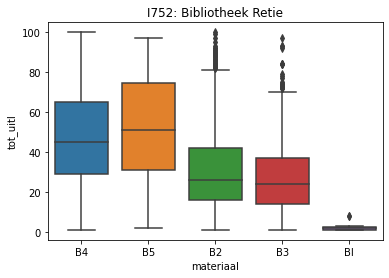

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  3348.000000    3348.000000  3348.000000         I752  Bibliotheek Retie
mean     35.502389    2020.173835     8.251493         I752  Bibliotheek Retie
std      22.659803       1.886916     2.751876         I752  Bibliotheek Retie
min       1.000000    2009.000000     0.000000         I752  Bibliotheek Retie
25%      18.000000    2020.000000     7.000000         I752  Bibliotheek Retie
50%      31.000000    2021.000000     8.000000         I752  Bibliotheek Retie
75%      50.000000    2021.000000    10.000000         I752  Bibliotheek Retie
max     100.000000    2022.000000    14.000000         I752  Bibliotheek Retie

____________________________________________________________
Bibliotheek Rijkevorsel


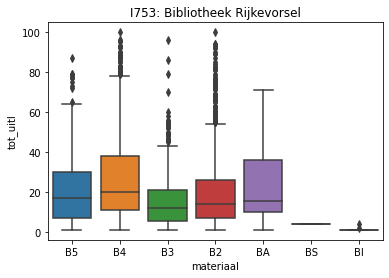

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  2895.000000    2895.000000  2895.00000         I753   
mean     21.520553    2019.381002     8.94715         I753   
std      19.186699       2.625743     3.02220         I753   
min       1.000000    2009.000000     0.00000         I753   
25%       8.000000    2018.000000     7.00000         I753   
50%      15.000000    2020.000000     8.00000         I753   
75%      29.000000    2021.000000    12.00000         I753   
max     100.000000    2022.000000    13.00000         I753   

                   bibliotheek  
count  Bibliotheek Rijkevorsel  
mean   Bibliotheek Rijkevorsel  
std    Bibliotheek Rijkevorsel  
min    Bibliotheek Rijkevorsel  
25%    Bibliotheek Rijkevorsel  
50%    Bibliotheek Rijkevorsel  
75%    Bibliotheek Rijkevorsel  
max    Bibliotheek Rijkevorsel

____________________________________________________________
Bibliotheek Rumst


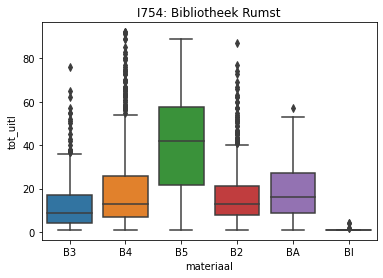

tot_uitl  ltst_jaar_uit     lft_exem instantie_id        bibliotheek
count  2638.000000    2638.000000  2638.000000         I754  Bibliotheek Rumst
mean     17.257771    2018.321835    10.866566         I754  Bibliotheek Rumst
std      15.516963       3.117942     2.528040         I754  Bibliotheek Rumst
min       1.000000    2009.000000     0.000000         I754  Bibliotheek Rumst
25%       6.000000    2017.000000    10.000000         I754  Bibliotheek Rumst
50%      12.000000    2019.000000    11.000000         I754  Bibliotheek Rumst
75%      23.000000    2021.000000    13.000000         I754  Bibliotheek Rumst
max      92.000000    2022.000000    13.000000         I754  Bibliotheek Rumst

____________________________________________________________
Bibliotheek Schilde


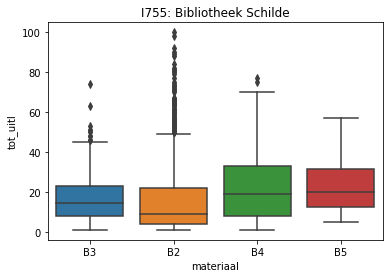

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1489.000000    1489.000000  1489.000000         I755   
mean     17.748825    2018.895903    10.208193         I755   
std      17.135569       2.872149     4.253672         I755   
min       1.000000    2005.000000     0.000000         I755   
25%       5.000000    2017.000000     7.000000         I755   
50%      12.000000    2019.000000    10.000000         I755   
75%      25.000000    2022.000000    13.000000         I755   
max     100.000000    2022.000000    22.000000         I755   

               bibliotheek  
count  Bibliotheek Schilde  
mean   Bibliotheek Schilde  
std    Bibliotheek Schilde  
min    Bibliotheek Schilde  
25%    Bibliotheek Schilde  
50%    Bibliotheek Schilde  
75%    Bibliotheek Schilde  
max    Bibliotheek Schilde

____________________________________________________________
Bibliotheek Schoten


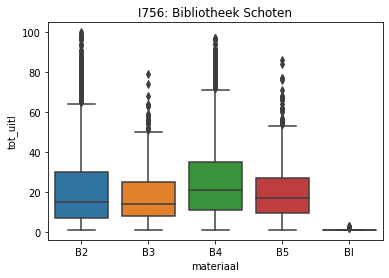

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6187.000000    6187.000000  6187.000000         I756   
mean     21.763860    2018.889769    11.247293         I756   
std      17.997458       2.836555     3.905811         I756   
min       1.000000    2006.000000     0.000000         I756   
25%       8.000000    2018.000000     8.000000         I756   
50%      17.000000    2019.000000    12.000000         I756   
75%      30.000000    2021.000000    15.000000         I756   
max     100.000000    2022.000000    15.000000         I756   

               bibliotheek  
count  Bibliotheek Schoten  
mean   Bibliotheek Schoten  
std    Bibliotheek Schoten  
min    Bibliotheek Schoten  
25%    Bibliotheek Schoten  
50%    Bibliotheek Schoten  
75%    Bibliotheek Schoten  
max    Bibliotheek Schoten

____________________________________________________________
Bibliotheek Sint-Katelijne-Waver


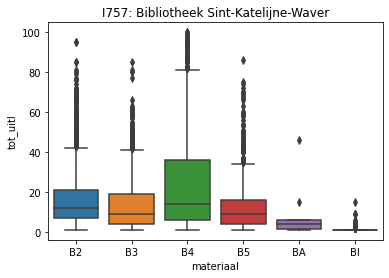

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  7169.000000    7169.000000  7169.000000         I757   
mean     17.948668    2019.983540     6.683638         I757   
std      18.514003       1.743533     1.545104         I757   
min       1.000000    2014.000000     0.000000         I757   
25%       5.000000    2019.000000     7.000000         I757   
50%      11.000000    2021.000000     7.000000         I757   
75%      24.000000    2021.000000     7.000000         I757   
max     100.000000    2022.000000     8.000000         I757   

                            bibliotheek  
count  Bibliotheek Sint-Katelijne-Waver  
mean   Bibliotheek Sint-Katelijne-Waver  
std    Bibliotheek Sint-Katelijne-Waver  
min    Bibliotheek Sint-Katelijne-Waver  
25%    Bibliotheek Sint-Katelijne-Waver  
50%    Bibliotheek Sint-Katelijne-Waver  
75%    Bibliotheek Sint-Katelijne-Waver  
max    Bibliotheek Sint-Katelijne-Waver

____________________________________________________________
Bibliotheek Stabroek


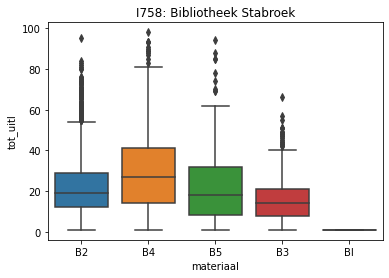

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  5502.000000    5502.000000  5502.000000         I758   
mean     22.754998    2020.090694     8.953835         I758   
std      15.075064       1.528244     3.163378         I758   
min       1.000000    2009.000000     0.000000         I758   
25%      12.000000    2019.000000     7.000000         I758   
50%      19.000000    2020.000000     9.000000         I758   
75%      31.000000    2021.000000    11.000000         I758   
max      98.000000    2022.000000    15.000000         I758   

                bibliotheek  
count  Bibliotheek Stabroek  
mean   Bibliotheek Stabroek  
std    Bibliotheek Stabroek  
min    Bibliotheek Stabroek  
25%    Bibliotheek Stabroek  
50%    Bibliotheek Stabroek  
75%    Bibliotheek Stabroek  
max    Bibliotheek Stabroek

____________________________________________________________
Bibliotheek Turnhout


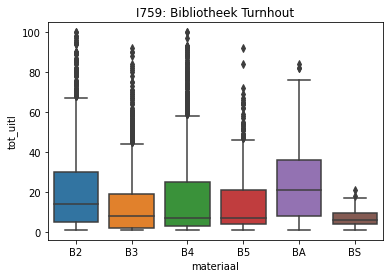

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  6177.000000    6177.000000  6177.000000         I759   
mean     16.565485    2020.440667     5.437591         I759   
std      18.987749       1.501322     1.301167         I759   
min       1.000000    2015.000000     0.000000         I759   
25%       3.000000    2020.000000     6.000000         I759   
50%       8.000000    2021.000000     6.000000         I759   
75%      24.000000    2021.000000     6.000000         I759   
max     100.000000    2022.000000     6.000000         I759   

                bibliotheek  
count  Bibliotheek Turnhout  
mean   Bibliotheek Turnhout  
std    Bibliotheek Turnhout  
min    Bibliotheek Turnhout  
25%    Bibliotheek Turnhout  
50%    Bibliotheek Turnhout  
75%    Bibliotheek Turnhout  
max    Bibliotheek Turnhout

____________________________________________________________
Bibliotheek Vorselaar


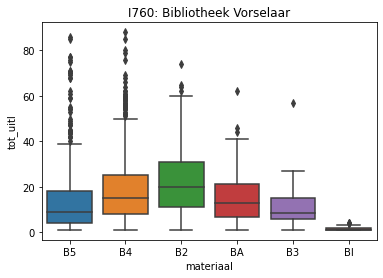

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2746.000000    2746.000000  2746.000000         I760   
mean     17.544064    2019.295339    10.455208         I760   
std      14.350329       2.886024     2.806380         I760   
min       1.000000    2010.000000     0.000000         I760   
25%       7.000000    2018.000000    10.000000         I760   
50%      14.000000    2020.000000    11.000000         I760   
75%      25.000000    2021.000000    12.000000         I760   
max      88.000000    2022.000000    12.000000         I760   

                 bibliotheek  
count  Bibliotheek Vorselaar  
mean   Bibliotheek Vorselaar  
std    Bibliotheek Vorselaar  
min    Bibliotheek Vorselaar  
25%    Bibliotheek Vorselaar  
50%    Bibliotheek Vorselaar  
75%    Bibliotheek Vorselaar  
max    Bibliotheek Vorselaar

____________________________________________________________
Bibliotheek Vosselaar


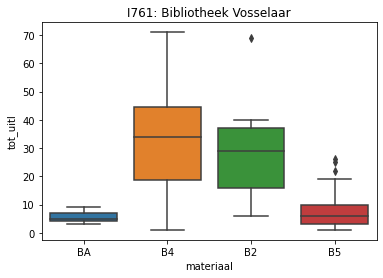

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  107.000000     107.000000  107.000000         I761   
mean    13.794393    2021.822430    3.280374         I761   
std     15.474714       0.998235    4.120346         I761   
min      1.000000    2012.000000    0.000000         I761   
25%      3.000000    2022.000000    1.000000         I761   
50%      8.000000    2022.000000    2.000000         I761   
75%     16.000000    2022.000000    4.000000         I761   
max     71.000000    2022.000000   18.000000         I761   

                 bibliotheek  
count  Bibliotheek Vosselaar  
mean   Bibliotheek Vosselaar  
std    Bibliotheek Vosselaar  
min    Bibliotheek Vosselaar  
25%    Bibliotheek Vosselaar  
50%    Bibliotheek Vosselaar  
75%    Bibliotheek Vosselaar  
max    Bibliotheek Vosselaar

____________________________________________________________
Bibliotheek Westerlo


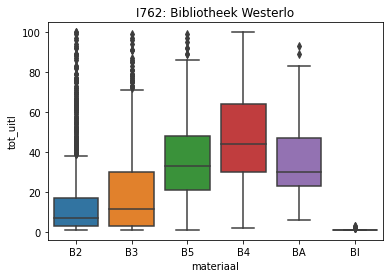

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3567.000000    3567.000000  3567.000000         I762   
mean     27.630221    2018.590412    10.427250         I762   
std      25.040860       3.795479     3.676595         I762   
min       1.000000    2008.000000     0.000000         I762   
25%       5.000000    2017.000000     8.000000         I762   
50%      21.000000    2020.000000    13.000000         I762   
75%      44.000000    2021.000000    13.000000         I762   
max     100.000000    2022.000000    14.000000         I762   

                bibliotheek  
count  Bibliotheek Westerlo  
mean   Bibliotheek Westerlo  
std    Bibliotheek Westerlo  
min    Bibliotheek Westerlo  
25%    Bibliotheek Westerlo  
50%    Bibliotheek Westerlo  
75%    Bibliotheek Westerlo  
max    Bibliotheek Westerlo

____________________________________________________________
Bibliotheek Wijnegem


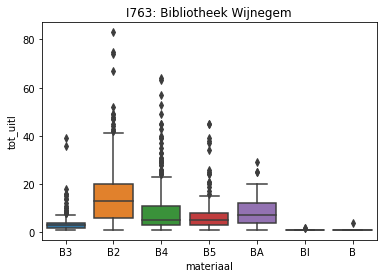

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  1326.000000    1326.000000  1326.000000         I763   
mean      9.138009    2019.646305     6.097285         I763   
std      10.230024       1.815472     1.873036         I763   
min       1.000000    2014.000000     0.000000         I763   
25%       3.000000    2018.000000     6.000000         I763   
50%       5.000000    2020.000000     7.000000         I763   
75%      12.000000    2021.000000     7.000000         I763   
max      83.000000    2022.000000     8.000000         I763   

                bibliotheek  
count  Bibliotheek Wijnegem  
mean   Bibliotheek Wijnegem  
std    Bibliotheek Wijnegem  
min    Bibliotheek Wijnegem  
25%    Bibliotheek Wijnegem  
50%    Bibliotheek Wijnegem  
75%    Bibliotheek Wijnegem  
max    Bibliotheek Wijnegem

____________________________________________________________
Bibliotheek Willebroek


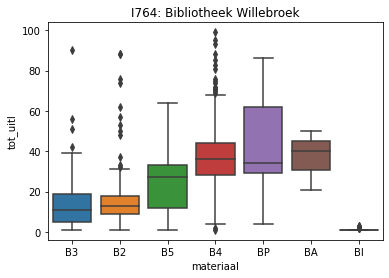

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  640.000000     640.000000  640.000000         I764   
mean    23.507812    2020.803125    6.182812         I764   
std     19.661850       1.298364    2.490549         I764   
min      1.000000    2014.000000    0.000000         I764   
25%      8.000000    2021.000000    6.000000         I764   
50%     19.000000    2021.000000    7.000000         I764   
75%     35.000000    2022.000000    8.000000         I764   
max     99.000000    2022.000000    8.000000         I764   

                  bibliotheek  
count  Bibliotheek Willebroek  
mean   Bibliotheek Willebroek  
std    Bibliotheek Willebroek  
min    Bibliotheek Willebroek  
25%    Bibliotheek Willebroek  
50%    Bibliotheek Willebroek  
75%    Bibliotheek Willebroek  
max    Bibliotheek Willebroek

____________________________________________________________
Bibliotheek Wommelgem


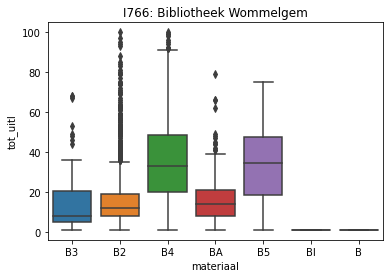

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3136.000000    3136.000000  3136.000000         I766   
mean     21.065051    2020.113520     7.268176         I766   
std      18.104188       1.738171     1.779689         I766   
min       1.000000    2013.000000     0.000000         I766   
25%       9.000000    2019.000000     7.000000         I766   
50%      15.000000    2021.000000     8.000000         I766   
75%      27.250000    2021.000000     8.000000         I766   
max     100.000000    2022.000000     9.000000         I766   

                 bibliotheek  
count  Bibliotheek Wommelgem  
mean   Bibliotheek Wommelgem  
std    Bibliotheek Wommelgem  
min    Bibliotheek Wommelgem  
25%    Bibliotheek Wommelgem  
50%    Bibliotheek Wommelgem  
75%    Bibliotheek Wommelgem  
max    Bibliotheek Wommelgem

____________________________________________________________
Bibliotheek Wuustwezel


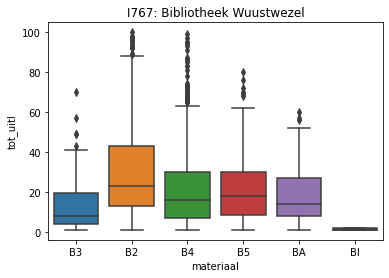

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  2298.000000    2298.000000  2298.000000         I767   
mean     22.982158    2019.754569     8.240209         I767   
std      19.332103       2.401528     3.095168         I767   
min       1.000000    2011.000000     0.000000         I767   
25%       8.000000    2019.000000     8.000000         I767   
50%      18.000000    2021.000000    10.000000         I767   
75%      32.000000    2021.000000    10.000000         I767   
max     100.000000    2022.000000    11.000000         I767   

                  bibliotheek  
count  Bibliotheek Wuustwezel  
mean   Bibliotheek Wuustwezel  
std    Bibliotheek Wuustwezel  
min    Bibliotheek Wuustwezel  
25%    Bibliotheek Wuustwezel  
50%    Bibliotheek Wuustwezel  
75%    Bibliotheek Wuustwezel  
max    Bibliotheek Wuustwezel

____________________________________________________________
Bibliotheek Zandhoven


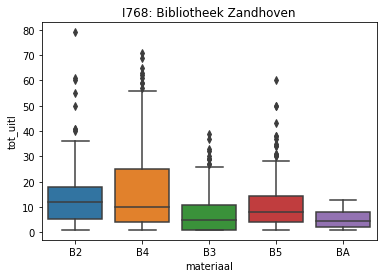

tot_uitl  ltst_jaar_uit    lft_exem instantie_id  \
count  942.000000     942.000000  942.000000         I768   
mean    13.037155    2019.806794    5.761146         I768   
std     13.551088       1.844899    1.000137         I768   
min      1.000000    2015.000000    0.000000         I768   
25%      3.000000    2019.000000    6.000000         I768   
50%      8.000000    2020.000000    6.000000         I768   
75%     18.000000    2021.000000    6.000000         I768   
max     79.000000    2022.000000    7.000000         I768   

                 bibliotheek  
count  Bibliotheek Zandhoven  
mean   Bibliotheek Zandhoven  
std    Bibliotheek Zandhoven  
min    Bibliotheek Zandhoven  
25%    Bibliotheek Zandhoven  
50%    Bibliotheek Zandhoven  
75%    Bibliotheek Zandhoven  
max    Bibliotheek Zandhoven

____________________________________________________________
Bibliotheek Zoersel


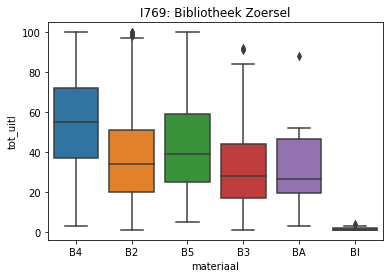

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3119.000000    3119.000000  3119.000000         I769   
mean     41.489259    2020.410388    11.621994         I769   
std      24.297569       1.848730     3.920446         I769   
min       1.000000    2008.000000     0.000000         I769   
25%      22.000000    2019.000000    10.000000         I769   
50%      38.000000    2021.000000    13.000000         I769   
75%      59.000000    2022.000000    15.000000         I769   
max     100.000000    2022.000000    15.000000         I769   

               bibliotheek  
count  Bibliotheek Zoersel  
mean   Bibliotheek Zoersel  
std    Bibliotheek Zoersel  
min    Bibliotheek Zoersel  
25%    Bibliotheek Zoersel  
50%    Bibliotheek Zoersel  
75%    Bibliotheek Zoersel  
max    Bibliotheek Zoersel

____________________________________________________________
Bibliotheek Zwijndrecht


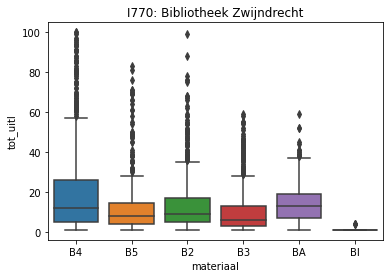

tot_uitl  ltst_jaar_uit     lft_exem instantie_id  \
count  3555.000000    3555.000000  3555.000000         I770   
mean     14.193812    2017.844163    12.688326         I770   
std      15.957257       3.812711     2.987343         I770   
min       1.000000    2007.000000     0.000000         I770   
25%       4.000000    2016.000000    13.000000         I770   
50%       9.000000    2019.000000    14.000000         I770   
75%      18.000000    2021.000000    14.000000         I770   
max     100.000000    2022.000000    15.000000         I770   

                   bibliotheek  
count  Bibliotheek Zwijndrecht  
mean   Bibliotheek Zwijndrecht  
std    Bibliotheek Zwijndrecht  
min    Bibliotheek Zwijndrecht  
25%    Bibliotheek Zwijndrecht  
50%    Bibliotheek Zwijndrecht  
75%    Bibliotheek Zwijndrecht  
max    Bibliotheek Zwijndrecht

____________________________________________________________
Bibliotheek Zonnedorp


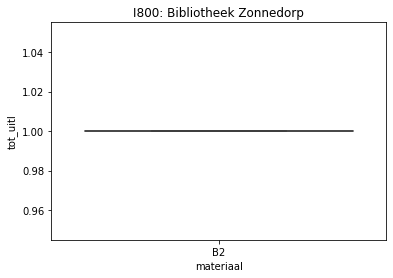

tot_uitl  ltst_jaar_uit  lft_exem instantie_id            bibliotheek
count       1.0            1.0       1.0         I800  Bibliotheek Zonnedorp
mean        1.0         2020.0       1.0         I800  Bibliotheek Zonnedorp
std         NaN            NaN       NaN         I800  Bibliotheek Zonnedorp
min         1.0         2020.0       1.0         I800  Bibliotheek Zonnedorp
25%         1.0         2020.0       1.0         I800  Bibliotheek Zonnedorp
50%         1.0         2020.0       1.0         I800  Bibliotheek Zonnedorp
75%         1.0         2020.0       1.0         I800  Bibliotheek Zonnedorp
max         1.0         2020.0       1.0         I800  Bibliotheek Zonnedorp

____________________________________________________________


In [8]:
for instantie in instanties:
    plot_afvoer_instantie(instantie)